# Generalized-Controllable Variational Autoencoder

GCVAE Loss: 
\begin{align}
    \mathcal{L}(x, z; \theta, \phi, \alpha, &\beta, \gamma) = (1- \alpha_t- \beta_t)\underset{z \sim q_{\phi}(z|x)}{\mathbb{E}}[\ln p_{\theta}(x|z)] - \beta_t\underset{p_{\mathcal{D}}}{\mathbb{E}} D_{KL}(q_{\phi}(z|x)|| p_{\theta}(z)) + \gamma_t D_{KL}(q_{\phi}(z)||p_{\theta}(z))
    \label{gcvae:eqn1}
\end{align}

We assume that the data is a Gaussian for this experiment,
\begin{align}
\underset{z \sim q_{\phi}(z|x)}{\mathbb{E}}[\ln p_{\theta}(x|z)] &= \| x - \hat{x} \|^{2}_{2} \notag\\
\underset{p_{\mathcal{D}}}{\mathbb{E}} D_{KL}(q_{\phi}(z|x)|| p_{\theta}(z)) &= \frac{1}{2} \left[\ln \left|\frac{\Sigma_1}{\Sigma_0}\right| + m - tr(\Sigma_1\Sigma_0^{-1}) -  (\mu_1 - \mu_0)^T\Sigma_0^{-1}(\mu_1 - \mu_0)\right] \quad ()\notag \\
D_{KL}(q_{\phi}(z)||p_{\theta}(z)) &= D_{MMD}^{2}(q||p) \quad \text{or} \quad D_{MAH}(q||p)
\end{align}


### import dependencies 

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#------------------basic dependencies --------------------
seed = 42
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import tensorflow_datasets as tfds
from train_gcvae_2d import train_gcvae as gcvae #change this to train_gcvae_2d if you are working with GCVAE
#----import trainer for distributed training
#from train_gcvae_distrib import train_gcvae_distrib
from sklearn.model_selection import train_test_split
from utils import plot_latent_space, compute_metric, model_saver, model_saver_2d
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams['figure.dpi'] = 120
import seaborn as sns
#set random seed
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:
path = os.getcwd()

In [8]:
path

'/home/ifeanyi.ezukwoke/Documents/FA4.0/kenneth/Scripts/Modeling/Autoencoder'

### import data

In [78]:
#declare path
path = os.getcwd()

#import data
datatype = "mnist"

batch_size = 64
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
N, L, M = x_train.shape
x_train = x_train.reshape(-1, L, M, 1).astype('float32') / x_train.max()
x_train, _ = train_test_split(x_train, test_size = .999, random_state = 42)
x_test = x_test.reshape(-1, L, M, 1).astype('float32') / x_train.max()
x_test, _ = train_test_split(x_test, test_size = .992, random_state = 42)

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size)

#test data
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.shuffle(buffer_size = 1024).batch(batch_size)

In [79]:
print(f'Shape of train data: {x_train.shape}\nShape of test data: {x_test.shape}')

Shape of train data: (60, 28, 28, 1)
Shape of test data: (80, 28, 28, 1)


Train data:


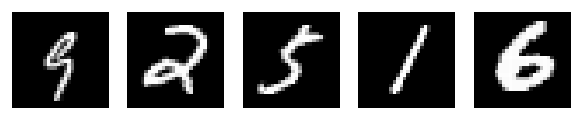

Test data:


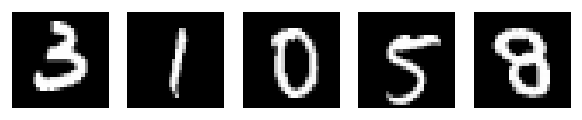

In [80]:
print('Train data:')
for i in range(5):  
    plt.subplot(150 + 1 + i)
    plt.imshow(x_train[i], cmap = plt.get_cmap('gray'))
    plt.axis('off')
plt.show()
print('Test data:')
for i in range(5):  
    plt.subplot(150 + 1 + i)
    plt.imshow(x_test[i], cmap = plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

### Try Variational AutoEncoder first

In [95]:
loss_index = 0
# vae_type = 'gcvae' #else infovae
inp_shape =  x_train.shape[1:]
num_features = inp_shape[0]

#the parameters are only to change fixed weights
params = { #beta, gamma
            'elbo': (1, 0),
            'betavae': ((1, 5), 0),
            'controlvae': (0, 0),
            'infovae': (0, 500),
            'gcvae': (1, 1), #not necessarily useful inside algo
    }

lr = 1e-3
epochs = 500
hidden_dim = 100
latent_dims = 2
loss_type = list(params.keys())[loss_index] #elbo -> 0; beta-> 1; controlvae -> 2; infovae -> 3; gcvae -> 4
archi_type = 'v2'
#params
distrib_type = 'g'
beta, gamma = params[f'{loss_type}']
mmd_typ = 'mmd' #['mmd', 'mah', 'mah_rkhs', 'mah_gcvae']
save_model_arg = False
save_model_after = 10
model = gcvae(inp_shape = inp_shape,
                    num_features = num_features,
                    hidden_dim = hidden_dim,
                    latent_dim = latent_dims, 
                    batch_size = batch_size,
                    beta = beta,
                    gamma = gamma,
                    dist = distrib_type,
                    vloss = loss_type,
                    lr = lr, 
                    epochs = epochs,
                    architecture = archi_type,
                    mmd_type = mmd_typ).fit(train_dataset, x_test,
                                            datatype, stopping = False,
                                            save_model = save_model_arg,
                                            save_model_iter = save_model_after)

100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 1 - ELBO: 87.654 - RECON. LOSS: 87.644 - KL: 0.010 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 2 - ELBO: 84.261 - RECON. LOSS: 84.255 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 3 - ELBO: 80.707 - RECON. LOSS: 80.700 - KL: 0.007 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 4 - ELBO: 77.957 - RECON. LOSS: 77.948 - KL: 0.009 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 5 - ELBO: 76.123 - RECON. LOSS: 76.107 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 6 - ELBO: 75.063 - RECON. LOSS: 75.043 - KL: 0.021 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 7 - ELBO: 74.651 - RECON. LOSS: 74.629 - KL: 0.022 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 8 - ELBO: 73.653 - RECON. LOSS: 73.631 - KL: 0.021 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 9 - ELBO: 72.750 - RECON. LOSS: 72.730 - KL: 0.020 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 10 - ELBO: 72.102 - RECON. LOSS: 72.083 - KL: 0.019 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 11 - ELBO: 71.439 - RECON. LOSS: 71.421 - KL: 0.018 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 12 - ELBO: 71.087 - RECON. LOSS: 71.071 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 13 - ELBO: 70.584 - RECON. LOSS: 70.569 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 14 - ELBO: 70.040 - RECON. LOSS: 70.026 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


epoch 15 - ELBO: 69.489 - RECON. LOSS: 69.475 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 16 - ELBO: 69.027 - RECON. LOSS: 69.014 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 17 - ELBO: 68.533 - RECON. LOSS: 68.520 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 18 - ELBO: 68.156 - RECON. LOSS: 68.144 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 19 - ELBO: 67.661 - RECON. LOSS: 67.649 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 20 - ELBO: 67.184 - RECON. LOSS: 67.173 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 21 - ELBO: 66.726 - RECON. LOSS: 66.715 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


epoch 22 - ELBO: 66.347 - RECON. LOSS: 66.336 - KL: 0.010 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


epoch 23 - ELBO: 65.970 - RECON. LOSS: 65.960 - KL: 0.010 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 24 - ELBO: 65.531 - RECON. LOSS: 65.521 - KL: 0.010 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 25 - ELBO: 65.191 - RECON. LOSS: 65.181 - KL: 0.009 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 26 - ELBO: 64.827 - RECON. LOSS: 64.818 - KL: 0.009 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 27 - ELBO: 64.575 - RECON. LOSS: 64.566 - KL: 0.009 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 28 - ELBO: 64.272 - RECON. LOSS: 64.263 - KL: 0.009 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


epoch 29 - ELBO: 64.011 - RECON. LOSS: 64.002 - KL: 0.008 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 30 - ELBO: 63.764 - RECON. LOSS: 63.756 - KL: 0.008 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 31 - ELBO: 63.501 - RECON. LOSS: 63.493 - KL: 0.008 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 32 - ELBO: 63.243 - RECON. LOSS: 63.235 - KL: 0.008 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 33 - ELBO: 62.995 - RECON. LOSS: 62.988 - KL: 0.007 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


epoch 34 - ELBO: 62.780 - RECON. LOSS: 62.772 - KL: 0.007 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


epoch 35 - ELBO: 62.542 - RECON. LOSS: 62.535 - KL: 0.007 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 36 - ELBO: 62.331 - RECON. LOSS: 62.324 - KL: 0.007 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 37 - ELBO: 62.125 - RECON. LOSS: 62.118 - KL: 0.007 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 38 - ELBO: 61.911 - RECON. LOSS: 61.905 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 39 - ELBO: 61.718 - RECON. LOSS: 61.712 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 40 - ELBO: 61.527 - RECON. LOSS: 61.521 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 41 - ELBO: 61.352 - RECON. LOSS: 61.346 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 42 - ELBO: 61.187 - RECON. LOSS: 61.181 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 43 - ELBO: 61.025 - RECON. LOSS: 61.020 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 44 - ELBO: 60.861 - RECON. LOSS: 60.855 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 45 - ELBO: 60.706 - RECON. LOSS: 60.701 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 46 - ELBO: 60.563 - RECON. LOSS: 60.558 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 47 - ELBO: 60.422 - RECON. LOSS: 60.417 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 48 - ELBO: 60.280 - RECON. LOSS: 60.275 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 49 - ELBO: 60.147 - RECON. LOSS: 60.142 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 50 - ELBO: 60.019 - RECON. LOSS: 60.014 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 51 - ELBO: 59.895 - RECON. LOSS: 59.890 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

epoch 52 - ELBO: 59.770 - RECON. LOSS: 59.765 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000



100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 53 - ELBO: 59.652 - RECON. LOSS: 59.647 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 54 - ELBO: 59.539 - RECON. LOSS: 59.535 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 55 - ELBO: 59.430 - RECON. LOSS: 59.426 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 56 - ELBO: 59.325 - RECON. LOSS: 59.320 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 57 - ELBO: 59.220 - RECON. LOSS: 59.216 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 58 - ELBO: 59.120 - RECON. LOSS: 59.115 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 59 - ELBO: 59.019 - RECON. LOSS: 59.015 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 60 - ELBO: 58.923 - RECON. LOSS: 58.919 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 61 - ELBO: 58.831 - RECON. LOSS: 58.827 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 62 - ELBO: 58.741 - RECON. LOSS: 58.737 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 63 - ELBO: 58.654 - RECON. LOSS: 58.650 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 64 - ELBO: 58.568 - RECON. LOSS: 58.564 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 65 - ELBO: 58.485 - RECON. LOSS: 58.481 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 66 - ELBO: 58.404 - RECON. LOSS: 58.400 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 67 - ELBO: 58.326 - RECON. LOSS: 58.322 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


epoch 68 - ELBO: 58.249 - RECON. LOSS: 58.246 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 69 - ELBO: 58.176 - RECON. LOSS: 58.172 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


epoch 70 - ELBO: 58.103 - RECON. LOSS: 58.100 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 71 - ELBO: 58.032 - RECON. LOSS: 58.029 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


epoch 72 - ELBO: 57.963 - RECON. LOSS: 57.960 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 73 - ELBO: 57.897 - RECON. LOSS: 57.894 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 74 - ELBO: 57.834 - RECON. LOSS: 57.830 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 75 - ELBO: 57.771 - RECON. LOSS: 57.767 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 76 - ELBO: 57.707 - RECON. LOSS: 57.704 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 77 - ELBO: 57.647 - RECON. LOSS: 57.644 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 78 - ELBO: 57.588 - RECON. LOSS: 57.584 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 79 - ELBO: 57.528 - RECON. LOSS: 57.525 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 80 - ELBO: 57.473 - RECON. LOSS: 57.470 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 81 - ELBO: 57.416 - RECON. LOSS: 57.413 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 82 - ELBO: 57.362 - RECON. LOSS: 57.359 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 83 - ELBO: 57.310 - RECON. LOSS: 57.307 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 84 - ELBO: 57.258 - RECON. LOSS: 57.255 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 85 - ELBO: 57.211 - RECON. LOSS: 57.208 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 86 - ELBO: 57.162 - RECON. LOSS: 57.159 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 87 - ELBO: 57.115 - RECON. LOSS: 57.112 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 88 - ELBO: 57.069 - RECON. LOSS: 57.066 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 89 - ELBO: 57.021 - RECON. LOSS: 57.018 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 90 - ELBO: 56.975 - RECON. LOSS: 56.972 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 91 - ELBO: 56.931 - RECON. LOSS: 56.928 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 92 - ELBO: 56.888 - RECON. LOSS: 56.885 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 93 - ELBO: 56.844 - RECON. LOSS: 56.841 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 94 - ELBO: 56.801 - RECON. LOSS: 56.798 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 95 - ELBO: 56.760 - RECON. LOSS: 56.757 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 96 - ELBO: 56.719 - RECON. LOSS: 56.716 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 97 - ELBO: 56.678 - RECON. LOSS: 56.675 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 98 - ELBO: 56.641 - RECON. LOSS: 56.638 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 99 - ELBO: 56.605 - RECON. LOSS: 56.602 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 100 - ELBO: 56.569 - RECON. LOSS: 56.566 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 101 - ELBO: 56.533 - RECON. LOSS: 56.530 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 102 - ELBO: 56.494 - RECON. LOSS: 56.491 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

epoch 103 - ELBO: 56.460 - RECON. LOSS: 56.457 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 104 - ELBO: 56.424 - RECON. LOSS: 56.422 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 105 - ELBO: 56.391 - RECON. LOSS: 56.388 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 106 - ELBO: 56.357 - RECON. LOSS: 56.354 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 107 - ELBO: 56.324 - RECON. LOSS: 56.321 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 108 - ELBO: 56.290 - RECON. LOSS: 56.288 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 109 - ELBO: 56.258 - RECON. LOSS: 56.255 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 110 - ELBO: 56.228 - RECON. LOSS: 56.225 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 111 - ELBO: 56.198 - RECON. LOSS: 56.196 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 112 - ELBO: 56.167 - RECON. LOSS: 56.165 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 113 - ELBO: 56.136 - RECON. LOSS: 56.133 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 114 - ELBO: 56.108 - RECON. LOSS: 56.105 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 115 - ELBO: 56.080 - RECON. LOSS: 56.077 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 116 - ELBO: 56.050 - RECON. LOSS: 56.048 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 117 - ELBO: 56.023 - RECON. LOSS: 56.021 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 118 - ELBO: 55.994 - RECON. LOSS: 55.992 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 119 - ELBO: 55.968 - RECON. LOSS: 55.966 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 120 - ELBO: 55.943 - RECON. LOSS: 55.940 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 121 - ELBO: 55.916 - RECON. LOSS: 55.914 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 122 - ELBO: 55.891 - RECON. LOSS: 55.888 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 123 - ELBO: 55.867 - RECON. LOSS: 55.864 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 124 - ELBO: 55.842 - RECON. LOSS: 55.840 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 125 - ELBO: 55.817 - RECON. LOSS: 55.814 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 126 - ELBO: 55.793 - RECON. LOSS: 55.790 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 127 - ELBO: 55.769 - RECON. LOSS: 55.766 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 128 - ELBO: 55.744 - RECON. LOSS: 55.741 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 129 - ELBO: 55.722 - RECON. LOSS: 55.718 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 130 - ELBO: 55.699 - RECON. LOSS: 55.695 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 131 - ELBO: 55.676 - RECON. LOSS: 55.673 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 132 - ELBO: 55.654 - RECON. LOSS: 55.650 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 133 - ELBO: 55.631 - RECON. LOSS: 55.628 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 134 - ELBO: 55.609 - RECON. LOSS: 55.606 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 135 - ELBO: 55.588 - RECON. LOSS: 55.584 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 136 - ELBO: 55.566 - RECON. LOSS: 55.563 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 137 - ELBO: 55.545 - RECON. LOSS: 55.542 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 138 - ELBO: 55.523 - RECON. LOSS: 55.520 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 139 - ELBO: 55.503 - RECON. LOSS: 55.500 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 140 - ELBO: 55.482 - RECON. LOSS: 55.479 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 141 - ELBO: 55.463 - RECON. LOSS: 55.460 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 142 - ELBO: 55.443 - RECON. LOSS: 55.440 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 143 - ELBO: 55.423 - RECON. LOSS: 55.419 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


epoch 144 - ELBO: 55.403 - RECON. LOSS: 55.400 - KL: 0.003 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 145 - ELBO: 55.383 - RECON. LOSS: 55.380 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 146 - ELBO: 55.368 - RECON. LOSS: 55.364 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 147 - ELBO: 55.350 - RECON. LOSS: 55.346 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 148 - ELBO: 55.332 - RECON. LOSS: 55.328 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 149 - ELBO: 55.314 - RECON. LOSS: 55.310 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 150 - ELBO: 55.297 - RECON. LOSS: 55.293 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 151 - ELBO: 55.281 - RECON. LOSS: 55.277 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


epoch 152 - ELBO: 55.264 - RECON. LOSS: 55.259 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 153 - ELBO: 55.246 - RECON. LOSS: 55.241 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 154 - ELBO: 55.229 - RECON. LOSS: 55.223 - KL: 0.005 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


epoch 155 - ELBO: 55.212 - RECON. LOSS: 55.206 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 156 - ELBO: 55.195 - RECON. LOSS: 55.189 - KL: 0.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


epoch 157 - ELBO: 55.179 - RECON. LOSS: 55.173 - KL: 0.007 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 158 - ELBO: 55.162 - RECON. LOSS: 55.155 - KL: 0.007 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 159 - ELBO: 55.144 - RECON. LOSS: 55.137 - KL: 0.007 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 160 - ELBO: 55.126 - RECON. LOSS: 55.118 - KL: 0.008 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 161 - ELBO: 55.109 - RECON. LOSS: 55.100 - KL: 0.009 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 162 - ELBO: 55.093 - RECON. LOSS: 55.084 - KL: 0.009 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 163 - ELBO: 55.078 - RECON. LOSS: 55.068 - KL: 0.010 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 164 - ELBO: 55.061 - RECON. LOSS: 55.050 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 165 - ELBO: 55.045 - RECON. LOSS: 55.031 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 166 - ELBO: 55.030 - RECON. LOSS: 55.015 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 167 - ELBO: 55.014 - RECON. LOSS: 54.998 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 168 - ELBO: 54.997 - RECON. LOSS: 54.979 - KL: 0.018 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 169 - ELBO: 54.984 - RECON. LOSS: 54.964 - KL: 0.020 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 170 - ELBO: 54.968 - RECON. LOSS: 54.945 - KL: 0.023 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 171 - ELBO: 54.950 - RECON. LOSS: 54.925 - KL: 0.025 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 172 - ELBO: 54.934 - RECON. LOSS: 54.907 - KL: 0.027 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 173 - ELBO: 54.915 - RECON. LOSS: 54.884 - KL: 0.030 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 174 - ELBO: 54.892 - RECON. LOSS: 54.859 - KL: 0.033 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 175 - ELBO: 54.874 - RECON. LOSS: 54.837 - KL: 0.037 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


epoch 176 - ELBO: 54.852 - RECON. LOSS: 54.811 - KL: 0.041 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 177 - ELBO: 54.832 - RECON. LOSS: 54.787 - KL: 0.046 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


epoch 178 - ELBO: 54.817 - RECON. LOSS: 54.767 - KL: 0.050 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 179 - ELBO: 54.797 - RECON. LOSS: 54.742 - KL: 0.055 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 180 - ELBO: 54.776 - RECON. LOSS: 54.716 - KL: 0.060 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 181 - ELBO: 54.756 - RECON. LOSS: 54.690 - KL: 0.066 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


epoch 182 - ELBO: 54.737 - RECON. LOSS: 54.665 - KL: 0.073 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 183 - ELBO: 54.721 - RECON. LOSS: 54.643 - KL: 0.078 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 184 - ELBO: 54.702 - RECON. LOSS: 54.618 - KL: 0.084 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 185 - ELBO: 54.677 - RECON. LOSS: 54.587 - KL: 0.090 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 186 - ELBO: 54.652 - RECON. LOSS: 54.556 - KL: 0.096 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 187 - ELBO: 54.627 - RECON. LOSS: 54.526 - KL: 0.102 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 188 - ELBO: 54.601 - RECON. LOSS: 54.494 - KL: 0.107 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 189 - ELBO: 54.578 - RECON. LOSS: 54.465 - KL: 0.113 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 190 - ELBO: 54.555 - RECON. LOSS: 54.437 - KL: 0.119 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 191 - ELBO: 54.532 - RECON. LOSS: 54.408 - KL: 0.125 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 192 - ELBO: 54.513 - RECON. LOSS: 54.382 - KL: 0.131 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 193 - ELBO: 54.489 - RECON. LOSS: 54.352 - KL: 0.137 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 194 - ELBO: 54.468 - RECON. LOSS: 54.325 - KL: 0.143 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 195 - ELBO: 54.450 - RECON. LOSS: 54.301 - KL: 0.149 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 196 - ELBO: 54.427 - RECON. LOSS: 54.272 - KL: 0.156 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 197 - ELBO: 54.405 - RECON. LOSS: 54.244 - KL: 0.161 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 198 - ELBO: 54.383 - RECON. LOSS: 54.216 - KL: 0.167 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 199 - ELBO: 54.365 - RECON. LOSS: 54.192 - KL: 0.173 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 200 - ELBO: 54.343 - RECON. LOSS: 54.165 - KL: 0.178 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 201 - ELBO: 54.321 - RECON. LOSS: 54.138 - KL: 0.183 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 202 - ELBO: 54.300 - RECON. LOSS: 54.112 - KL: 0.188 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 203 - ELBO: 54.277 - RECON. LOSS: 54.084 - KL: 0.193 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 204 - ELBO: 54.257 - RECON. LOSS: 54.059 - KL: 0.198 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 205 - ELBO: 54.232 - RECON. LOSS: 54.029 - KL: 0.204 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 206 - ELBO: 54.212 - RECON. LOSS: 54.003 - KL: 0.209 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 207 - ELBO: 54.190 - RECON. LOSS: 53.976 - KL: 0.214 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 208 - ELBO: 54.170 - RECON. LOSS: 53.950 - KL: 0.220 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 209 - ELBO: 54.146 - RECON. LOSS: 53.921 - KL: 0.225 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 210 - ELBO: 54.126 - RECON. LOSS: 53.896 - KL: 0.230 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 211 - ELBO: 54.106 - RECON. LOSS: 53.870 - KL: 0.235 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 212 - ELBO: 54.082 - RECON. LOSS: 53.841 - KL: 0.241 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 213 - ELBO: 54.058 - RECON. LOSS: 53.811 - KL: 0.247 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 214 - ELBO: 54.036 - RECON. LOSS: 53.783 - KL: 0.253 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 215 - ELBO: 54.014 - RECON. LOSS: 53.756 - KL: 0.259 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 216 - ELBO: 53.994 - RECON. LOSS: 53.730 - KL: 0.265 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 217 - ELBO: 53.973 - RECON. LOSS: 53.703 - KL: 0.270 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 218 - ELBO: 53.953 - RECON. LOSS: 53.677 - KL: 0.276 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 219 - ELBO: 53.932 - RECON. LOSS: 53.650 - KL: 0.281 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 220 - ELBO: 53.912 - RECON. LOSS: 53.625 - KL: 0.287 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 221 - ELBO: 53.894 - RECON. LOSS: 53.601 - KL: 0.293 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 222 - ELBO: 53.874 - RECON. LOSS: 53.575 - KL: 0.299 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 223 - ELBO: 53.855 - RECON. LOSS: 53.551 - KL: 0.304 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 224 - ELBO: 53.834 - RECON. LOSS: 53.524 - KL: 0.310 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 225 - ELBO: 53.817 - RECON. LOSS: 53.501 - KL: 0.315 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 226 - ELBO: 53.795 - RECON. LOSS: 53.474 - KL: 0.321 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 227 - ELBO: 53.776 - RECON. LOSS: 53.450 - KL: 0.326 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 228 - ELBO: 53.753 - RECON. LOSS: 53.421 - KL: 0.332 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 229 - ELBO: 53.733 - RECON. LOSS: 53.395 - KL: 0.337 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 230 - ELBO: 53.710 - RECON. LOSS: 53.367 - KL: 0.343 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 231 - ELBO: 53.691 - RECON. LOSS: 53.343 - KL: 0.348 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 232 - ELBO: 53.671 - RECON. LOSS: 53.318 - KL: 0.353 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 233 - ELBO: 53.652 - RECON. LOSS: 53.294 - KL: 0.358 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 234 - ELBO: 53.631 - RECON. LOSS: 53.268 - KL: 0.363 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 235 - ELBO: 53.610 - RECON. LOSS: 53.242 - KL: 0.368 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 236 - ELBO: 53.589 - RECON. LOSS: 53.216 - KL: 0.373 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 237 - ELBO: 53.566 - RECON. LOSS: 53.188 - KL: 0.378 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 238 - ELBO: 53.546 - RECON. LOSS: 53.163 - KL: 0.383 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 239 - ELBO: 53.524 - RECON. LOSS: 53.137 - KL: 0.388 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 240 - ELBO: 53.503 - RECON. LOSS: 53.110 - KL: 0.392 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 241 - ELBO: 53.481 - RECON. LOSS: 53.084 - KL: 0.397 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 242 - ELBO: 53.460 - RECON. LOSS: 53.058 - KL: 0.401 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 243 - ELBO: 53.438 - RECON. LOSS: 53.032 - KL: 0.406 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 244 - ELBO: 53.415 - RECON. LOSS: 53.005 - KL: 0.410 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


epoch 245 - ELBO: 53.394 - RECON. LOSS: 52.980 - KL: 0.414 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


epoch 246 - ELBO: 53.371 - RECON. LOSS: 52.953 - KL: 0.418 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 247 - ELBO: 53.348 - RECON. LOSS: 52.926 - KL: 0.422 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 248 - ELBO: 53.326 - RECON. LOSS: 52.899 - KL: 0.426 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


epoch 249 - ELBO: 53.307 - RECON. LOSS: 52.876 - KL: 0.431 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 250 - ELBO: 53.286 - RECON. LOSS: 52.851 - KL: 0.435 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 251 - ELBO: 53.265 - RECON. LOSS: 52.826 - KL: 0.439 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


epoch 252 - ELBO: 53.243 - RECON. LOSS: 52.800 - KL: 0.443 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 253 - ELBO: 53.223 - RECON. LOSS: 52.775 - KL: 0.448 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 254 - ELBO: 53.201 - RECON. LOSS: 52.749 - KL: 0.452 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


epoch 255 - ELBO: 53.181 - RECON. LOSS: 52.724 - KL: 0.457 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 256 - ELBO: 53.158 - RECON. LOSS: 52.697 - KL: 0.461 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 257 - ELBO: 53.138 - RECON. LOSS: 52.672 - KL: 0.466 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 258 - ELBO: 53.118 - RECON. LOSS: 52.647 - KL: 0.470 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 259 - ELBO: 53.099 - RECON. LOSS: 52.624 - KL: 0.475 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 260 - ELBO: 53.076 - RECON. LOSS: 52.597 - KL: 0.480 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 261 - ELBO: 53.056 - RECON. LOSS: 52.572 - KL: 0.484 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 262 - ELBO: 53.034 - RECON. LOSS: 52.545 - KL: 0.488 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 263 - ELBO: 53.013 - RECON. LOSS: 52.520 - KL: 0.493 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 264 - ELBO: 52.992 - RECON. LOSS: 52.495 - KL: 0.497 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 265 - ELBO: 52.971 - RECON. LOSS: 52.470 - KL: 0.501 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 266 - ELBO: 52.953 - RECON. LOSS: 52.448 - KL: 0.505 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


epoch 267 - ELBO: 52.932 - RECON. LOSS: 52.423 - KL: 0.509 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


epoch 268 - ELBO: 52.911 - RECON. LOSS: 52.397 - KL: 0.514 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 269 - ELBO: 52.890 - RECON. LOSS: 52.372 - KL: 0.518 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 270 - ELBO: 52.870 - RECON. LOSS: 52.347 - KL: 0.523 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 271 - ELBO: 52.850 - RECON. LOSS: 52.323 - KL: 0.527 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 272 - ELBO: 52.831 - RECON. LOSS: 52.299 - KL: 0.532 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 273 - ELBO: 52.810 - RECON. LOSS: 52.273 - KL: 0.537 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 274 - ELBO: 52.789 - RECON. LOSS: 52.248 - KL: 0.541 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 275 - ELBO: 52.769 - RECON. LOSS: 52.222 - KL: 0.546 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


epoch 276 - ELBO: 52.747 - RECON. LOSS: 52.196 - KL: 0.551 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 277 - ELBO: 52.727 - RECON. LOSS: 52.171 - KL: 0.556 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 278 - ELBO: 52.707 - RECON. LOSS: 52.147 - KL: 0.561 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 279 - ELBO: 52.688 - RECON. LOSS: 52.122 - KL: 0.566 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


epoch 280 - ELBO: 52.666 - RECON. LOSS: 52.096 - KL: 0.570 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 281 - ELBO: 52.645 - RECON. LOSS: 52.070 - KL: 0.575 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 282 - ELBO: 52.624 - RECON. LOSS: 52.045 - KL: 0.580 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 283 - ELBO: 52.603 - RECON. LOSS: 52.019 - KL: 0.584 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 284 - ELBO: 52.582 - RECON. LOSS: 51.994 - KL: 0.588 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 285 - ELBO: 52.561 - RECON. LOSS: 51.969 - KL: 0.592 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 286 - ELBO: 52.542 - RECON. LOSS: 51.945 - KL: 0.597 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 287 - ELBO: 52.523 - RECON. LOSS: 51.923 - KL: 0.601 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 288 - ELBO: 52.504 - RECON. LOSS: 51.899 - KL: 0.605 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 289 - ELBO: 52.483 - RECON. LOSS: 51.875 - KL: 0.609 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 290 - ELBO: 52.464 - RECON. LOSS: 51.851 - KL: 0.613 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 291 - ELBO: 52.447 - RECON. LOSS: 51.830 - KL: 0.617 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 292 - ELBO: 52.426 - RECON. LOSS: 51.805 - KL: 0.621 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


epoch 293 - ELBO: 52.406 - RECON. LOSS: 51.780 - KL: 0.625 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 294 - ELBO: 52.387 - RECON. LOSS: 51.758 - KL: 0.630 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 295 - ELBO: 52.366 - RECON. LOSS: 51.733 - KL: 0.634 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 296 - ELBO: 52.346 - RECON. LOSS: 51.707 - KL: 0.638 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 297 - ELBO: 52.325 - RECON. LOSS: 51.682 - KL: 0.643 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch 298 - ELBO: 52.306 - RECON. LOSS: 51.658 - KL: 0.648 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 299 - ELBO: 52.286 - RECON. LOSS: 51.634 - KL: 0.652 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 300 - ELBO: 52.270 - RECON. LOSS: 51.613 - KL: 0.657 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 301 - ELBO: 52.252 - RECON. LOSS: 51.591 - KL: 0.662 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 302 - ELBO: 52.231 - RECON. LOSS: 51.565 - KL: 0.666 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 303 - ELBO: 52.215 - RECON. LOSS: 51.544 - KL: 0.671 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 304 - ELBO: 52.196 - RECON. LOSS: 51.521 - KL: 0.675 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 305 - ELBO: 52.176 - RECON. LOSS: 51.497 - KL: 0.680 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 306 - ELBO: 52.159 - RECON. LOSS: 51.475 - KL: 0.684 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 307 - ELBO: 52.139 - RECON. LOSS: 51.451 - KL: 0.688 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 308 - ELBO: 52.120 - RECON. LOSS: 51.428 - KL: 0.692 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


epoch 309 - ELBO: 52.102 - RECON. LOSS: 51.406 - KL: 0.695 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 310 - ELBO: 52.082 - RECON. LOSS: 51.383 - KL: 0.699 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 311 - ELBO: 52.063 - RECON. LOSS: 51.361 - KL: 0.703 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 312 - ELBO: 52.045 - RECON. LOSS: 51.339 - KL: 0.706 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 313 - ELBO: 52.025 - RECON. LOSS: 51.315 - KL: 0.710 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 314 - ELBO: 52.006 - RECON. LOSS: 51.293 - KL: 0.714 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 315 - ELBO: 51.987 - RECON. LOSS: 51.269 - KL: 0.717 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


epoch 316 - ELBO: 51.968 - RECON. LOSS: 51.246 - KL: 0.721 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 317 - ELBO: 51.949 - RECON. LOSS: 51.223 - KL: 0.726 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 318 - ELBO: 51.929 - RECON. LOSS: 51.199 - KL: 0.730 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 319 - ELBO: 51.912 - RECON. LOSS: 51.178 - KL: 0.734 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


epoch 320 - ELBO: 51.893 - RECON. LOSS: 51.155 - KL: 0.738 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 321 - ELBO: 51.875 - RECON. LOSS: 51.133 - KL: 0.742 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 322 - ELBO: 51.856 - RECON. LOSS: 51.109 - KL: 0.746 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 323 - ELBO: 51.841 - RECON. LOSS: 51.090 - KL: 0.750 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 324 - ELBO: 51.821 - RECON. LOSS: 51.067 - KL: 0.755 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 325 - ELBO: 51.803 - RECON. LOSS: 51.044 - KL: 0.759 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 326 - ELBO: 51.785 - RECON. LOSS: 51.023 - KL: 0.763 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 327 - ELBO: 51.767 - RECON. LOSS: 51.000 - KL: 0.767 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 328 - ELBO: 51.749 - RECON. LOSS: 50.978 - KL: 0.771 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 329 - ELBO: 51.729 - RECON. LOSS: 50.954 - KL: 0.775 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


epoch 330 - ELBO: 51.710 - RECON. LOSS: 50.931 - KL: 0.779 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 331 - ELBO: 51.690 - RECON. LOSS: 50.907 - KL: 0.783 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 332 - ELBO: 51.671 - RECON. LOSS: 50.884 - KL: 0.787 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 333 - ELBO: 51.652 - RECON. LOSS: 50.861 - KL: 0.791 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 334 - ELBO: 51.633 - RECON. LOSS: 50.838 - KL: 0.795 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 335 - ELBO: 51.614 - RECON. LOSS: 50.815 - KL: 0.800 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


epoch 336 - ELBO: 51.595 - RECON. LOSS: 50.791 - KL: 0.804 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 337 - ELBO: 51.576 - RECON. LOSS: 50.768 - KL: 0.808 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 338 - ELBO: 51.556 - RECON. LOSS: 50.744 - KL: 0.812 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 339 - ELBO: 51.536 - RECON. LOSS: 50.720 - KL: 0.816 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 340 - ELBO: 51.516 - RECON. LOSS: 50.696 - KL: 0.819 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 341 - ELBO: 51.496 - RECON. LOSS: 50.673 - KL: 0.823 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


epoch 342 - ELBO: 51.477 - RECON. LOSS: 50.650 - KL: 0.827 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 343 - ELBO: 51.456 - RECON. LOSS: 50.625 - KL: 0.831 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 344 - ELBO: 51.437 - RECON. LOSS: 50.602 - KL: 0.835 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 345 - ELBO: 51.415 - RECON. LOSS: 50.576 - KL: 0.839 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 346 - ELBO: 51.396 - RECON. LOSS: 50.554 - KL: 0.843 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 347 - ELBO: 51.378 - RECON. LOSS: 50.531 - KL: 0.847 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 348 - ELBO: 51.358 - RECON. LOSS: 50.508 - KL: 0.850 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 349 - ELBO: 51.338 - RECON. LOSS: 50.484 - KL: 0.854 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 350 - ELBO: 51.318 - RECON. LOSS: 50.461 - KL: 0.857 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 351 - ELBO: 51.298 - RECON. LOSS: 50.437 - KL: 0.861 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 352 - ELBO: 51.278 - RECON. LOSS: 50.413 - KL: 0.865 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 353 - ELBO: 51.260 - RECON. LOSS: 50.392 - KL: 0.868 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch 354 - ELBO: 51.241 - RECON. LOSS: 50.369 - KL: 0.872 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 355 - ELBO: 51.221 - RECON. LOSS: 50.346 - KL: 0.876 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


epoch 356 - ELBO: 51.204 - RECON. LOSS: 50.325 - KL: 0.879 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 357 - ELBO: 51.185 - RECON. LOSS: 50.302 - KL: 0.883 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 358 - ELBO: 51.165 - RECON. LOSS: 50.279 - KL: 0.887 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 359 - ELBO: 51.147 - RECON. LOSS: 50.257 - KL: 0.891 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


epoch 360 - ELBO: 51.128 - RECON. LOSS: 50.234 - KL: 0.894 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 361 - ELBO: 51.109 - RECON. LOSS: 50.211 - KL: 0.898 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 362 - ELBO: 51.089 - RECON. LOSS: 50.187 - KL: 0.902 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 363 - ELBO: 51.068 - RECON. LOSS: 50.163 - KL: 0.906 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 364 - ELBO: 51.049 - RECON. LOSS: 50.139 - KL: 0.909 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 365 - ELBO: 51.028 - RECON. LOSS: 50.115 - KL: 0.913 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 366 - ELBO: 51.008 - RECON. LOSS: 50.091 - KL: 0.917 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 367 - ELBO: 50.987 - RECON. LOSS: 50.067 - KL: 0.920 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 368 - ELBO: 50.968 - RECON. LOSS: 50.044 - KL: 0.924 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 369 - ELBO: 50.947 - RECON. LOSS: 50.020 - KL: 0.927 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 370 - ELBO: 50.928 - RECON. LOSS: 49.997 - KL: 0.931 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 371 - ELBO: 50.911 - RECON. LOSS: 49.977 - KL: 0.934 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 372 - ELBO: 50.891 - RECON. LOSS: 49.954 - KL: 0.937 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 373 - ELBO: 50.877 - RECON. LOSS: 49.936 - KL: 0.941 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 374 - ELBO: 50.862 - RECON. LOSS: 49.918 - KL: 0.944 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 375 - ELBO: 50.844 - RECON. LOSS: 49.897 - KL: 0.947 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 376 - ELBO: 50.830 - RECON. LOSS: 49.880 - KL: 0.950 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 377 - ELBO: 50.811 - RECON. LOSS: 49.857 - KL: 0.954 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


epoch 378 - ELBO: 50.793 - RECON. LOSS: 49.836 - KL: 0.957 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 379 - ELBO: 50.774 - RECON. LOSS: 49.813 - KL: 0.961 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 380 - ELBO: 50.756 - RECON. LOSS: 49.792 - KL: 0.964 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 381 - ELBO: 50.736 - RECON. LOSS: 49.768 - KL: 0.968 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 382 - ELBO: 50.717 - RECON. LOSS: 49.745 - KL: 0.972 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


epoch 383 - ELBO: 50.698 - RECON. LOSS: 49.722 - KL: 0.975 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 384 - ELBO: 50.680 - RECON. LOSS: 49.701 - KL: 0.979 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 385 - ELBO: 50.661 - RECON. LOSS: 49.678 - KL: 0.983 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 386 - ELBO: 50.643 - RECON. LOSS: 49.657 - KL: 0.986 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 387 - ELBO: 50.623 - RECON. LOSS: 49.633 - KL: 0.990 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 388 - ELBO: 50.605 - RECON. LOSS: 49.611 - KL: 0.993 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 389 - ELBO: 50.585 - RECON. LOSS: 49.588 - KL: 0.997 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 390 - ELBO: 50.565 - RECON. LOSS: 49.564 - KL: 1.000 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 391 - ELBO: 50.545 - RECON. LOSS: 49.541 - KL: 1.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 392 - ELBO: 50.524 - RECON. LOSS: 49.516 - KL: 1.008 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 393 - ELBO: 50.504 - RECON. LOSS: 49.492 - KL: 1.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 394 - ELBO: 50.483 - RECON. LOSS: 49.468 - KL: 1.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 395 - ELBO: 50.463 - RECON. LOSS: 49.445 - KL: 1.018 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


epoch 396 - ELBO: 50.443 - RECON. LOSS: 49.422 - KL: 1.022 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 397 - ELBO: 50.424 - RECON. LOSS: 49.399 - KL: 1.025 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 398 - ELBO: 50.405 - RECON. LOSS: 49.376 - KL: 1.029 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


epoch 399 - ELBO: 50.385 - RECON. LOSS: 49.353 - KL: 1.032 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 400 - ELBO: 50.365 - RECON. LOSS: 49.329 - KL: 1.036 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 401 - ELBO: 50.345 - RECON. LOSS: 49.305 - KL: 1.039 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 402 - ELBO: 50.324 - RECON. LOSS: 49.281 - KL: 1.043 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 403 - ELBO: 50.304 - RECON. LOSS: 49.257 - KL: 1.046 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 404 - ELBO: 50.284 - RECON. LOSS: 49.234 - KL: 1.050 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 405 - ELBO: 50.264 - RECON. LOSS: 49.211 - KL: 1.054 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 406 - ELBO: 50.243 - RECON. LOSS: 49.186 - KL: 1.057 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 407 - ELBO: 50.224 - RECON. LOSS: 49.163 - KL: 1.061 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 408 - ELBO: 50.203 - RECON. LOSS: 49.139 - KL: 1.064 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 409 - ELBO: 50.183 - RECON. LOSS: 49.115 - KL: 1.068 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 410 - ELBO: 50.162 - RECON. LOSS: 49.091 - KL: 1.072 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 411 - ELBO: 50.146 - RECON. LOSS: 49.071 - KL: 1.075 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 412 - ELBO: 50.128 - RECON. LOSS: 49.050 - KL: 1.078 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 413 - ELBO: 50.109 - RECON. LOSS: 49.028 - KL: 1.082 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 414 - ELBO: 50.090 - RECON. LOSS: 49.005 - KL: 1.085 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 415 - ELBO: 50.070 - RECON. LOSS: 48.982 - KL: 1.088 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 416 - ELBO: 50.049 - RECON. LOSS: 48.958 - KL: 1.091 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 417 - ELBO: 50.029 - RECON. LOSS: 48.935 - KL: 1.095 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 418 - ELBO: 50.011 - RECON. LOSS: 48.913 - KL: 1.098 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 419 - ELBO: 49.989 - RECON. LOSS: 48.888 - KL: 1.101 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


epoch 420 - ELBO: 49.969 - RECON. LOSS: 48.865 - KL: 1.105 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 421 - ELBO: 49.952 - RECON. LOSS: 48.843 - KL: 1.108 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 422 - ELBO: 49.933 - RECON. LOSS: 48.821 - KL: 1.111 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


epoch 423 - ELBO: 49.914 - RECON. LOSS: 48.799 - KL: 1.115 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


epoch 424 - ELBO: 49.897 - RECON. LOSS: 48.779 - KL: 1.118 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


epoch 425 - ELBO: 49.878 - RECON. LOSS: 48.756 - KL: 1.121 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 426 - ELBO: 49.859 - RECON. LOSS: 48.734 - KL: 1.125 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


epoch 427 - ELBO: 49.839 - RECON. LOSS: 48.711 - KL: 1.129 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 428 - ELBO: 49.819 - RECON. LOSS: 48.687 - KL: 1.132 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 429 - ELBO: 49.799 - RECON. LOSS: 48.663 - KL: 1.136 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 430 - ELBO: 49.779 - RECON. LOSS: 48.639 - KL: 1.139 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 431 - ELBO: 49.759 - RECON. LOSS: 48.616 - KL: 1.143 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 432 - ELBO: 49.740 - RECON. LOSS: 48.593 - KL: 1.147 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 433 - ELBO: 49.721 - RECON. LOSS: 48.570 - KL: 1.151 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 434 - ELBO: 49.701 - RECON. LOSS: 48.547 - KL: 1.154 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 435 - ELBO: 49.681 - RECON. LOSS: 48.523 - KL: 1.158 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 436 - ELBO: 49.660 - RECON. LOSS: 48.499 - KL: 1.161 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 437 - ELBO: 49.641 - RECON. LOSS: 48.476 - KL: 1.165 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


epoch 438 - ELBO: 49.623 - RECON. LOSS: 48.454 - KL: 1.169 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


epoch 439 - ELBO: 49.604 - RECON. LOSS: 48.432 - KL: 1.172 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 440 - ELBO: 49.584 - RECON. LOSS: 48.409 - KL: 1.175 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 441 - ELBO: 49.569 - RECON. LOSS: 48.390 - KL: 1.179 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 442 - ELBO: 49.554 - RECON. LOSS: 48.371 - KL: 1.182 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 443 - ELBO: 49.534 - RECON. LOSS: 48.348 - KL: 1.185 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 444 - ELBO: 49.515 - RECON. LOSS: 48.326 - KL: 1.189 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 445 - ELBO: 49.499 - RECON. LOSS: 48.307 - KL: 1.192 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 446 - ELBO: 49.480 - RECON. LOSS: 48.285 - KL: 1.195 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 447 - ELBO: 49.463 - RECON. LOSS: 48.265 - KL: 1.198 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 448 - ELBO: 49.446 - RECON. LOSS: 48.244 - KL: 1.201 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 449 - ELBO: 49.426 - RECON. LOSS: 48.222 - KL: 1.204 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 450 - ELBO: 49.411 - RECON. LOSS: 48.204 - KL: 1.207 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 451 - ELBO: 49.392 - RECON. LOSS: 48.181 - KL: 1.211 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 452 - ELBO: 49.376 - RECON. LOSS: 48.162 - KL: 1.214 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 453 - ELBO: 49.358 - RECON. LOSS: 48.141 - KL: 1.217 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 454 - ELBO: 49.342 - RECON. LOSS: 48.122 - KL: 1.220 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


epoch 455 - ELBO: 49.323 - RECON. LOSS: 48.100 - KL: 1.223 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 456 - ELBO: 49.309 - RECON. LOSS: 48.083 - KL: 1.226 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 457 - ELBO: 49.289 - RECON. LOSS: 48.060 - KL: 1.229 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 458 - ELBO: 49.274 - RECON. LOSS: 48.041 - KL: 1.232 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 459 - ELBO: 49.255 - RECON. LOSS: 48.020 - KL: 1.236 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 460 - ELBO: 49.238 - RECON. LOSS: 47.999 - KL: 1.239 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 461 - ELBO: 49.219 - RECON. LOSS: 47.977 - KL: 1.242 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


epoch 462 - ELBO: 49.201 - RECON. LOSS: 47.956 - KL: 1.245 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 463 - ELBO: 49.183 - RECON. LOSS: 47.934 - KL: 1.248 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 464 - ELBO: 49.164 - RECON. LOSS: 47.912 - KL: 1.251 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 465 - ELBO: 49.146 - RECON. LOSS: 47.891 - KL: 1.254 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 466 - ELBO: 49.127 - RECON. LOSS: 47.869 - KL: 1.258 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 467 - ELBO: 49.108 - RECON. LOSS: 47.847 - KL: 1.261 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 468 - ELBO: 49.088 - RECON. LOSS: 47.823 - KL: 1.264 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 469 - ELBO: 49.069 - RECON. LOSS: 47.801 - KL: 1.267 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


epoch 470 - ELBO: 49.049 - RECON. LOSS: 47.778 - KL: 1.271 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 471 - ELBO: 49.029 - RECON. LOSS: 47.755 - KL: 1.274 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 472 - ELBO: 49.009 - RECON. LOSS: 47.733 - KL: 1.277 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 473 - ELBO: 48.989 - RECON. LOSS: 47.709 - KL: 1.280 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 474 - ELBO: 48.970 - RECON. LOSS: 47.686 - KL: 1.283 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


epoch 475 - ELBO: 48.951 - RECON. LOSS: 47.664 - KL: 1.286 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


epoch 476 - ELBO: 48.931 - RECON. LOSS: 47.641 - KL: 1.290 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


epoch 477 - ELBO: 48.912 - RECON. LOSS: 47.620 - KL: 1.293 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 478 - ELBO: 48.894 - RECON. LOSS: 47.598 - KL: 1.296 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


epoch 479 - ELBO: 48.874 - RECON. LOSS: 47.576 - KL: 1.299 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 480 - ELBO: 48.856 - RECON. LOSS: 47.554 - KL: 1.302 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 481 - ELBO: 48.838 - RECON. LOSS: 47.533 - KL: 1.305 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


epoch 482 - ELBO: 48.818 - RECON. LOSS: 47.510 - KL: 1.308 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


epoch 483 - ELBO: 48.800 - RECON. LOSS: 47.489 - KL: 1.311 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


epoch 484 - ELBO: 48.782 - RECON. LOSS: 47.467 - KL: 1.315 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


epoch 485 - ELBO: 48.763 - RECON. LOSS: 47.445 - KL: 1.318 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


epoch 486 - ELBO: 48.744 - RECON. LOSS: 47.423 - KL: 1.321 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 487 - ELBO: 48.727 - RECON. LOSS: 47.403 - KL: 1.324 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 488 - ELBO: 48.708 - RECON. LOSS: 47.381 - KL: 1.327 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


epoch 489 - ELBO: 48.690 - RECON. LOSS: 47.360 - KL: 1.330 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 490 - ELBO: 48.672 - RECON. LOSS: 47.339 - KL: 1.333 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 491 - ELBO: 48.653 - RECON. LOSS: 47.317 - KL: 1.336 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 492 - ELBO: 48.634 - RECON. LOSS: 47.295 - KL: 1.339 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 493 - ELBO: 48.618 - RECON. LOSS: 47.276 - KL: 1.342 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 494 - ELBO: 48.599 - RECON. LOSS: 47.254 - KL: 1.345 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 495 - ELBO: 48.581 - RECON. LOSS: 47.234 - KL: 1.348 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 496 - ELBO: 48.564 - RECON. LOSS: 47.213 - KL: 1.351 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 497 - ELBO: 48.545 - RECON. LOSS: 47.192 - KL: 1.353 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 498 - ELBO: 48.529 - RECON. LOSS: 47.173 - KL: 1.356 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 499 - ELBO: 48.510 - RECON. LOSS: 47.151 - KL: 1.359 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

epoch 500 - ELBO: 48.491 - RECON. LOSS: 47.130 - KL: 1.361 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


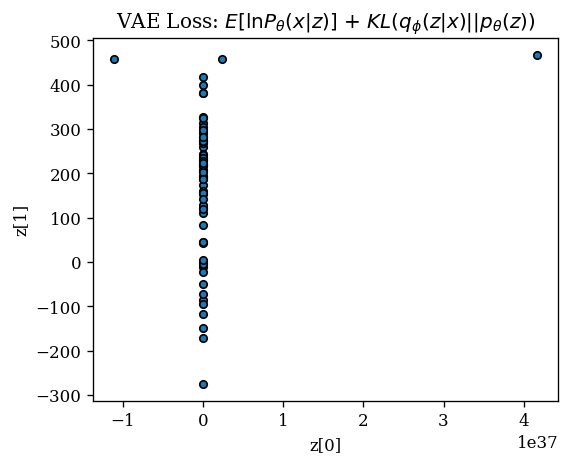

In [96]:
z_mean, z_std, z = model.model.encoder.predict(x_test, batch_size = batch_size)

fig = plt.figure(figsize=(5, 4))
plt.scatter(z[:, 0], z[:, 1], edgecolor="black", s = 20)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
if loss_index == 0:
    plt.title('VAE Loss: $E [\ln P_{\\theta}(x|z)]$ + $KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 1:
    plt.title('$\\beta$-VAE: $E [\ln P_{\\theta}(x|z)]$ + $\\beta KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 2:
    plt.title('ControlVAE: $E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 3:
    plt.title('infoVAE: ($E [\ln P_{\theta}(x|z)] + \\beta KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z_{t+1}, \\hat{z}_t)$ with stepwise $\\hat{z}$')
elif loss_index == 4:
    plt.title('GCVAE: ($1-\\alpha_t- \\beta_t)E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z,\\hat{z}_t)$ with stepwise $\\hat{z}$')


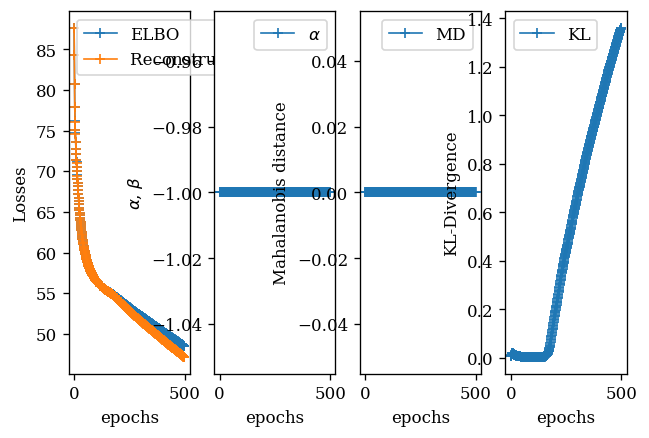

In [97]:
fig, ax = plt.subplots(1, 4)
ax[0].plot(np.arange(model.epoch), model.ELBO, label = 'ELBO', marker = '+', lw = 1.)
ax[0].plot(np.arange(model.epoch), model.RECON_LOSS, label = 'Reconstruction loss', marker = '+', lw = 1.)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Losses')
ax[1].plot(np.arange(model.epoch), model.ALPHA, label = '$\\alpha$', marker = '+', lw = 1.)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('$\\alpha$, $\\beta$')
ax[2].plot(np.arange(model.epoch), model.MMD, label = 'MD', marker = '+', lw = 1.)
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Mahalanobis distance')
ax[3].plot(np.arange(model.epoch), model.KL_DIV, label = 'KL', marker = '+', lw = 1.)
ax[3].set_xlabel('epochs')
ax[3].set_ylabel('KL-Divergence')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

/home/ifeanyi.ezukwoke/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


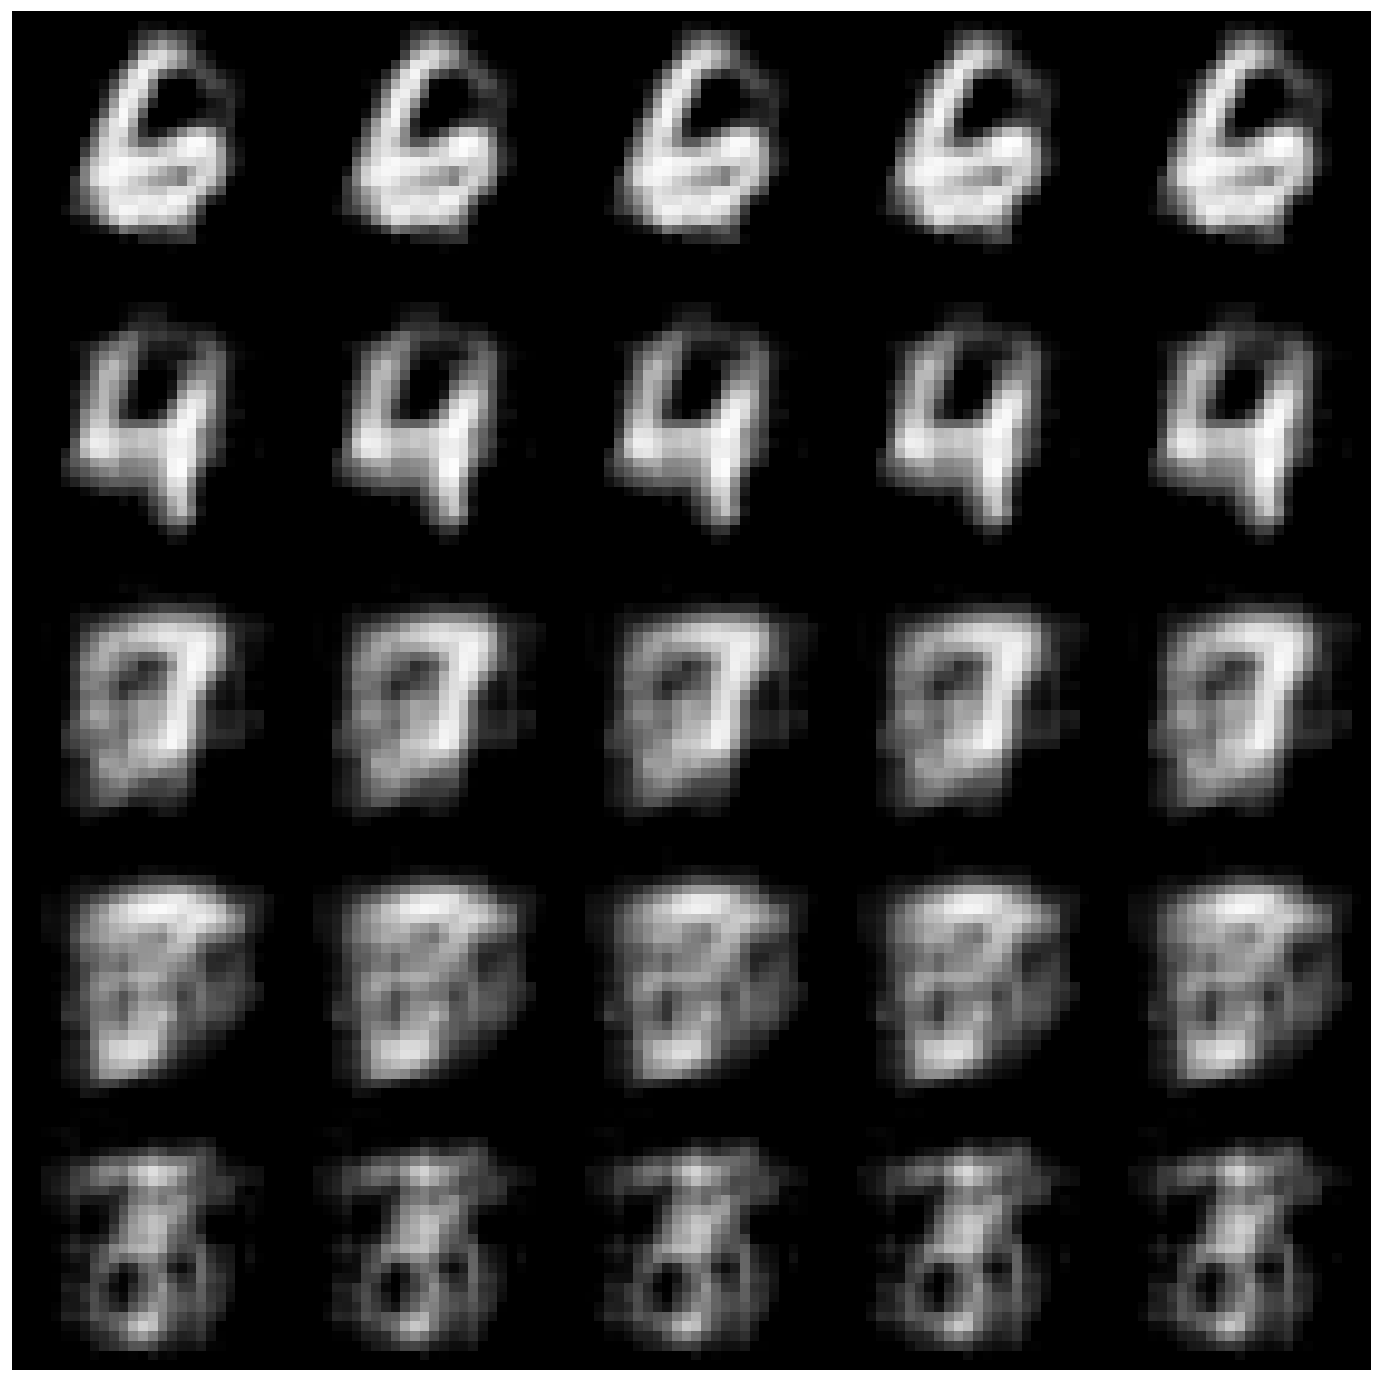

In [98]:
plot_latent_space(model.model, n= 5)

### GCVAE -- MMD

### 500 -iterations

In [99]:
loss_index = 4
# vae_type = 'gcvae' #else infovae
inp_shape =  x_train.shape[1:]
num_features = inp_shape[0]

#the parameters are only to change fixed weights
params = { #beta, gamma
            'elbo': (1, 0),
            'betavae': ((1, 5), 0),
            'controlvae': (0, 0),
            'infovae': (0, 500),
            'gcvae': (1, 1), #not necessarily useful inside algo
    }

lr = 1e-3
epochs = 500
hidden_dim = 100
latent_dims = 2
loss_type = list(params.keys())[loss_index] #elbo -> 0; beta-> 1; controlvae -> 2; infovae -> 3; gcvae -> 4
archi_type = 'v2'
#params
distrib_type = 'g'
beta, gamma = params[f'{loss_type}']
mmd_typ = 'mmd' #['mmd', 'mah', 'mah_rkhs', 'mah_gcvae']
save_model_arg = False
save_model_after = 10
model = gcvae(inp_shape = inp_shape,
                    num_features = num_features,
                    hidden_dim = hidden_dim,
                    latent_dim = latent_dims, 
                    batch_size = batch_size,
                    beta = beta,
                    gamma = gamma,
                    dist = distrib_type,
                    vloss = loss_type,
                    lr = lr, 
                    epochs = epochs,
                    architecture = archi_type,
                    mmd_type = mmd_typ).fit(train_dataset, x_test,
                                            datatype, stopping = False,
                                            save_model = save_model_arg,
                                            save_model_iter = save_model_after)

100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 1 - ELBO: 78.384 - RECON. LOSS: 87.794 - KL: 0.003 - alpha: 0.108 - beta: 0.000 - gamma: 1.049 - mmd: 0.050


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 2 - ELBO: 76.035 - RECON. LOSS: 85.157 - KL: 0.002 - alpha: 0.108 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 3 - ELBO: 73.841 - RECON. LOSS: 82.686 - KL: 0.004 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 4 - ELBO: 71.914 - RECON. LOSS: 80.512 - KL: 0.007 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 5 - ELBO: 70.039 - RECON. LOSS: 78.396 - KL: 0.013 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 6 - ELBO: 68.570 - RECON. LOSS: 76.740 - KL: 0.020 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 7 - ELBO: 67.669 - RECON. LOSS: 75.723 - KL: 0.024 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 8 - ELBO: 67.241 - RECON. LOSS: 75.234 - KL: 0.025 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


epoch 9 - ELBO: 66.422 - RECON. LOSS: 74.311 - KL: 0.024 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 10 - ELBO: 65.570 - RECON. LOSS: 73.352 - KL: 0.023 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


epoch 11 - ELBO: 64.886 - RECON. LOSS: 72.580 - KL: 0.021 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 12 - ELBO: 64.297 - RECON. LOSS: 71.914 - KL: 0.019 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 13 - ELBO: 63.763 - RECON. LOSS: 71.313 - KL: 0.018 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 14 - ELBO: 63.368 - RECON. LOSS: 70.869 - KL: 0.017 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 15 - ELBO: 62.827 - RECON. LOSS: 70.260 - KL: 0.016 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 16 - ELBO: 62.346 - RECON. LOSS: 69.719 - KL: 0.015 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 17 - ELBO: 61.871 - RECON. LOSS: 69.184 - KL: 0.014 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 18 - ELBO: 61.458 - RECON. LOSS: 68.718 - KL: 0.013 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


epoch 19 - ELBO: 60.976 - RECON. LOSS: 68.176 - KL: 0.013 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


epoch 20 - ELBO: 60.588 - RECON. LOSS: 67.738 - KL: 0.012 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 21 - ELBO: 60.257 - RECON. LOSS: 67.365 - KL: 0.012 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 22 - ELBO: 59.899 - RECON. LOSS: 66.962 - KL: 0.011 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 23 - ELBO: 59.563 - RECON. LOSS: 66.584 - KL: 0.011 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 24 - ELBO: 59.228 - RECON. LOSS: 66.208 - KL: 0.010 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 25 - ELBO: 58.894 - RECON. LOSS: 65.831 - KL: 0.010 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 26 - ELBO: 58.598 - RECON. LOSS: 65.498 - KL: 0.010 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 27 - ELBO: 58.274 - RECON. LOSS: 65.134 - KL: 0.009 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 28 - ELBO: 57.971 - RECON. LOSS: 64.793 - KL: 0.009 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 29 - ELBO: 57.676 - RECON. LOSS: 64.460 - KL: 0.009 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


epoch 30 - ELBO: 57.396 - RECON. LOSS: 64.145 - KL: 0.008 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 31 - ELBO: 57.116 - RECON. LOSS: 63.831 - KL: 0.008 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 32 - ELBO: 56.854 - RECON. LOSS: 63.536 - KL: 0.008 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 33 - ELBO: 56.619 - RECON. LOSS: 63.271 - KL: 0.008 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


epoch 34 - ELBO: 56.388 - RECON. LOSS: 63.011 - KL: 0.007 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


epoch 35 - ELBO: 56.180 - RECON. LOSS: 62.777 - KL: 0.007 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 36 - ELBO: 55.971 - RECON. LOSS: 62.542 - KL: 0.007 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


epoch 37 - ELBO: 55.779 - RECON. LOSS: 62.325 - KL: 0.007 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 38 - ELBO: 55.584 - RECON. LOSS: 62.106 - KL: 0.007 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 39 - ELBO: 55.403 - RECON. LOSS: 61.901 - KL: 0.007 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 40 - ELBO: 55.238 - RECON. LOSS: 61.715 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


epoch 41 - ELBO: 55.075 - RECON. LOSS: 61.532 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 42 - ELBO: 54.915 - RECON. LOSS: 61.352 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 43 - ELBO: 54.767 - RECON. LOSS: 61.186 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 44 - ELBO: 54.612 - RECON. LOSS: 61.012 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


epoch 45 - ELBO: 54.474 - RECON. LOSS: 60.857 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


epoch 46 - ELBO: 54.335 - RECON. LOSS: 60.699 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 47 - ELBO: 54.197 - RECON. LOSS: 60.545 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


epoch 48 - ELBO: 54.072 - RECON. LOSS: 60.404 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 49 - ELBO: 53.948 - RECON. LOSS: 60.265 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 50 - ELBO: 53.829 - RECON. LOSS: 60.130 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 51 - ELBO: 53.709 - RECON. LOSS: 59.996 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 52 - ELBO: 53.600 - RECON. LOSS: 59.873 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 53 - ELBO: 53.497 - RECON. LOSS: 59.757 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


epoch 54 - ELBO: 53.390 - RECON. LOSS: 59.637 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 55 - ELBO: 53.290 - RECON. LOSS: 59.525 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 56 - ELBO: 53.191 - RECON. LOSS: 59.414 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 57 - ELBO: 53.098 - RECON. LOSS: 59.309 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 58 - ELBO: 53.002 - RECON. LOSS: 59.201 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 59 - ELBO: 52.912 - RECON. LOSS: 59.100 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


epoch 60 - ELBO: 52.825 - RECON. LOSS: 59.002 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 61 - ELBO: 52.739 - RECON. LOSS: 58.905 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 62 - ELBO: 52.656 - RECON. LOSS: 58.811 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 63 - ELBO: 52.577 - RECON. LOSS: 58.723 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 64 - ELBO: 52.499 - RECON. LOSS: 58.634 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 65 - ELBO: 52.427 - RECON. LOSS: 58.554 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 66 - ELBO: 52.353 - RECON. LOSS: 58.471 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 67 - ELBO: 52.282 - RECON. LOSS: 58.391 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 68 - ELBO: 52.214 - RECON. LOSS: 58.314 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 69 - ELBO: 52.146 - RECON. LOSS: 58.238 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 70 - ELBO: 52.083 - RECON. LOSS: 58.166 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 71 - ELBO: 52.014 - RECON. LOSS: 58.089 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 72 - ELBO: 51.954 - RECON. LOSS: 58.022 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 73 - ELBO: 51.894 - RECON. LOSS: 57.955 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 74 - ELBO: 51.836 - RECON. LOSS: 57.889 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


epoch 75 - ELBO: 51.779 - RECON. LOSS: 57.825 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


epoch 76 - ELBO: 51.722 - RECON. LOSS: 57.760 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 77 - ELBO: 51.667 - RECON. LOSS: 57.699 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 78 - ELBO: 51.613 - RECON. LOSS: 57.638 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 79 - ELBO: 51.563 - RECON. LOSS: 57.581 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


epoch 80 - ELBO: 51.515 - RECON. LOSS: 57.528 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


epoch 81 - ELBO: 51.469 - RECON. LOSS: 57.476 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 82 - ELBO: 51.420 - RECON. LOSS: 57.421 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 83 - ELBO: 51.377 - RECON. LOSS: 57.372 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 84 - ELBO: 51.331 - RECON. LOSS: 57.320 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 85 - ELBO: 51.283 - RECON. LOSS: 57.267 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 86 - ELBO: 51.236 - RECON. LOSS: 57.214 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 87 - ELBO: 51.191 - RECON. LOSS: 57.164 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 88 - ELBO: 51.147 - RECON. LOSS: 57.114 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 89 - ELBO: 51.107 - RECON. LOSS: 57.070 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


epoch 90 - ELBO: 51.068 - RECON. LOSS: 57.025 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 91 - ELBO: 51.029 - RECON. LOSS: 56.981 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 92 - ELBO: 50.990 - RECON. LOSS: 56.938 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 93 - ELBO: 50.951 - RECON. LOSS: 56.894 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


epoch 94 - ELBO: 50.914 - RECON. LOSS: 56.852 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 95 - ELBO: 50.877 - RECON. LOSS: 56.810 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 96 - ELBO: 50.843 - RECON. LOSS: 56.772 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 97 - ELBO: 50.810 - RECON. LOSS: 56.735 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 98 - ELBO: 50.775 - RECON. LOSS: 56.696 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 99 - ELBO: 50.741 - RECON. LOSS: 56.658 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 100 - ELBO: 50.708 - RECON. LOSS: 56.620 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 101 - ELBO: 50.674 - RECON. LOSS: 56.582 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 102 - ELBO: 50.641 - RECON. LOSS: 56.546 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 103 - ELBO: 50.609 - RECON. LOSS: 56.509 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 104 - ELBO: 50.577 - RECON. LOSS: 56.474 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 105 - ELBO: 50.547 - RECON. LOSS: 56.439 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 106 - ELBO: 50.518 - RECON. LOSS: 56.407 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 107 - ELBO: 50.486 - RECON. LOSS: 56.371 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 108 - ELBO: 50.458 - RECON. LOSS: 56.339 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 109 - ELBO: 50.428 - RECON. LOSS: 56.305 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 110 - ELBO: 50.401 - RECON. LOSS: 56.275 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 111 - ELBO: 50.373 - RECON. LOSS: 56.244 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 112 - ELBO: 50.344 - RECON. LOSS: 56.211 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 113 - ELBO: 50.317 - RECON. LOSS: 56.180 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 114 - ELBO: 50.290 - RECON. LOSS: 56.150 - KL: 0.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 115 - ELBO: 50.264 - RECON. LOSS: 56.121 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 116 - ELBO: 50.238 - RECON. LOSS: 56.092 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 117 - ELBO: 50.213 - RECON. LOSS: 56.064 - KL: 0.005 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 118 - ELBO: 50.188 - RECON. LOSS: 56.036 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 119 - ELBO: 50.164 - RECON. LOSS: 56.008 - KL: 0.006 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 120 - ELBO: 50.138 - RECON. LOSS: 55.979 - KL: 0.007 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 121 - ELBO: 50.113 - RECON. LOSS: 55.951 - KL: 0.007 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 122 - ELBO: 50.091 - RECON. LOSS: 55.925 - KL: 0.008 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 123 - ELBO: 50.063 - RECON. LOSS: 55.894 - KL: 0.009 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 124 - ELBO: 50.039 - RECON. LOSS: 55.867 - KL: 0.010 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 125 - ELBO: 50.011 - RECON. LOSS: 55.835 - KL: 0.012 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 126 - ELBO: 49.987 - RECON. LOSS: 55.808 - KL: 0.017 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 127 - ELBO: 49.960 - RECON. LOSS: 55.777 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 128 - ELBO: 49.935 - RECON. LOSS: 55.750 - KL: 0.025 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 129 - ELBO: 49.909 - RECON. LOSS: 55.720 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 130 - ELBO: 49.887 - RECON. LOSS: 55.694 - KL: 0.037 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


epoch 131 - ELBO: 49.861 - RECON. LOSS: 55.665 - KL: 0.043 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


epoch 132 - ELBO: 49.835 - RECON. LOSS: 55.635 - KL: 0.048 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 133 - ELBO: 49.810 - RECON. LOSS: 55.606 - KL: 0.061 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 134 - ELBO: 49.778 - RECON. LOSS: 55.570 - KL: 0.075 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 135 - ELBO: 49.750 - RECON. LOSS: 55.537 - KL: 0.083 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 136 - ELBO: 49.717 - RECON. LOSS: 55.500 - KL: 0.094 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 137 - ELBO: 49.693 - RECON. LOSS: 55.472 - KL: 0.112 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 138 - ELBO: 49.665 - RECON. LOSS: 55.439 - KL: 0.122 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


epoch 139 - ELBO: 49.641 - RECON. LOSS: 55.412 - KL: 0.132 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 140 - ELBO: 49.607 - RECON. LOSS: 55.373 - KL: 0.146 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 141 - ELBO: 49.580 - RECON. LOSS: 55.341 - KL: 0.169 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.026


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 142 - ELBO: 49.543 - RECON. LOSS: 55.299 - KL: 0.190 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.027


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 143 - ELBO: 49.511 - RECON. LOSS: 55.261 - KL: 0.207 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 144 - ELBO: 49.483 - RECON. LOSS: 55.228 - KL: 0.225 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 145 - ELBO: 49.446 - RECON. LOSS: 55.185 - KL: 0.251 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 146 - ELBO: 49.418 - RECON. LOSS: 55.151 - KL: 0.283 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 147 - ELBO: 49.378 - RECON. LOSS: 55.105 - KL: 0.306 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 148 - ELBO: 49.348 - RECON. LOSS: 55.070 - KL: 0.325 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 149 - ELBO: 49.311 - RECON. LOSS: 55.027 - KL: 0.349 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


epoch 150 - ELBO: 49.273 - RECON. LOSS: 54.983 - KL: 0.382 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


epoch 151 - ELBO: 49.239 - RECON. LOSS: 54.943 - KL: 0.415 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 152 - ELBO: 49.199 - RECON. LOSS: 54.896 - KL: 0.440 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 153 - ELBO: 49.166 - RECON. LOSS: 54.858 - KL: 0.464 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.042


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 154 - ELBO: 49.126 - RECON. LOSS: 54.810 - KL: 0.493 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.043


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 155 - ELBO: 49.089 - RECON. LOSS: 54.767 - KL: 0.531 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.045


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 156 - ELBO: 49.048 - RECON. LOSS: 54.719 - KL: 0.564 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.047


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 157 - ELBO: 49.012 - RECON. LOSS: 54.676 - KL: 0.592 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.049


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 158 - ELBO: 48.974 - RECON. LOSS: 54.631 - KL: 0.623 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.051


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 159 - ELBO: 48.937 - RECON. LOSS: 54.587 - KL: 0.667 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 160 - ELBO: 48.899 - RECON. LOSS: 54.542 - KL: 0.711 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.055


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 161 - ELBO: 48.860 - RECON. LOSS: 54.496 - KL: 0.746 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.056


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 162 - ELBO: 48.822 - RECON. LOSS: 54.452 - KL: 0.778 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.058


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 163 - ELBO: 48.781 - RECON. LOSS: 54.404 - KL: 0.814 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 164 - ELBO: 48.744 - RECON. LOSS: 54.360 - KL: 0.852 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.062


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 165 - ELBO: 48.705 - RECON. LOSS: 54.314 - KL: 0.884 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 166 - ELBO: 48.668 - RECON. LOSS: 54.271 - KL: 0.916 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 167 - ELBO: 48.628 - RECON. LOSS: 54.223 - KL: 0.953 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 168 - ELBO: 48.590 - RECON. LOSS: 54.179 - KL: 0.996 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 169 - ELBO: 48.551 - RECON. LOSS: 54.133 - KL: 1.035 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 170 - ELBO: 48.513 - RECON. LOSS: 54.088 - KL: 1.069 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 171 - ELBO: 48.474 - RECON. LOSS: 54.043 - KL: 1.104 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 172 - ELBO: 48.436 - RECON. LOSS: 53.998 - KL: 1.144 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 173 - ELBO: 48.398 - RECON. LOSS: 53.953 - KL: 1.180 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 174 - ELBO: 48.359 - RECON. LOSS: 53.908 - KL: 1.216 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 175 - ELBO: 48.320 - RECON. LOSS: 53.862 - KL: 1.254 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 176 - ELBO: 48.283 - RECON. LOSS: 53.817 - KL: 1.292 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 177 - ELBO: 48.243 - RECON. LOSS: 53.771 - KL: 1.327 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 178 - ELBO: 48.206 - RECON. LOSS: 53.727 - KL: 1.361 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 179 - ELBO: 48.167 - RECON. LOSS: 53.681 - KL: 1.397 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.087


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 180 - ELBO: 48.128 - RECON. LOSS: 53.637 - KL: 1.434 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 181 - ELBO: 48.090 - RECON. LOSS: 53.592 - KL: 1.469 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 182 - ELBO: 48.052 - RECON. LOSS: 53.548 - KL: 1.505 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 183 - ELBO: 48.014 - RECON. LOSS: 53.503 - KL: 1.541 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 184 - ELBO: 47.976 - RECON. LOSS: 53.459 - KL: 1.574 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


epoch 185 - ELBO: 47.938 - RECON. LOSS: 53.415 - KL: 1.606 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


epoch 186 - ELBO: 47.900 - RECON. LOSS: 53.370 - KL: 1.640 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 187 - ELBO: 47.862 - RECON. LOSS: 53.326 - KL: 1.675 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 188 - ELBO: 47.824 - RECON. LOSS: 53.281 - KL: 1.708 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


epoch 189 - ELBO: 47.785 - RECON. LOSS: 53.237 - KL: 1.742 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.101


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 190 - ELBO: 47.748 - RECON. LOSS: 53.193 - KL: 1.775 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.102


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


epoch 191 - ELBO: 47.711 - RECON. LOSS: 53.149 - KL: 1.808 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.104


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 192 - ELBO: 47.672 - RECON. LOSS: 53.104 - KL: 1.843 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.105


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 193 - ELBO: 47.633 - RECON. LOSS: 53.059 - KL: 1.878 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.107


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 194 - ELBO: 47.594 - RECON. LOSS: 53.014 - KL: 1.911 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.108


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 195 - ELBO: 47.556 - RECON. LOSS: 52.969 - KL: 1.944 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.109


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 196 - ELBO: 47.518 - RECON. LOSS: 52.925 - KL: 1.976 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.110


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 197 - ELBO: 47.479 - RECON. LOSS: 52.881 - KL: 2.010 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.111


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 198 - ELBO: 47.441 - RECON. LOSS: 52.837 - KL: 2.044 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.113


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 199 - ELBO: 47.402 - RECON. LOSS: 52.792 - KL: 2.078 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.114


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 200 - ELBO: 47.363 - RECON. LOSS: 52.746 - KL: 2.113 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.115


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 201 - ELBO: 47.324 - RECON. LOSS: 52.701 - KL: 2.147 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.116


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 202 - ELBO: 47.285 - RECON. LOSS: 52.656 - KL: 2.181 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.117


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 203 - ELBO: 47.245 - RECON. LOSS: 52.610 - KL: 2.215 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.118


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 204 - ELBO: 47.207 - RECON. LOSS: 52.566 - KL: 2.245 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.119


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


epoch 205 - ELBO: 47.168 - RECON. LOSS: 52.521 - KL: 2.281 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.121


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 206 - ELBO: 47.129 - RECON. LOSS: 52.475 - KL: 2.312 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 207 - ELBO: 47.089 - RECON. LOSS: 52.429 - KL: 2.347 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.123


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 208 - ELBO: 47.049 - RECON. LOSS: 52.383 - KL: 2.382 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.124


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 209 - ELBO: 47.010 - RECON. LOSS: 52.338 - KL: 2.413 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


epoch 210 - ELBO: 46.973 - RECON. LOSS: 52.294 - KL: 2.451 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.126


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 211 - ELBO: 46.933 - RECON. LOSS: 52.249 - KL: 2.482 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


epoch 212 - ELBO: 46.891 - RECON. LOSS: 52.201 - KL: 2.516 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.128


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 213 - ELBO: 46.851 - RECON. LOSS: 52.155 - KL: 2.553 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.129


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


epoch 214 - ELBO: 46.812 - RECON. LOSS: 52.110 - KL: 2.585 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.130


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 215 - ELBO: 46.771 - RECON. LOSS: 52.064 - KL: 2.623 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


epoch 216 - ELBO: 46.729 - RECON. LOSS: 52.015 - KL: 2.657 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 217 - ELBO: 46.689 - RECON. LOSS: 51.970 - KL: 2.688 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.132


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 218 - ELBO: 46.652 - RECON. LOSS: 51.927 - KL: 2.728 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.133


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 219 - ELBO: 46.612 - RECON. LOSS: 51.881 - KL: 2.760 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.134


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 220 - ELBO: 46.571 - RECON. LOSS: 51.834 - KL: 2.792 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 221 - ELBO: 46.533 - RECON. LOSS: 51.790 - KL: 2.829 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 222 - ELBO: 46.497 - RECON. LOSS: 51.749 - KL: 2.858 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.136


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 223 - ELBO: 46.455 - RECON. LOSS: 51.701 - KL: 2.892 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


epoch 224 - ELBO: 46.415 - RECON. LOSS: 51.656 - KL: 2.927 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


epoch 225 - ELBO: 46.376 - RECON. LOSS: 51.611 - KL: 2.956 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 226 - ELBO: 46.334 - RECON. LOSS: 51.563 - KL: 2.992 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 227 - ELBO: 46.293 - RECON. LOSS: 51.516 - KL: 3.029 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 228 - ELBO: 46.252 - RECON. LOSS: 51.470 - KL: 3.059 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 229 - ELBO: 46.209 - RECON. LOSS: 51.421 - KL: 3.093 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 230 - ELBO: 46.166 - RECON. LOSS: 51.372 - KL: 3.129 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 231 - ELBO: 46.124 - RECON. LOSS: 51.324 - KL: 3.163 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.142


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 232 - ELBO: 46.081 - RECON. LOSS: 51.274 - KL: 3.195 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 233 - ELBO: 46.038 - RECON. LOSS: 51.226 - KL: 3.229 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 234 - ELBO: 45.995 - RECON. LOSS: 51.177 - KL: 3.261 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 235 - ELBO: 45.951 - RECON. LOSS: 51.127 - KL: 3.295 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 236 - ELBO: 45.908 - RECON. LOSS: 51.078 - KL: 3.329 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 237 - ELBO: 45.863 - RECON. LOSS: 51.028 - KL: 3.362 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 238 - ELBO: 45.819 - RECON. LOSS: 50.977 - KL: 3.395 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 239 - ELBO: 45.774 - RECON. LOSS: 50.927 - KL: 3.429 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 240 - ELBO: 45.729 - RECON. LOSS: 50.876 - KL: 3.462 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 241 - ELBO: 45.684 - RECON. LOSS: 50.825 - KL: 3.495 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


epoch 242 - ELBO: 45.639 - RECON. LOSS: 50.773 - KL: 3.529 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 243 - ELBO: 45.594 - RECON. LOSS: 50.722 - KL: 3.563 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 244 - ELBO: 45.549 - RECON. LOSS: 50.671 - KL: 3.596 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 245 - ELBO: 45.503 - RECON. LOSS: 50.619 - KL: 3.631 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 246 - ELBO: 45.458 - RECON. LOSS: 50.568 - KL: 3.663 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 247 - ELBO: 45.414 - RECON. LOSS: 50.518 - KL: 3.700 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 248 - ELBO: 45.374 - RECON. LOSS: 50.473 - KL: 3.731 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 249 - ELBO: 45.332 - RECON. LOSS: 50.426 - KL: 3.769 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


epoch 250 - ELBO: 45.287 - RECON. LOSS: 50.375 - KL: 3.802 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 251 - ELBO: 45.243 - RECON. LOSS: 50.324 - KL: 3.836 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 252 - ELBO: 45.197 - RECON. LOSS: 50.273 - KL: 3.871 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 253 - ELBO: 45.154 - RECON. LOSS: 50.224 - KL: 3.903 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 254 - ELBO: 45.110 - RECON. LOSS: 50.174 - KL: 3.939 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 255 - ELBO: 45.063 - RECON. LOSS: 50.122 - KL: 3.973 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 256 - ELBO: 45.017 - RECON. LOSS: 50.070 - KL: 4.007 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 257 - ELBO: 44.973 - RECON. LOSS: 50.020 - KL: 4.044 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


epoch 258 - ELBO: 44.928 - RECON. LOSS: 49.969 - KL: 4.077 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 259 - ELBO: 44.882 - RECON. LOSS: 49.917 - KL: 4.113 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 260 - ELBO: 44.836 - RECON. LOSS: 49.865 - KL: 4.148 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 261 - ELBO: 44.790 - RECON. LOSS: 49.814 - KL: 4.182 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 262 - ELBO: 44.744 - RECON. LOSS: 49.762 - KL: 4.218 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 263 - ELBO: 44.698 - RECON. LOSS: 49.710 - KL: 4.252 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 264 - ELBO: 44.654 - RECON. LOSS: 49.660 - KL: 4.289 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


epoch 265 - ELBO: 44.611 - RECON. LOSS: 49.611 - KL: 4.323 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 266 - ELBO: 44.569 - RECON. LOSS: 49.564 - KL: 4.362 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 267 - ELBO: 44.528 - RECON. LOSS: 49.517 - KL: 4.394 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 268 - ELBO: 44.483 - RECON. LOSS: 49.467 - KL: 4.430 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 269 - ELBO: 44.437 - RECON. LOSS: 49.415 - KL: 4.466 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 270 - ELBO: 44.393 - RECON. LOSS: 49.366 - KL: 4.498 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 271 - ELBO: 44.351 - RECON. LOSS: 49.318 - KL: 4.536 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 272 - ELBO: 44.306 - RECON. LOSS: 49.268 - KL: 4.569 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 273 - ELBO: 44.260 - RECON. LOSS: 49.216 - KL: 4.603 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 274 - ELBO: 44.216 - RECON. LOSS: 49.167 - KL: 4.640 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 275 - ELBO: 44.174 - RECON. LOSS: 49.118 - KL: 4.673 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 276 - ELBO: 44.129 - RECON. LOSS: 49.067 - KL: 4.709 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 277 - ELBO: 44.083 - RECON. LOSS: 49.016 - KL: 4.745 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 278 - ELBO: 44.040 - RECON. LOSS: 48.968 - KL: 4.777 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 279 - ELBO: 43.997 - RECON. LOSS: 48.919 - KL: 4.814 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 280 - ELBO: 43.952 - RECON. LOSS: 48.869 - KL: 4.847 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 281 - ELBO: 43.907 - RECON. LOSS: 48.818 - KL: 4.881 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 282 - ELBO: 43.863 - RECON. LOSS: 48.768 - KL: 4.917 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 283 - ELBO: 43.820 - RECON. LOSS: 48.720 - KL: 4.950 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 284 - ELBO: 43.775 - RECON. LOSS: 48.669 - KL: 4.985 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


epoch 285 - ELBO: 43.730 - RECON. LOSS: 48.618 - KL: 5.020 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 286 - ELBO: 43.685 - RECON. LOSS: 48.568 - KL: 5.054 - alpha: 0.104 - beta: 0.000 - gamma: 1.051 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 287 - ELBO: 43.641 - RECON. LOSS: 48.518 - KL: 5.091 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 288 - ELBO: 43.597 - RECON. LOSS: 48.469 - KL: 5.124 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 289 - ELBO: 43.553 - RECON. LOSS: 48.418 - KL: 5.160 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 290 - ELBO: 43.507 - RECON. LOSS: 48.367 - KL: 5.194 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 291 - ELBO: 43.462 - RECON. LOSS: 48.317 - KL: 5.229 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 292 - ELBO: 43.417 - RECON. LOSS: 48.266 - KL: 5.265 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 293 - ELBO: 43.373 - RECON. LOSS: 48.215 - KL: 5.298 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 294 - ELBO: 43.328 - RECON. LOSS: 48.165 - KL: 5.334 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 295 - ELBO: 43.283 - RECON. LOSS: 48.114 - KL: 5.368 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 296 - ELBO: 43.239 - RECON. LOSS: 48.064 - KL: 5.403 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 297 - ELBO: 43.195 - RECON. LOSS: 48.015 - KL: 5.437 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 298 - ELBO: 43.152 - RECON. LOSS: 47.966 - KL: 5.472 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 299 - ELBO: 43.108 - RECON. LOSS: 47.917 - KL: 5.506 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 300 - ELBO: 43.064 - RECON. LOSS: 47.867 - KL: 5.542 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 301 - ELBO: 43.023 - RECON. LOSS: 47.821 - KL: 5.574 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 302 - ELBO: 42.989 - RECON. LOSS: 47.783 - KL: 5.612 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 303 - ELBO: 42.951 - RECON. LOSS: 47.740 - KL: 5.643 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 304 - ELBO: 42.909 - RECON. LOSS: 47.693 - KL: 5.679 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 305 - ELBO: 42.868 - RECON. LOSS: 47.646 - KL: 5.712 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 306 - ELBO: 42.826 - RECON. LOSS: 47.599 - KL: 5.744 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 307 - ELBO: 42.783 - RECON. LOSS: 47.550 - KL: 5.777 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 308 - ELBO: 42.742 - RECON. LOSS: 47.504 - KL: 5.811 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 309 - ELBO: 42.700 - RECON. LOSS: 47.456 - KL: 5.844 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 310 - ELBO: 42.656 - RECON. LOSS: 47.407 - KL: 5.877 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 311 - ELBO: 42.615 - RECON. LOSS: 47.361 - KL: 5.910 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 312 - ELBO: 42.572 - RECON. LOSS: 47.313 - KL: 5.943 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 313 - ELBO: 42.530 - RECON. LOSS: 47.265 - KL: 5.975 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 314 - ELBO: 42.489 - RECON. LOSS: 47.219 - KL: 6.008 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 315 - ELBO: 42.446 - RECON. LOSS: 47.170 - KL: 6.040 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.168


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


epoch 316 - ELBO: 42.403 - RECON. LOSS: 47.122 - KL: 6.072 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.168


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


epoch 317 - ELBO: 42.361 - RECON. LOSS: 47.075 - KL: 6.104 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.168


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


epoch 318 - ELBO: 42.318 - RECON. LOSS: 47.026 - KL: 6.136 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.168


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


epoch 319 - ELBO: 42.275 - RECON. LOSS: 46.977 - KL: 6.168 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.169


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


epoch 320 - ELBO: 42.233 - RECON. LOSS: 46.929 - KL: 6.201 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.169


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 321 - ELBO: 42.190 - RECON. LOSS: 46.881 - KL: 6.232 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.169


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 322 - ELBO: 42.147 - RECON. LOSS: 46.833 - KL: 6.265 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.170


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 323 - ELBO: 42.107 - RECON. LOSS: 46.788 - KL: 6.297 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.170


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 324 - ELBO: 42.067 - RECON. LOSS: 46.743 - KL: 6.331 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.170


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 325 - ELBO: 42.034 - RECON. LOSS: 46.705 - KL: 6.360 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.170


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 326 - ELBO: 42.005 - RECON. LOSS: 46.673 - KL: 6.396 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.171


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


epoch 327 - ELBO: 41.966 - RECON. LOSS: 46.628 - KL: 6.425 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.171


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


epoch 328 - ELBO: 41.925 - RECON. LOSS: 46.582 - KL: 6.455 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.171


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 329 - ELBO: 41.890 - RECON. LOSS: 46.542 - KL: 6.488 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.171


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 330 - ELBO: 41.850 - RECON. LOSS: 46.498 - KL: 6.517 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.171


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 331 - ELBO: 41.812 - RECON. LOSS: 46.455 - KL: 6.546 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.172


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 332 - ELBO: 41.774 - RECON. LOSS: 46.412 - KL: 6.579 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.172


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 333 - ELBO: 41.736 - RECON. LOSS: 46.370 - KL: 6.609 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.172


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 334 - ELBO: 41.698 - RECON. LOSS: 46.327 - KL: 6.638 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.172


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 335 - ELBO: 41.660 - RECON. LOSS: 46.284 - KL: 6.670 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.172


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 336 - ELBO: 41.624 - RECON. LOSS: 46.243 - KL: 6.699 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.173


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 337 - ELBO: 41.583 - RECON. LOSS: 46.197 - KL: 6.728 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.173


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 338 - ELBO: 41.547 - RECON. LOSS: 46.156 - KL: 6.759 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.173


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


epoch 339 - ELBO: 41.509 - RECON. LOSS: 46.114 - KL: 6.787 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.173


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 340 - ELBO: 41.469 - RECON. LOSS: 46.069 - KL: 6.817 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.173


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 341 - ELBO: 41.432 - RECON. LOSS: 46.027 - KL: 6.847 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.173


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 342 - ELBO: 41.394 - RECON. LOSS: 45.984 - KL: 6.875 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.174


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 343 - ELBO: 41.355 - RECON. LOSS: 45.940 - KL: 6.904 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.174


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 344 - ELBO: 41.315 - RECON. LOSS: 45.896 - KL: 6.933 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.174


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 345 - ELBO: 41.277 - RECON. LOSS: 45.853 - KL: 6.961 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.174


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 346 - ELBO: 41.238 - RECON. LOSS: 45.808 - KL: 6.990 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.175


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 347 - ELBO: 41.198 - RECON. LOSS: 45.764 - KL: 7.019 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.175


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 348 - ELBO: 41.158 - RECON. LOSS: 45.719 - KL: 7.046 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.175


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 349 - ELBO: 41.118 - RECON. LOSS: 45.674 - KL: 7.075 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.175


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 350 - ELBO: 41.078 - RECON. LOSS: 45.629 - KL: 7.103 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.175


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 351 - ELBO: 41.038 - RECON. LOSS: 45.583 - KL: 7.132 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.176


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 352 - ELBO: 40.998 - RECON. LOSS: 45.538 - KL: 7.160 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.176


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 353 - ELBO: 40.957 - RECON. LOSS: 45.493 - KL: 7.188 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.176


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 354 - ELBO: 40.917 - RECON. LOSS: 45.448 - KL: 7.216 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.176


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 355 - ELBO: 40.877 - RECON. LOSS: 45.402 - KL: 7.244 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.176


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 356 - ELBO: 40.836 - RECON. LOSS: 45.357 - KL: 7.272 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.176


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 357 - ELBO: 40.796 - RECON. LOSS: 45.312 - KL: 7.300 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.176


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 358 - ELBO: 40.756 - RECON. LOSS: 45.266 - KL: 7.329 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.177


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 359 - ELBO: 40.716 - RECON. LOSS: 45.221 - KL: 7.356 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.177


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 360 - ELBO: 40.676 - RECON. LOSS: 45.176 - KL: 7.385 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.177


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 361 - ELBO: 40.636 - RECON. LOSS: 45.131 - KL: 7.412 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.177


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 362 - ELBO: 40.599 - RECON. LOSS: 45.089 - KL: 7.442 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.177


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 363 - ELBO: 40.563 - RECON. LOSS: 45.049 - KL: 7.468 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.178


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 364 - ELBO: 40.530 - RECON. LOSS: 45.011 - KL: 7.498 - alpha: 0.104 - beta: 0.000 - gamma: 1.052 - mmd: 0.178


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 365 - ELBO: 40.495 - RECON. LOSS: 44.972 - KL: 7.524 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.178


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 366 - ELBO: 40.456 - RECON. LOSS: 44.928 - KL: 7.553 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.178


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 367 - ELBO: 40.417 - RECON. LOSS: 44.884 - KL: 7.581 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.179


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 368 - ELBO: 40.379 - RECON. LOSS: 44.841 - KL: 7.607 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.179


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 369 - ELBO: 40.343 - RECON. LOSS: 44.800 - KL: 7.637 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.179


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 370 - ELBO: 40.305 - RECON. LOSS: 44.758 - KL: 7.663 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.179


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 371 - ELBO: 40.265 - RECON. LOSS: 44.713 - KL: 7.690 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.179


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 372 - ELBO: 40.227 - RECON. LOSS: 44.670 - KL: 7.718 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.180


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 373 - ELBO: 40.191 - RECON. LOSS: 44.630 - KL: 7.744 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.180


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 374 - ELBO: 40.154 - RECON. LOSS: 44.588 - KL: 7.773 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.180


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 375 - ELBO: 40.116 - RECON. LOSS: 44.545 - KL: 7.798 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.180


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 376 - ELBO: 40.077 - RECON. LOSS: 44.501 - KL: 7.824 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.180


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 377 - ELBO: 40.039 - RECON. LOSS: 44.459 - KL: 7.852 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.181


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 378 - ELBO: 40.002 - RECON. LOSS: 44.417 - KL: 7.878 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.181


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 379 - ELBO: 39.964 - RECON. LOSS: 44.375 - KL: 7.905 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.181


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 380 - ELBO: 39.926 - RECON. LOSS: 44.331 - KL: 7.931 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.181


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


epoch 381 - ELBO: 39.887 - RECON. LOSS: 44.287 - KL: 7.957 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.181


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 382 - ELBO: 39.849 - RECON. LOSS: 44.245 - KL: 7.985 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.182


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 383 - ELBO: 39.811 - RECON. LOSS: 44.202 - KL: 8.011 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.182


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 384 - ELBO: 39.773 - RECON. LOSS: 44.159 - KL: 8.038 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.182


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 385 - ELBO: 39.734 - RECON. LOSS: 44.116 - KL: 8.065 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.182


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 386 - ELBO: 39.695 - RECON. LOSS: 44.072 - KL: 8.091 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.182


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 387 - ELBO: 39.658 - RECON. LOSS: 44.029 - KL: 8.118 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.182


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


epoch 388 - ELBO: 39.620 - RECON. LOSS: 43.987 - KL: 8.143 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.183


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


epoch 389 - ELBO: 39.584 - RECON. LOSS: 43.947 - KL: 8.172 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.183


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 390 - ELBO: 39.548 - RECON. LOSS: 43.906 - KL: 8.197 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.183


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


epoch 391 - ELBO: 39.512 - RECON. LOSS: 43.866 - KL: 8.224 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.183


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


epoch 392 - ELBO: 39.476 - RECON. LOSS: 43.824 - KL: 8.250 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.183


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 393 - ELBO: 39.437 - RECON. LOSS: 43.781 - KL: 8.276 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.183


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


epoch 394 - ELBO: 39.399 - RECON. LOSS: 43.738 - KL: 8.302 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.184


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


epoch 395 - ELBO: 39.361 - RECON. LOSS: 43.696 - KL: 8.328 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.184


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


epoch 396 - ELBO: 39.324 - RECON. LOSS: 43.654 - KL: 8.354 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.184


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 397 - ELBO: 39.286 - RECON. LOSS: 43.611 - KL: 8.380 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.184


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 398 - ELBO: 39.248 - RECON. LOSS: 43.568 - KL: 8.406 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.185


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


epoch 399 - ELBO: 39.209 - RECON. LOSS: 43.524 - KL: 8.432 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.185


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


epoch 400 - ELBO: 39.172 - RECON. LOSS: 43.482 - KL: 8.457 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.185


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 401 - ELBO: 39.135 - RECON. LOSS: 43.441 - KL: 8.484 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.185


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


epoch 402 - ELBO: 39.102 - RECON. LOSS: 43.404 - KL: 8.508 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.185


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 403 - ELBO: 39.073 - RECON. LOSS: 43.371 - KL: 8.537 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.185


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 404 - ELBO: 39.041 - RECON. LOSS: 43.335 - KL: 8.561 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.186


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 405 - ELBO: 39.005 - RECON. LOSS: 43.295 - KL: 8.587 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.186


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 406 - ELBO: 38.967 - RECON. LOSS: 43.252 - KL: 8.613 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.186


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 407 - ELBO: 38.932 - RECON. LOSS: 43.212 - KL: 8.637 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.186


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 408 - ELBO: 38.899 - RECON. LOSS: 43.175 - KL: 8.665 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.186


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 409 - ELBO: 38.863 - RECON. LOSS: 43.135 - KL: 8.689 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.187


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 410 - ELBO: 38.825 - RECON. LOSS: 43.093 - KL: 8.714 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.187


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 411 - ELBO: 38.790 - RECON. LOSS: 43.053 - KL: 8.741 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.187


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 412 - ELBO: 38.754 - RECON. LOSS: 43.012 - KL: 8.766 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.187


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 413 - ELBO: 38.716 - RECON. LOSS: 42.970 - KL: 8.792 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.187


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 414 - ELBO: 38.680 - RECON. LOSS: 42.929 - KL: 8.817 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.188


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 415 - ELBO: 38.644 - RECON. LOSS: 42.889 - KL: 8.842 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.188


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


epoch 416 - ELBO: 38.608 - RECON. LOSS: 42.847 - KL: 8.868 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.188


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 417 - ELBO: 38.570 - RECON. LOSS: 42.805 - KL: 8.893 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.188


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 418 - ELBO: 38.532 - RECON. LOSS: 42.763 - KL: 8.918 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.188


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 419 - ELBO: 38.496 - RECON. LOSS: 42.721 - KL: 8.944 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.189


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 420 - ELBO: 38.459 - RECON. LOSS: 42.680 - KL: 8.969 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.189


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 421 - ELBO: 38.422 - RECON. LOSS: 42.638 - KL: 8.994 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.189


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 422 - ELBO: 38.385 - RECON. LOSS: 42.596 - KL: 9.020 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.189


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 423 - ELBO: 38.349 - RECON. LOSS: 42.555 - KL: 9.044 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.190


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 424 - ELBO: 38.314 - RECON. LOSS: 42.517 - KL: 9.071 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.190


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 425 - ELBO: 38.281 - RECON. LOSS: 42.480 - KL: 9.095 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.190


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 426 - ELBO: 38.251 - RECON. LOSS: 42.446 - KL: 9.123 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.190


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 427 - ELBO: 38.221 - RECON. LOSS: 42.412 - KL: 9.147 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.190


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 428 - ELBO: 38.188 - RECON. LOSS: 42.374 - KL: 9.173 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.191


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 429 - ELBO: 38.152 - RECON. LOSS: 42.335 - KL: 9.198 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.191


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 430 - ELBO: 38.117 - RECON. LOSS: 42.295 - KL: 9.222 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.191


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 431 - ELBO: 38.084 - RECON. LOSS: 42.258 - KL: 9.248 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.191


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 432 - ELBO: 38.052 - RECON. LOSS: 42.221 - KL: 9.272 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.191


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 433 - ELBO: 38.015 - RECON. LOSS: 42.180 - KL: 9.296 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.192


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 434 - ELBO: 37.980 - RECON. LOSS: 42.140 - KL: 9.322 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.192


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 435 - ELBO: 37.947 - RECON. LOSS: 42.103 - KL: 9.345 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.192


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 436 - ELBO: 37.911 - RECON. LOSS: 42.063 - KL: 9.370 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.192


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 437 - ELBO: 37.875 - RECON. LOSS: 42.022 - KL: 9.395 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.192


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 438 - ELBO: 37.840 - RECON. LOSS: 41.983 - KL: 9.419 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.193


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 439 - ELBO: 37.805 - RECON. LOSS: 41.943 - KL: 9.444 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.193


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 440 - ELBO: 37.768 - RECON. LOSS: 41.902 - KL: 9.468 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.193


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


epoch 441 - ELBO: 37.733 - RECON. LOSS: 41.862 - KL: 9.493 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.193


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


epoch 442 - ELBO: 37.697 - RECON. LOSS: 41.822 - KL: 9.518 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.193


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 443 - ELBO: 37.661 - RECON. LOSS: 41.781 - KL: 9.542 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.193


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 444 - ELBO: 37.625 - RECON. LOSS: 41.741 - KL: 9.567 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.194


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


epoch 445 - ELBO: 37.589 - RECON. LOSS: 41.701 - KL: 9.592 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.194


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 446 - ELBO: 37.554 - RECON. LOSS: 41.661 - KL: 9.616 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.194


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 447 - ELBO: 37.521 - RECON. LOSS: 41.624 - KL: 9.642 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.194


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 448 - ELBO: 37.488 - RECON. LOSS: 41.587 - KL: 9.666 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.194


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 449 - ELBO: 37.454 - RECON. LOSS: 41.548 - KL: 9.692 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.195


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 450 - ELBO: 37.419 - RECON. LOSS: 41.509 - KL: 9.716 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.195


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 451 - ELBO: 37.384 - RECON. LOSS: 41.469 - KL: 9.742 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.195


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 452 - ELBO: 37.347 - RECON. LOSS: 41.428 - KL: 9.767 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.195


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 453 - ELBO: 37.313 - RECON. LOSS: 41.389 - KL: 9.791 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.195


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 454 - ELBO: 37.279 - RECON. LOSS: 41.351 - KL: 9.818 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.196


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 455 - ELBO: 37.244 - RECON. LOSS: 41.312 - KL: 9.842 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.196


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 456 - ELBO: 37.208 - RECON. LOSS: 41.272 - KL: 9.867 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.196


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 457 - ELBO: 37.172 - RECON. LOSS: 41.231 - KL: 9.892 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.196


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 458 - ELBO: 37.136 - RECON. LOSS: 41.190 - KL: 9.916 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.196


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 459 - ELBO: 37.100 - RECON. LOSS: 41.150 - KL: 9.941 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.196


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 460 - ELBO: 37.064 - RECON. LOSS: 41.110 - KL: 9.966 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.197


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 461 - ELBO: 37.030 - RECON. LOSS: 41.071 - KL: 9.992 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.197


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 462 - ELBO: 36.996 - RECON. LOSS: 41.033 - KL: 10.015 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.197


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 463 - ELBO: 36.964 - RECON. LOSS: 40.997 - KL: 10.042 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.198


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 464 - ELBO: 36.934 - RECON. LOSS: 40.963 - KL: 10.065 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.198


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 465 - ELBO: 36.904 - RECON. LOSS: 40.930 - KL: 10.093 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.198


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 466 - ELBO: 36.873 - RECON. LOSS: 40.895 - KL: 10.116 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.198


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 467 - ELBO: 36.840 - RECON. LOSS: 40.857 - KL: 10.141 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.198


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 468 - ELBO: 36.808 - RECON. LOSS: 40.821 - KL: 10.167 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.198


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 469 - ELBO: 36.775 - RECON. LOSS: 40.784 - KL: 10.191 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.198


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 470 - ELBO: 36.740 - RECON. LOSS: 40.745 - KL: 10.216 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.199


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 471 - ELBO: 36.709 - RECON. LOSS: 40.709 - KL: 10.241 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.199


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 472 - ELBO: 36.675 - RECON. LOSS: 40.672 - KL: 10.265 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.199


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 473 - ELBO: 36.640 - RECON. LOSS: 40.632 - KL: 10.289 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.199


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 474 - ELBO: 36.606 - RECON. LOSS: 40.594 - KL: 10.314 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.199


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 475 - ELBO: 36.573 - RECON. LOSS: 40.557 - KL: 10.337 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.199


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 476 - ELBO: 36.539 - RECON. LOSS: 40.518 - KL: 10.362 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.200


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 477 - ELBO: 36.504 - RECON. LOSS: 40.480 - KL: 10.387 - alpha: 0.103 - beta: 0.000 - gamma: 1.052 - mmd: 0.200


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


epoch 478 - ELBO: 36.472 - RECON. LOSS: 40.443 - KL: 10.409 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.200


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 479 - ELBO: 36.439 - RECON. LOSS: 40.406 - KL: 10.435 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.200


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 480 - ELBO: 36.404 - RECON. LOSS: 40.367 - KL: 10.459 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.200


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

epoch 481 - ELBO: 36.370 - RECON. LOSS: 40.329 - KL: 10.482 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.201



100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 482 - ELBO: 36.337 - RECON. LOSS: 40.291 - KL: 10.507 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.201


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 483 - ELBO: 36.302 - RECON. LOSS: 40.252 - KL: 10.531 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.201


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 484 - ELBO: 36.268 - RECON. LOSS: 40.214 - KL: 10.554 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.201


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 485 - ELBO: 36.235 - RECON. LOSS: 40.176 - KL: 10.580 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.201


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 486 - ELBO: 36.201 - RECON. LOSS: 40.138 - KL: 10.603 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.202


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 487 - ELBO: 36.166 - RECON. LOSS: 40.099 - KL: 10.628 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.202


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 488 - ELBO: 36.132 - RECON. LOSS: 40.061 - KL: 10.652 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.202


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 489 - ELBO: 36.099 - RECON. LOSS: 40.023 - KL: 10.676 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.202


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 490 - ELBO: 36.066 - RECON. LOSS: 39.986 - KL: 10.700 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.202


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 491 - ELBO: 36.033 - RECON. LOSS: 39.949 - KL: 10.725 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.203


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


epoch 492 - ELBO: 36.001 - RECON. LOSS: 39.914 - KL: 10.748 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.203


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 493 - ELBO: 35.971 - RECON. LOSS: 39.879 - KL: 10.774 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.203


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 494 - ELBO: 35.942 - RECON. LOSS: 39.846 - KL: 10.796 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.203


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 495 - ELBO: 35.910 - RECON. LOSS: 39.811 - KL: 10.822 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.203


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 496 - ELBO: 35.877 - RECON. LOSS: 39.773 - KL: 10.845 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.204


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 497 - ELBO: 35.844 - RECON. LOSS: 39.736 - KL: 10.868 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.204


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


epoch 498 - ELBO: 35.811 - RECON. LOSS: 39.700 - KL: 10.893 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.204


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 499 - ELBO: 35.779 - RECON. LOSS: 39.663 - KL: 10.917 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.204


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

epoch 500 - ELBO: 35.746 - RECON. LOSS: 39.626 - KL: 10.940 - alpha: 0.103 - beta: 0.000 - gamma: 1.053 - mmd: 0.204


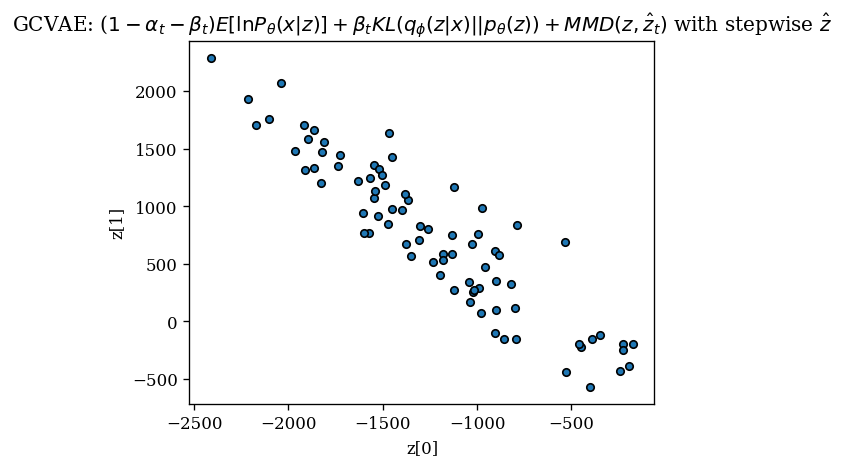

In [100]:
z_mean, z_std, z = model.model.encoder.predict(x_test, batch_size = batch_size)

fig = plt.figure(figsize=(5, 4))
plt.scatter(z[:, 0], z[:, 1], edgecolor="black", s = 20)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
if loss_index == 0:
    plt.title('VAE Loss: $E [\ln P_{\\theta}(x|z)]$ + $KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 1:
    plt.title('$\\beta$-VAE: $E [\ln P_{\\theta}(x|z)]$ + $\\beta KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 2:
    plt.title('ControlVAE: $E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 3:
    plt.title('infoVAE: ($E [\ln P_{\theta}(x|z)] + \\beta KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z_{t+1}, \\hat{z}_t)$ with stepwise $\\hat{z}$')
elif loss_index == 4:
    plt.title('GCVAE: ($1-\\alpha_t- \\beta_t)E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z,\\hat{z}_t)$ with stepwise $\\hat{z}$')


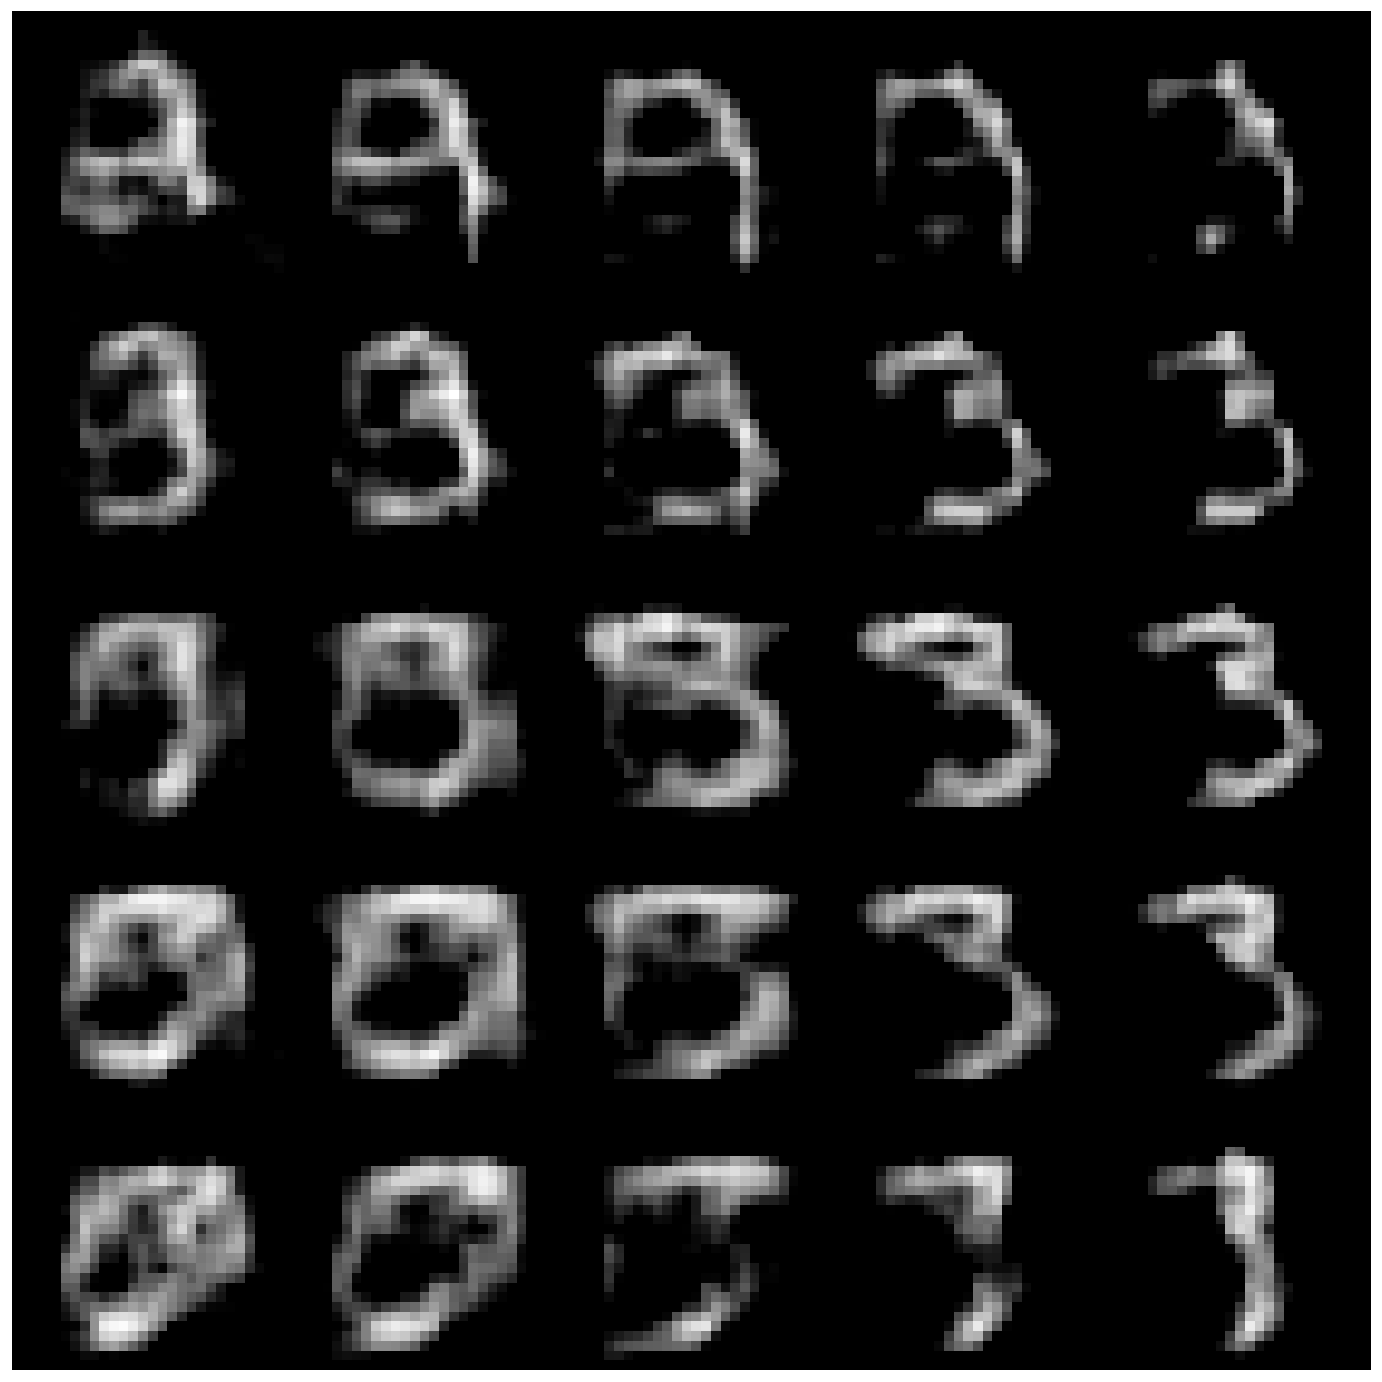

In [101]:
plot_latent_space(model.model, n= 5)

### 1000 -iterations

In [102]:
loss_index = 4
# vae_type = 'gcvae' #else infovae
inp_shape =  x_train.shape[1:]
num_features = inp_shape[0]

#the parameters are only to change fixed weights
params = { #beta, gamma
            'elbo': (1, 0),
            'betavae': ((1, 5), 0),
            'controlvae': (0, 0),
            'infovae': (0, 500),
            'gcvae': (1, 1), #not necessarily useful inside algo
    }

lr = 1e-3
epochs = 1000
hidden_dim = 100
latent_dims = 2
loss_type = list(params.keys())[loss_index] #elbo -> 0; beta-> 1; controlvae -> 2; infovae -> 3; gcvae -> 4
archi_type = 'v2'
#params
distrib_type = 'g'
beta, gamma = params[f'{loss_type}']
mmd_typ = 'mmd' #['mmd', 'mah', 'mah_rkhs', 'mah_gcvae']
save_model_arg = False
save_model_after = 10
model = gcvae(inp_shape = inp_shape,
                    num_features = num_features,
                    hidden_dim = hidden_dim,
                    latent_dim = latent_dims, 
                    batch_size = batch_size,
                    beta = beta,
                    gamma = gamma,
                    dist = distrib_type,
                    vloss = loss_type,
                    lr = lr, 
                    epochs = epochs,
                    architecture = archi_type,
                    mmd_type = mmd_typ).fit(train_dataset, x_test,
                                            datatype, stopping = False,
                                            save_model = save_model_arg,
                                            save_model_iter = save_model_after)

100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 1 - ELBO: 78.410 - RECON. LOSS: 87.847 - KL: 0.001 - alpha: 0.108 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 2 - ELBO: 75.794 - RECON. LOSS: 84.886 - KL: 0.001 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 3 - ELBO: 73.125 - RECON. LOSS: 81.876 - KL: 0.001 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.026


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 4 - ELBO: 70.711 - RECON. LOSS: 79.152 - KL: 0.002 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


epoch 5 - ELBO: 68.701 - RECON. LOSS: 76.887 - KL: 0.004 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 6 - ELBO: 68.228 - RECON. LOSS: 76.354 - KL: 0.007 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


epoch 7 - ELBO: 67.181 - RECON. LOSS: 75.171 - KL: 0.009 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


epoch 8 - ELBO: 66.216 - RECON. LOSS: 74.083 - KL: 0.010 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


epoch 9 - ELBO: 65.393 - RECON. LOSS: 73.152 - KL: 0.011 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 10 - ELBO: 64.684 - RECON. LOSS: 72.355 - KL: 0.011 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 11 - ELBO: 64.128 - RECON. LOSS: 71.729 - KL: 0.012 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 12 - ELBO: 63.651 - RECON. LOSS: 71.191 - KL: 0.013 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 13 - ELBO: 63.162 - RECON. LOSS: 70.640 - KL: 0.014 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


epoch 14 - ELBO: 62.580 - RECON. LOSS: 69.986 - KL: 0.016 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 15 - ELBO: 62.008 - RECON. LOSS: 69.339 - KL: 0.019 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 16 - ELBO: 61.431 - RECON. LOSS: 68.688 - KL: 0.023 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 17 - ELBO: 60.852 - RECON. LOSS: 68.034 - KL: 0.027 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 18 - ELBO: 60.444 - RECON. LOSS: 67.570 - KL: 0.034 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 19 - ELBO: 59.965 - RECON. LOSS: 67.030 - KL: 0.041 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 20 - ELBO: 59.571 - RECON. LOSS: 66.580 - KL: 0.051 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 21 - ELBO: 59.178 - RECON. LOSS: 66.135 - KL: 0.062 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 22 - ELBO: 58.795 - RECON. LOSS: 65.698 - KL: 0.077 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


epoch 23 - ELBO: 58.379 - RECON. LOSS: 65.225 - KL: 0.096 - alpha: 0.106 - beta: 0.000 - gamma: 1.049 - mmd: 0.042


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 24 - ELBO: 58.053 - RECON. LOSS: 64.851 - KL: 0.120 - alpha: 0.105 - beta: 0.000 - gamma: 1.049 - mmd: 0.047


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 25 - ELBO: 57.732 - RECON. LOSS: 64.482 - KL: 0.145 - alpha: 0.105 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 26 - ELBO: 57.385 - RECON. LOSS: 64.087 - KL: 0.169 - alpha: 0.105 - beta: 0.000 - gamma: 1.049 - mmd: 0.057


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 27 - ELBO: 57.094 - RECON. LOSS: 63.748 - KL: 0.192 - alpha: 0.105 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 28 - ELBO: 56.812 - RECON. LOSS: 63.428 - KL: 0.218 - alpha: 0.105 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 29 - ELBO: 56.523 - RECON. LOSS: 63.095 - KL: 0.248 - alpha: 0.105 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 30 - ELBO: 56.277 - RECON. LOSS: 62.811 - KL: 0.284 - alpha: 0.105 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


epoch 31 - ELBO: 56.023 - RECON. LOSS: 62.510 - KL: 0.329 - alpha: 0.105 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


epoch 32 - ELBO: 55.785 - RECON. LOSS: 62.233 - KL: 0.380 - alpha: 0.105 - beta: 0.000 - gamma: 1.050 - mmd: 0.102


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 33 - ELBO: 55.565 - RECON. LOSS: 61.969 - KL: 0.433 - alpha: 0.105 - beta: 0.000 - gamma: 1.050 - mmd: 0.117


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 34 - ELBO: 55.367 - RECON. LOSS: 61.732 - KL: 0.485 - alpha: 0.105 - beta: 0.000 - gamma: 1.051 - mmd: 0.128


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 35 - ELBO: 55.178 - RECON. LOSS: 61.501 - KL: 0.541 - alpha: 0.105 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 36 - ELBO: 54.992 - RECON. LOSS: 61.279 - KL: 0.602 - alpha: 0.105 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 37 - ELBO: 54.811 - RECON. LOSS: 61.060 - KL: 0.668 - alpha: 0.105 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 38 - ELBO: 54.644 - RECON. LOSS: 60.858 - KL: 0.734 - alpha: 0.105 - beta: 0.000 - gamma: 1.052 - mmd: 0.178


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 39 - ELBO: 54.490 - RECON. LOSS: 60.668 - KL: 0.792 - alpha: 0.105 - beta: 0.000 - gamma: 1.052 - mmd: 0.192


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 40 - ELBO: 54.331 - RECON. LOSS: 60.476 - KL: 0.839 - alpha: 0.105 - beta: 0.000 - gamma: 1.053 - mmd: 0.203


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 41 - ELBO: 54.184 - RECON. LOSS: 60.298 - KL: 0.880 - alpha: 0.105 - beta: 0.000 - gamma: 1.053 - mmd: 0.213


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 42 - ELBO: 54.038 - RECON. LOSS: 60.122 - KL: 0.919 - alpha: 0.105 - beta: 0.000 - gamma: 1.053 - mmd: 0.223


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 43 - ELBO: 53.889 - RECON. LOSS: 59.947 - KL: 0.959 - alpha: 0.105 - beta: 0.000 - gamma: 1.053 - mmd: 0.230


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 44 - ELBO: 53.751 - RECON. LOSS: 59.778 - KL: 1.002 - alpha: 0.105 - beta: 0.000 - gamma: 1.053 - mmd: 0.241


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 45 - ELBO: 53.622 - RECON. LOSS: 59.622 - KL: 1.045 - alpha: 0.105 - beta: 0.000 - gamma: 1.054 - mmd: 0.249


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 46 - ELBO: 53.494 - RECON. LOSS: 59.471 - KL: 1.084 - alpha: 0.105 - beta: 0.000 - gamma: 1.054 - mmd: 0.256


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 47 - ELBO: 53.363 - RECON. LOSS: 59.316 - KL: 1.117 - alpha: 0.105 - beta: 0.000 - gamma: 1.054 - mmd: 0.262


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 48 - ELBO: 53.228 - RECON. LOSS: 59.162 - KL: 1.147 - alpha: 0.105 - beta: 0.000 - gamma: 1.054 - mmd: 0.264


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch 49 - ELBO: 53.098 - RECON. LOSS: 59.011 - KL: 1.176 - alpha: 0.105 - beta: 0.000 - gamma: 1.054 - mmd: 0.267


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 50 - ELBO: 52.974 - RECON. LOSS: 58.866 - KL: 1.207 - alpha: 0.105 - beta: 0.000 - gamma: 1.054 - mmd: 0.273


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 51 - ELBO: 52.854 - RECON. LOSS: 58.723 - KL: 1.239 - alpha: 0.105 - beta: 0.000 - gamma: 1.054 - mmd: 0.280


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 52 - ELBO: 52.739 - RECON. LOSS: 58.588 - KL: 1.269 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.285


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 53 - ELBO: 52.626 - RECON. LOSS: 58.455 - KL: 1.294 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.289


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 54 - ELBO: 52.511 - RECON. LOSS: 58.323 - KL: 1.317 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.291


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 55 - ELBO: 52.397 - RECON. LOSS: 58.190 - KL: 1.342 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.295


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 56 - ELBO: 52.284 - RECON. LOSS: 58.057 - KL: 1.368 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.300


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 57 - ELBO: 52.174 - RECON. LOSS: 57.932 - KL: 1.396 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.301


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 58 - ELBO: 52.066 - RECON. LOSS: 57.807 - KL: 1.432 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.305


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 59 - ELBO: 51.960 - RECON. LOSS: 57.682 - KL: 1.465 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.309


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 60 - ELBO: 51.848 - RECON. LOSS: 57.555 - KL: 1.492 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.310


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 61 - ELBO: 51.737 - RECON. LOSS: 57.425 - KL: 1.543 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.314


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 62 - ELBO: 51.632 - RECON. LOSS: 57.303 - KL: 1.606 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.318


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 63 - ELBO: 51.526 - RECON. LOSS: 57.181 - KL: 1.643 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.320


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 64 - ELBO: 51.421 - RECON. LOSS: 57.062 - KL: 1.682 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.320


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 65 - ELBO: 51.317 - RECON. LOSS: 56.943 - KL: 1.743 - alpha: 0.105 - beta: 0.000 - gamma: 1.055 - mmd: 0.323


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 66 - ELBO: 51.213 - RECON. LOSS: 56.824 - KL: 1.801 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.325


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 67 - ELBO: 51.111 - RECON. LOSS: 56.707 - KL: 1.842 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.326


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 68 - ELBO: 51.014 - RECON. LOSS: 56.596 - KL: 1.881 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.328


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 69 - ELBO: 50.914 - RECON. LOSS: 56.481 - KL: 1.941 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 70 - ELBO: 50.816 - RECON. LOSS: 56.368 - KL: 2.004 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 71 - ELBO: 50.720 - RECON. LOSS: 56.259 - KL: 2.052 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 72 - ELBO: 50.623 - RECON. LOSS: 56.149 - KL: 2.103 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


epoch 73 - ELBO: 50.530 - RECON. LOSS: 56.042 - KL: 2.171 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 74 - ELBO: 50.432 - RECON. LOSS: 55.930 - KL: 2.236 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 75 - ELBO: 50.341 - RECON. LOSS: 55.825 - KL: 2.292 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 76 - ELBO: 50.246 - RECON. LOSS: 55.717 - KL: 2.362 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 77 - ELBO: 50.153 - RECON. LOSS: 55.610 - KL: 2.444 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 78 - ELBO: 50.062 - RECON. LOSS: 55.505 - KL: 2.516 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 79 - ELBO: 49.971 - RECON. LOSS: 55.399 - KL: 2.592 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 80 - ELBO: 49.879 - RECON. LOSS: 55.295 - KL: 2.677 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


epoch 81 - ELBO: 49.787 - RECON. LOSS: 55.190 - KL: 2.756 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 82 - ELBO: 49.698 - RECON. LOSS: 55.088 - KL: 2.830 - alpha: 0.105 - beta: 0.000 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


epoch 83 - ELBO: 49.608 - RECON. LOSS: 54.984 - KL: 2.915 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 84 - ELBO: 49.519 - RECON. LOSS: 54.883 - KL: 3.002 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.356


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 85 - ELBO: 49.432 - RECON. LOSS: 54.784 - KL: 3.084 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.357


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 86 - ELBO: 49.344 - RECON. LOSS: 54.682 - KL: 3.168 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.359


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 87 - ELBO: 49.257 - RECON. LOSS: 54.583 - KL: 3.251 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.360


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


epoch 88 - ELBO: 49.169 - RECON. LOSS: 54.484 - KL: 3.327 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.361


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 89 - ELBO: 49.084 - RECON. LOSS: 54.388 - KL: 3.409 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.361


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 90 - ELBO: 49.000 - RECON. LOSS: 54.292 - KL: 3.493 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.362


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 91 - ELBO: 48.916 - RECON. LOSS: 54.198 - KL: 3.561 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 92 - ELBO: 48.833 - RECON. LOSS: 54.103 - KL: 3.635 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 93 - ELBO: 48.748 - RECON. LOSS: 54.008 - KL: 3.710 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


epoch 94 - ELBO: 48.668 - RECON. LOSS: 53.918 - KL: 3.780 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 95 - ELBO: 48.586 - RECON. LOSS: 53.826 - KL: 3.858 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 96 - ELBO: 48.504 - RECON. LOSS: 53.734 - KL: 3.923 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 97 - ELBO: 48.422 - RECON. LOSS: 53.642 - KL: 3.990 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.364


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 98 - ELBO: 48.342 - RECON. LOSS: 53.551 - KL: 4.067 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.364


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 99 - ELBO: 48.260 - RECON. LOSS: 53.459 - KL: 4.132 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 100 - ELBO: 48.180 - RECON. LOSS: 53.371 - KL: 4.202 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 101 - ELBO: 48.101 - RECON. LOSS: 53.281 - KL: 4.268 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.364


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 102 - ELBO: 48.023 - RECON. LOSS: 53.193 - KL: 4.344 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.364


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 103 - ELBO: 47.944 - RECON. LOSS: 53.104 - KL: 4.406 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.364


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 104 - ELBO: 47.864 - RECON. LOSS: 53.015 - KL: 4.469 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.364


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 105 - ELBO: 47.785 - RECON. LOSS: 52.927 - KL: 4.540 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 106 - ELBO: 47.707 - RECON. LOSS: 52.839 - KL: 4.602 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 107 - ELBO: 47.632 - RECON. LOSS: 52.754 - KL: 4.666 - alpha: 0.104 - beta: 0.000 - gamma: 1.057 - mmd: 0.363


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 108 - ELBO: 47.556 - RECON. LOSS: 52.670 - KL: 4.717 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.362


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 109 - ELBO: 47.482 - RECON. LOSS: 52.588 - KL: 4.790 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.362


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 110 - ELBO: 47.407 - RECON. LOSS: 52.505 - KL: 4.842 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.361


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 111 - ELBO: 47.333 - RECON. LOSS: 52.422 - KL: 4.901 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.361


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 112 - ELBO: 47.255 - RECON. LOSS: 52.335 - KL: 4.968 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.361


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 113 - ELBO: 47.182 - RECON. LOSS: 52.253 - KL: 5.024 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.360


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 114 - ELBO: 47.103 - RECON. LOSS: 52.166 - KL: 5.085 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.359


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


epoch 115 - ELBO: 47.026 - RECON. LOSS: 52.080 - KL: 5.143 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.359


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 116 - ELBO: 46.951 - RECON. LOSS: 51.997 - KL: 5.197 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.358


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


epoch 117 - ELBO: 46.874 - RECON. LOSS: 51.910 - KL: 5.257 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.358


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 118 - ELBO: 46.797 - RECON. LOSS: 51.824 - KL: 5.311 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.358


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 119 - ELBO: 46.719 - RECON. LOSS: 51.737 - KL: 5.367 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.357


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 120 - ELBO: 46.642 - RECON. LOSS: 51.652 - KL: 5.428 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.357


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 121 - ELBO: 46.566 - RECON. LOSS: 51.566 - KL: 5.480 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.357


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 122 - ELBO: 46.488 - RECON. LOSS: 51.479 - KL: 5.534 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.356


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 123 - ELBO: 46.411 - RECON. LOSS: 51.394 - KL: 5.591 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.356


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 124 - ELBO: 46.333 - RECON. LOSS: 51.307 - KL: 5.650 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 125 - ELBO: 46.255 - RECON. LOSS: 51.220 - KL: 5.711 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 126 - ELBO: 46.179 - RECON. LOSS: 51.136 - KL: 5.770 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 127 - ELBO: 46.106 - RECON. LOSS: 51.054 - KL: 5.829 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 128 - ELBO: 46.034 - RECON. LOSS: 50.973 - KL: 5.878 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 129 - ELBO: 45.968 - RECON. LOSS: 50.898 - KL: 5.945 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 130 - ELBO: 45.913 - RECON. LOSS: 50.838 - KL: 5.986 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 131 - ELBO: 45.838 - RECON. LOSS: 50.754 - KL: 6.041 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 132 - ELBO: 45.774 - RECON. LOSS: 50.682 - KL: 6.101 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 133 - ELBO: 45.712 - RECON. LOSS: 50.615 - KL: 6.140 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 134 - ELBO: 45.641 - RECON. LOSS: 50.535 - KL: 6.189 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 135 - ELBO: 45.580 - RECON. LOSS: 50.467 - KL: 6.252 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 136 - ELBO: 45.514 - RECON. LOSS: 50.394 - KL: 6.296 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 137 - ELBO: 45.449 - RECON. LOSS: 50.322 - KL: 6.339 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 138 - ELBO: 45.378 - RECON. LOSS: 50.243 - KL: 6.392 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 139 - ELBO: 45.313 - RECON. LOSS: 50.170 - KL: 6.443 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 140 - ELBO: 45.243 - RECON. LOSS: 50.092 - KL: 6.488 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 141 - ELBO: 45.178 - RECON. LOSS: 50.019 - KL: 6.539 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 142 - ELBO: 45.104 - RECON. LOSS: 49.938 - KL: 6.590 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 143 - ELBO: 45.037 - RECON. LOSS: 49.863 - KL: 6.636 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 144 - ELBO: 44.964 - RECON. LOSS: 49.782 - KL: 6.684 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 145 - ELBO: 44.897 - RECON. LOSS: 49.707 - KL: 6.735 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 146 - ELBO: 44.826 - RECON. LOSS: 49.628 - KL: 6.781 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 147 - ELBO: 44.756 - RECON. LOSS: 49.551 - KL: 6.832 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 148 - ELBO: 44.684 - RECON. LOSS: 49.470 - KL: 6.883 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 149 - ELBO: 44.616 - RECON. LOSS: 49.394 - KL: 6.927 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 150 - ELBO: 44.544 - RECON. LOSS: 49.314 - KL: 6.975 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 151 - ELBO: 44.474 - RECON. LOSS: 49.236 - KL: 7.030 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 152 - ELBO: 44.405 - RECON. LOSS: 49.158 - KL: 7.076 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 153 - ELBO: 44.333 - RECON. LOSS: 49.079 - KL: 7.124 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 154 - ELBO: 44.264 - RECON. LOSS: 49.001 - KL: 7.175 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 155 - ELBO: 44.193 - RECON. LOSS: 48.922 - KL: 7.223 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 156 - ELBO: 44.123 - RECON. LOSS: 48.844 - KL: 7.275 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 157 - ELBO: 44.053 - RECON. LOSS: 48.766 - KL: 7.325 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 158 - ELBO: 43.982 - RECON. LOSS: 48.686 - KL: 7.374 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 159 - ELBO: 43.912 - RECON. LOSS: 48.609 - KL: 7.425 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 160 - ELBO: 43.845 - RECON. LOSS: 48.533 - KL: 7.475 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 161 - ELBO: 43.776 - RECON. LOSS: 48.456 - KL: 7.528 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 162 - ELBO: 43.709 - RECON. LOSS: 48.382 - KL: 7.572 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 163 - ELBO: 43.641 - RECON. LOSS: 48.306 - KL: 7.626 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 164 - ELBO: 43.571 - RECON. LOSS: 48.228 - KL: 7.675 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 165 - ELBO: 43.501 - RECON. LOSS: 48.149 - KL: 7.724 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 166 - ELBO: 43.432 - RECON. LOSS: 48.072 - KL: 7.775 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 167 - ELBO: 43.364 - RECON. LOSS: 47.997 - KL: 7.823 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 168 - ELBO: 43.297 - RECON. LOSS: 47.921 - KL: 7.877 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 169 - ELBO: 43.228 - RECON. LOSS: 47.844 - KL: 7.923 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 170 - ELBO: 43.160 - RECON. LOSS: 47.769 - KL: 7.974 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 171 - ELBO: 43.100 - RECON. LOSS: 47.702 - KL: 8.023 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 172 - ELBO: 43.042 - RECON. LOSS: 47.637 - KL: 8.075 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 173 - ELBO: 42.981 - RECON. LOSS: 47.569 - KL: 8.119 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 174 - ELBO: 42.919 - RECON. LOSS: 47.500 - KL: 8.172 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 175 - ELBO: 42.865 - RECON. LOSS: 47.440 - KL: 8.215 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 176 - ELBO: 42.800 - RECON. LOSS: 47.367 - KL: 8.265 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 177 - ELBO: 42.736 - RECON. LOSS: 47.296 - KL: 8.314 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 178 - ELBO: 42.676 - RECON. LOSS: 47.228 - KL: 8.359 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 179 - ELBO: 42.612 - RECON. LOSS: 47.157 - KL: 8.409 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 180 - ELBO: 42.552 - RECON. LOSS: 47.090 - KL: 8.454 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 181 - ELBO: 42.486 - RECON. LOSS: 47.016 - KL: 8.503 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 182 - ELBO: 42.425 - RECON. LOSS: 46.947 - KL: 8.552 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 183 - ELBO: 42.363 - RECON. LOSS: 46.879 - KL: 8.596 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 184 - ELBO: 42.303 - RECON. LOSS: 46.812 - KL: 8.646 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 185 - ELBO: 42.247 - RECON. LOSS: 46.749 - KL: 8.689 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 186 - ELBO: 42.183 - RECON. LOSS: 46.678 - KL: 8.741 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 187 - ELBO: 42.123 - RECON. LOSS: 46.610 - KL: 8.789 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 188 - ELBO: 42.061 - RECON. LOSS: 46.541 - KL: 8.832 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 189 - ELBO: 42.003 - RECON. LOSS: 46.475 - KL: 8.880 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 190 - ELBO: 41.947 - RECON. LOSS: 46.413 - KL: 8.924 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 191 - ELBO: 41.886 - RECON. LOSS: 46.345 - KL: 8.974 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 192 - ELBO: 41.827 - RECON. LOSS: 46.280 - KL: 9.018 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 193 - ELBO: 41.765 - RECON. LOSS: 46.210 - KL: 9.063 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 194 - ELBO: 41.705 - RECON. LOSS: 46.144 - KL: 9.111 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 195 - ELBO: 41.648 - RECON. LOSS: 46.079 - KL: 9.155 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 196 - ELBO: 41.589 - RECON. LOSS: 46.014 - KL: 9.204 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 197 - ELBO: 41.531 - RECON. LOSS: 45.949 - KL: 9.246 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 198 - ELBO: 41.470 - RECON. LOSS: 45.881 - KL: 9.294 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 199 - ELBO: 41.412 - RECON. LOSS: 45.815 - KL: 9.342 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 200 - ELBO: 41.352 - RECON. LOSS: 45.748 - KL: 9.386 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 201 - ELBO: 41.295 - RECON. LOSS: 45.684 - KL: 9.432 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 202 - ELBO: 41.239 - RECON. LOSS: 45.622 - KL: 9.474 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 203 - ELBO: 41.182 - RECON. LOSS: 45.558 - KL: 9.526 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 204 - ELBO: 41.126 - RECON. LOSS: 45.496 - KL: 9.569 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 205 - ELBO: 41.069 - RECON. LOSS: 45.432 - KL: 9.614 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 206 - ELBO: 41.011 - RECON. LOSS: 45.367 - KL: 9.658 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 207 - ELBO: 40.953 - RECON. LOSS: 45.303 - KL: 9.707 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 208 - ELBO: 40.894 - RECON. LOSS: 45.237 - KL: 9.751 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 209 - ELBO: 40.836 - RECON. LOSS: 45.172 - KL: 9.793 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 210 - ELBO: 40.779 - RECON. LOSS: 45.107 - KL: 9.841 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 211 - ELBO: 40.722 - RECON. LOSS: 45.043 - KL: 9.886 - alpha: 0.104 - beta: 0.000 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 212 - ELBO: 40.665 - RECON. LOSS: 44.980 - KL: 9.931 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 213 - ELBO: 40.611 - RECON. LOSS: 44.920 - KL: 9.973 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 214 - ELBO: 40.560 - RECON. LOSS: 44.863 - KL: 10.024 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 215 - ELBO: 40.519 - RECON. LOSS: 44.817 - KL: 10.063 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 216 - ELBO: 40.472 - RECON. LOSS: 44.764 - KL: 10.110 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 217 - ELBO: 40.419 - RECON. LOSS: 44.706 - KL: 10.147 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 218 - ELBO: 40.364 - RECON. LOSS: 44.644 - KL: 10.191 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 219 - ELBO: 40.313 - RECON. LOSS: 44.587 - KL: 10.240 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 220 - ELBO: 40.265 - RECON. LOSS: 44.533 - KL: 10.275 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 221 - ELBO: 40.210 - RECON. LOSS: 44.472 - KL: 10.316 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


epoch 222 - ELBO: 40.161 - RECON. LOSS: 44.417 - KL: 10.364 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 223 - ELBO: 40.116 - RECON. LOSS: 44.367 - KL: 10.401 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 224 - ELBO: 40.062 - RECON. LOSS: 44.306 - KL: 10.440 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 225 - ELBO: 40.017 - RECON. LOSS: 44.255 - KL: 10.484 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 226 - ELBO: 39.973 - RECON. LOSS: 44.207 - KL: 10.516 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 227 - ELBO: 39.921 - RECON. LOSS: 44.148 - KL: 10.558 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 228 - ELBO: 39.880 - RECON. LOSS: 44.102 - KL: 10.607 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 229 - ELBO: 39.837 - RECON. LOSS: 44.055 - KL: 10.637 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 230 - ELBO: 39.788 - RECON. LOSS: 44.000 - KL: 10.672 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 231 - ELBO: 39.750 - RECON. LOSS: 43.957 - KL: 10.721 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 232 - ELBO: 39.701 - RECON. LOSS: 43.901 - KL: 10.760 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 233 - ELBO: 39.655 - RECON. LOSS: 43.850 - KL: 10.791 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 234 - ELBO: 39.606 - RECON. LOSS: 43.796 - KL: 10.829 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 235 - ELBO: 39.558 - RECON. LOSS: 43.742 - KL: 10.868 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 236 - ELBO: 39.513 - RECON. LOSS: 43.691 - KL: 10.902 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 237 - ELBO: 39.463 - RECON. LOSS: 43.635 - KL: 10.939 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 238 - ELBO: 39.417 - RECON. LOSS: 43.584 - KL: 10.979 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 239 - ELBO: 39.368 - RECON. LOSS: 43.529 - KL: 11.011 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 240 - ELBO: 39.323 - RECON. LOSS: 43.479 - KL: 11.044 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 241 - ELBO: 39.276 - RECON. LOSS: 43.426 - KL: 11.085 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 242 - ELBO: 39.227 - RECON. LOSS: 43.372 - KL: 11.126 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 243 - ELBO: 39.180 - RECON. LOSS: 43.319 - KL: 11.158 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 244 - ELBO: 39.131 - RECON. LOSS: 43.264 - KL: 11.194 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 245 - ELBO: 39.085 - RECON. LOSS: 43.213 - KL: 11.236 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 246 - ELBO: 39.038 - RECON. LOSS: 43.161 - KL: 11.272 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 247 - ELBO: 38.990 - RECON. LOSS: 43.106 - KL: 11.308 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


epoch 248 - ELBO: 38.943 - RECON. LOSS: 43.054 - KL: 11.347 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


epoch 249 - ELBO: 38.895 - RECON. LOSS: 43.000 - KL: 11.383 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 250 - ELBO: 38.850 - RECON. LOSS: 42.950 - KL: 11.421 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 251 - ELBO: 38.805 - RECON. LOSS: 42.900 - KL: 11.463 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 252 - ELBO: 38.757 - RECON. LOSS: 42.846 - KL: 11.500 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 253 - ELBO: 38.711 - RECON. LOSS: 42.794 - KL: 11.535 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 254 - ELBO: 38.665 - RECON. LOSS: 42.743 - KL: 11.575 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 255 - ELBO: 38.619 - RECON. LOSS: 42.691 - KL: 11.617 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 256 - ELBO: 38.573 - RECON. LOSS: 42.640 - KL: 11.652 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 257 - ELBO: 38.527 - RECON. LOSS: 42.588 - KL: 11.689 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 258 - ELBO: 38.483 - RECON. LOSS: 42.538 - KL: 11.730 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 259 - ELBO: 38.440 - RECON. LOSS: 42.490 - KL: 11.767 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 260 - ELBO: 38.394 - RECON. LOSS: 42.439 - KL: 11.808 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 261 - ELBO: 38.348 - RECON. LOSS: 42.387 - KL: 11.845 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 262 - ELBO: 38.302 - RECON. LOSS: 42.337 - KL: 11.881 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 263 - ELBO: 38.259 - RECON. LOSS: 42.288 - KL: 11.923 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 264 - ELBO: 38.214 - RECON. LOSS: 42.238 - KL: 11.961 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 265 - ELBO: 38.169 - RECON. LOSS: 42.187 - KL: 11.998 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 266 - ELBO: 38.123 - RECON. LOSS: 42.136 - KL: 12.037 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 267 - ELBO: 38.078 - RECON. LOSS: 42.086 - KL: 12.075 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 268 - ELBO: 38.035 - RECON. LOSS: 42.037 - KL: 12.114 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 269 - ELBO: 37.990 - RECON. LOSS: 41.987 - KL: 12.153 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 270 - ELBO: 37.945 - RECON. LOSS: 41.936 - KL: 12.191 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 271 - ELBO: 37.900 - RECON. LOSS: 41.886 - KL: 12.231 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 272 - ELBO: 37.857 - RECON. LOSS: 41.838 - KL: 12.270 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 273 - ELBO: 37.814 - RECON. LOSS: 41.789 - KL: 12.308 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 274 - ELBO: 37.770 - RECON. LOSS: 41.740 - KL: 12.347 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 275 - ELBO: 37.725 - RECON. LOSS: 41.690 - KL: 12.388 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 276 - ELBO: 37.681 - RECON. LOSS: 41.641 - KL: 12.426 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 277 - ELBO: 37.638 - RECON. LOSS: 41.592 - KL: 12.465 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 278 - ELBO: 37.595 - RECON. LOSS: 41.545 - KL: 12.506 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 279 - ELBO: 37.552 - RECON. LOSS: 41.496 - KL: 12.544 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 280 - ELBO: 37.510 - RECON. LOSS: 41.448 - KL: 12.586 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 281 - ELBO: 37.469 - RECON. LOSS: 41.403 - KL: 12.623 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 282 - ELBO: 37.428 - RECON. LOSS: 41.358 - KL: 12.665 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


epoch 283 - ELBO: 37.389 - RECON. LOSS: 41.313 - KL: 12.701 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 284 - ELBO: 37.347 - RECON. LOSS: 41.266 - KL: 12.743 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 285 - ELBO: 37.305 - RECON. LOSS: 41.219 - KL: 12.780 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 286 - ELBO: 37.265 - RECON. LOSS: 41.175 - KL: 12.821 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 287 - ELBO: 37.226 - RECON. LOSS: 41.131 - KL: 12.860 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 288 - ELBO: 37.187 - RECON. LOSS: 41.087 - KL: 12.899 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 289 - ELBO: 37.145 - RECON. LOSS: 41.040 - KL: 12.937 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 290 - ELBO: 37.104 - RECON. LOSS: 40.994 - KL: 12.976 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 291 - ELBO: 37.065 - RECON. LOSS: 40.950 - KL: 13.013 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 292 - ELBO: 37.024 - RECON. LOSS: 40.904 - KL: 13.054 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 293 - ELBO: 36.981 - RECON. LOSS: 40.857 - KL: 13.092 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 294 - ELBO: 36.942 - RECON. LOSS: 40.812 - KL: 13.129 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 295 - ELBO: 36.901 - RECON. LOSS: 40.767 - KL: 13.170 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 296 - ELBO: 36.860 - RECON. LOSS: 40.721 - KL: 13.207 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 297 - ELBO: 36.819 - RECON. LOSS: 40.675 - KL: 13.246 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 298 - ELBO: 36.780 - RECON. LOSS: 40.632 - KL: 13.284 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 299 - ELBO: 36.744 - RECON. LOSS: 40.591 - KL: 13.326 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 300 - ELBO: 36.712 - RECON. LOSS: 40.555 - KL: 13.359 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 301 - ELBO: 36.684 - RECON. LOSS: 40.524 - KL: 13.404 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 302 - ELBO: 36.660 - RECON. LOSS: 40.498 - KL: 13.435 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 303 - ELBO: 36.621 - RECON. LOSS: 40.454 - KL: 13.472 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 304 - ELBO: 36.588 - RECON. LOSS: 40.417 - KL: 13.512 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 305 - ELBO: 36.564 - RECON. LOSS: 40.390 - KL: 13.541 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 306 - ELBO: 36.525 - RECON. LOSS: 40.345 - KL: 13.576 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 307 - ELBO: 36.501 - RECON. LOSS: 40.319 - KL: 13.618 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 308 - ELBO: 36.478 - RECON. LOSS: 40.293 - KL: 13.644 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 309 - ELBO: 36.445 - RECON. LOSS: 40.257 - KL: 13.675 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 310 - ELBO: 36.424 - RECON. LOSS: 40.233 - KL: 13.717 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 311 - ELBO: 36.387 - RECON. LOSS: 40.193 - KL: 13.746 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 312 - ELBO: 36.360 - RECON. LOSS: 40.162 - KL: 13.771 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.328


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 313 - ELBO: 36.325 - RECON. LOSS: 40.123 - KL: 13.805 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.328


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 314 - ELBO: 36.295 - RECON. LOSS: 40.090 - KL: 13.841 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.328


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 315 - ELBO: 36.262 - RECON. LOSS: 40.053 - KL: 13.869 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 316 - ELBO: 36.230 - RECON. LOSS: 40.016 - KL: 13.894 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.328


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 317 - ELBO: 36.196 - RECON. LOSS: 39.979 - KL: 13.928 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.328


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 318 - ELBO: 36.162 - RECON. LOSS: 39.941 - KL: 13.963 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


epoch 319 - ELBO: 36.129 - RECON. LOSS: 39.904 - KL: 13.991 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.328


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


epoch 320 - ELBO: 36.094 - RECON. LOSS: 39.865 - KL: 14.019 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 321 - ELBO: 36.061 - RECON. LOSS: 39.827 - KL: 14.053 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 322 - ELBO: 36.025 - RECON. LOSS: 39.787 - KL: 14.085 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 323 - ELBO: 35.992 - RECON. LOSS: 39.750 - KL: 14.113 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 324 - ELBO: 35.955 - RECON. LOSS: 39.709 - KL: 14.143 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 325 - ELBO: 35.921 - RECON. LOSS: 39.670 - KL: 14.177 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 326 - ELBO: 35.885 - RECON. LOSS: 39.630 - KL: 14.208 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 327 - ELBO: 35.849 - RECON. LOSS: 39.591 - KL: 14.238 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 328 - ELBO: 35.814 - RECON. LOSS: 39.551 - KL: 14.272 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 329 - ELBO: 35.777 - RECON. LOSS: 39.510 - KL: 14.305 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 330 - ELBO: 35.743 - RECON. LOSS: 39.471 - KL: 14.335 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 331 - ELBO: 35.706 - RECON. LOSS: 39.430 - KL: 14.368 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 332 - ELBO: 35.671 - RECON. LOSS: 39.391 - KL: 14.401 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 333 - ELBO: 35.635 - RECON. LOSS: 39.351 - KL: 14.432 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


epoch 334 - ELBO: 35.599 - RECON. LOSS: 39.310 - KL: 14.464 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


epoch 335 - ELBO: 35.564 - RECON. LOSS: 39.270 - KL: 14.498 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 336 - ELBO: 35.528 - RECON. LOSS: 39.230 - KL: 14.529 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


epoch 337 - ELBO: 35.491 - RECON. LOSS: 39.189 - KL: 14.562 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 338 - ELBO: 35.456 - RECON. LOSS: 39.150 - KL: 14.597 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


epoch 339 - ELBO: 35.420 - RECON. LOSS: 39.109 - KL: 14.629 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


epoch 340 - ELBO: 35.384 - RECON. LOSS: 39.069 - KL: 14.662 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


epoch 341 - ELBO: 35.349 - RECON. LOSS: 39.030 - KL: 14.697 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


epoch 342 - ELBO: 35.315 - RECON. LOSS: 38.992 - KL: 14.729 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 343 - ELBO: 35.281 - RECON. LOSS: 38.954 - KL: 14.761 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 344 - ELBO: 35.251 - RECON. LOSS: 38.921 - KL: 14.799 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 345 - ELBO: 35.221 - RECON. LOSS: 38.887 - KL: 14.831 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 346 - ELBO: 35.188 - RECON. LOSS: 38.850 - KL: 14.865 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 347 - ELBO: 35.153 - RECON. LOSS: 38.810 - KL: 14.898 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 348 - ELBO: 35.119 - RECON. LOSS: 38.773 - KL: 14.931 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 349 - ELBO: 35.088 - RECON. LOSS: 38.738 - KL: 14.966 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 350 - ELBO: 35.054 - RECON. LOSS: 38.700 - KL: 14.998 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


epoch 351 - ELBO: 35.019 - RECON. LOSS: 38.661 - KL: 15.030 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 352 - ELBO: 34.987 - RECON. LOSS: 38.625 - KL: 15.065 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 353 - ELBO: 34.953 - RECON. LOSS: 38.587 - KL: 15.098 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 354 - ELBO: 34.919 - RECON. LOSS: 38.548 - KL: 15.130 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 355 - ELBO: 34.884 - RECON. LOSS: 38.510 - KL: 15.163 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 356 - ELBO: 34.850 - RECON. LOSS: 38.471 - KL: 15.196 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 357 - ELBO: 34.816 - RECON. LOSS: 38.433 - KL: 15.229 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 358 - ELBO: 34.781 - RECON. LOSS: 38.395 - KL: 15.261 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 359 - ELBO: 34.747 - RECON. LOSS: 38.356 - KL: 15.293 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 360 - ELBO: 34.714 - RECON. LOSS: 38.319 - KL: 15.328 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 361 - ELBO: 34.680 - RECON. LOSS: 38.281 - KL: 15.359 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 362 - ELBO: 34.646 - RECON. LOSS: 38.243 - KL: 15.393 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 363 - ELBO: 34.611 - RECON. LOSS: 38.204 - KL: 15.426 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 364 - ELBO: 34.577 - RECON. LOSS: 38.166 - KL: 15.458 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


epoch 365 - ELBO: 34.544 - RECON. LOSS: 38.129 - KL: 15.491 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 366 - ELBO: 34.511 - RECON. LOSS: 38.091 - KL: 15.524 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 367 - ELBO: 34.478 - RECON. LOSS: 38.055 - KL: 15.557 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 368 - ELBO: 34.444 - RECON. LOSS: 38.017 - KL: 15.589 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 369 - ELBO: 34.410 - RECON. LOSS: 37.979 - KL: 15.622 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 370 - ELBO: 34.377 - RECON. LOSS: 37.941 - KL: 15.654 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 371 - ELBO: 34.343 - RECON. LOSS: 37.904 - KL: 15.687 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 372 - ELBO: 34.311 - RECON. LOSS: 37.867 - KL: 15.718 - alpha: 0.103 - beta: 0.000 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


epoch 373 - ELBO: 34.279 - RECON. LOSS: 37.831 - KL: 15.752 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 374 - ELBO: 34.247 - RECON. LOSS: 37.795 - KL: 15.782 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 375 - ELBO: 34.215 - RECON. LOSS: 37.759 - KL: 15.815 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 376 - ELBO: 34.182 - RECON. LOSS: 37.723 - KL: 15.845 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 377 - ELBO: 34.151 - RECON. LOSS: 37.687 - KL: 15.879 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 378 - ELBO: 34.121 - RECON. LOSS: 37.654 - KL: 15.908 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.329


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 379 - ELBO: 34.096 - RECON. LOSS: 37.625 - KL: 15.943 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 380 - ELBO: 34.068 - RECON. LOSS: 37.594 - KL: 15.971 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 381 - ELBO: 34.039 - RECON. LOSS: 37.561 - KL: 16.004 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 382 - ELBO: 34.009 - RECON. LOSS: 37.527 - KL: 16.031 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 383 - ELBO: 33.979 - RECON. LOSS: 37.493 - KL: 16.062 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 384 - ELBO: 33.949 - RECON. LOSS: 37.460 - KL: 16.091 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 385 - ELBO: 33.917 - RECON. LOSS: 37.424 - KL: 16.119 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 386 - ELBO: 33.886 - RECON. LOSS: 37.390 - KL: 16.150 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 387 - ELBO: 33.858 - RECON. LOSS: 37.358 - KL: 16.176 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 388 - ELBO: 33.828 - RECON. LOSS: 37.324 - KL: 16.206 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 389 - ELBO: 33.796 - RECON. LOSS: 37.288 - KL: 16.235 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 390 - ELBO: 33.765 - RECON. LOSS: 37.254 - KL: 16.263 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.330


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 391 - ELBO: 33.734 - RECON. LOSS: 37.219 - KL: 16.292 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 392 - ELBO: 33.703 - RECON. LOSS: 37.184 - KL: 16.319 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 393 - ELBO: 33.674 - RECON. LOSS: 37.151 - KL: 16.349 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 394 - ELBO: 33.645 - RECON. LOSS: 37.119 - KL: 16.376 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 395 - ELBO: 33.615 - RECON. LOSS: 37.085 - KL: 16.407 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 396 - ELBO: 33.586 - RECON. LOSS: 37.052 - KL: 16.433 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 397 - ELBO: 33.556 - RECON. LOSS: 37.018 - KL: 16.462 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 398 - ELBO: 33.525 - RECON. LOSS: 36.984 - KL: 16.489 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 399 - ELBO: 33.494 - RECON. LOSS: 36.948 - KL: 16.516 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 400 - ELBO: 33.462 - RECON. LOSS: 36.913 - KL: 16.545 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 401 - ELBO: 33.432 - RECON. LOSS: 36.879 - KL: 16.571 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 402 - ELBO: 33.402 - RECON. LOSS: 36.845 - KL: 16.599 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 403 - ELBO: 33.372 - RECON. LOSS: 36.811 - KL: 16.625 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 404 - ELBO: 33.343 - RECON. LOSS: 36.779 - KL: 16.655 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 405 - ELBO: 33.314 - RECON. LOSS: 36.747 - KL: 16.679 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 406 - ELBO: 33.287 - RECON. LOSS: 36.715 - KL: 16.710 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 407 - ELBO: 33.256 - RECON. LOSS: 36.681 - KL: 16.735 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.331


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 408 - ELBO: 33.225 - RECON. LOSS: 36.647 - KL: 16.762 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 409 - ELBO: 33.196 - RECON. LOSS: 36.613 - KL: 16.789 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 410 - ELBO: 33.165 - RECON. LOSS: 36.578 - KL: 16.816 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 411 - ELBO: 33.134 - RECON. LOSS: 36.543 - KL: 16.842 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 412 - ELBO: 33.103 - RECON. LOSS: 36.508 - KL: 16.869 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 413 - ELBO: 33.072 - RECON. LOSS: 36.474 - KL: 16.895 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 414 - ELBO: 33.041 - RECON. LOSS: 36.439 - KL: 16.921 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 415 - ELBO: 33.011 - RECON. LOSS: 36.405 - KL: 16.949 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 416 - ELBO: 32.981 - RECON. LOSS: 36.371 - KL: 16.973 - alpha: 0.103 - beta: 0.001 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 417 - ELBO: 32.951 - RECON. LOSS: 36.338 - KL: 17.001 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 418 - ELBO: 32.924 - RECON. LOSS: 36.307 - KL: 17.026 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 419 - ELBO: 32.903 - RECON. LOSS: 36.283 - KL: 17.055 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 420 - ELBO: 32.889 - RECON. LOSS: 36.267 - KL: 17.077 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 421 - ELBO: 32.868 - RECON. LOSS: 36.243 - KL: 17.106 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 422 - ELBO: 32.839 - RECON. LOSS: 36.211 - KL: 17.129 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 423 - ELBO: 32.812 - RECON. LOSS: 36.180 - KL: 17.152 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.332


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


epoch 424 - ELBO: 32.791 - RECON. LOSS: 36.157 - KL: 17.179 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 425 - ELBO: 32.766 - RECON. LOSS: 36.129 - KL: 17.200 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 426 - ELBO: 32.737 - RECON. LOSS: 36.096 - KL: 17.225 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 427 - ELBO: 32.712 - RECON. LOSS: 36.068 - KL: 17.249 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 428 - ELBO: 32.685 - RECON. LOSS: 36.038 - KL: 17.269 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 429 - ELBO: 32.657 - RECON. LOSS: 36.006 - KL: 17.294 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 430 - ELBO: 32.630 - RECON. LOSS: 35.977 - KL: 17.317 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 431 - ELBO: 32.601 - RECON. LOSS: 35.944 - KL: 17.337 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 432 - ELBO: 32.573 - RECON. LOSS: 35.913 - KL: 17.362 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 433 - ELBO: 32.547 - RECON. LOSS: 35.883 - KL: 17.383 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 434 - ELBO: 32.518 - RECON. LOSS: 35.851 - KL: 17.406 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 435 - ELBO: 32.489 - RECON. LOSS: 35.818 - KL: 17.429 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 436 - ELBO: 32.461 - RECON. LOSS: 35.787 - KL: 17.451 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 437 - ELBO: 32.432 - RECON. LOSS: 35.755 - KL: 17.473 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 438 - ELBO: 32.403 - RECON. LOSS: 35.722 - KL: 17.495 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 439 - ELBO: 32.375 - RECON. LOSS: 35.690 - KL: 17.519 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 440 - ELBO: 32.345 - RECON. LOSS: 35.657 - KL: 17.541 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.333


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 441 - ELBO: 32.316 - RECON. LOSS: 35.623 - KL: 17.564 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 442 - ELBO: 32.287 - RECON. LOSS: 35.591 - KL: 17.587 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 443 - ELBO: 32.258 - RECON. LOSS: 35.558 - KL: 17.610 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 444 - ELBO: 32.229 - RECON. LOSS: 35.525 - KL: 17.634 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 445 - ELBO: 32.200 - RECON. LOSS: 35.493 - KL: 17.655 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 446 - ELBO: 32.172 - RECON. LOSS: 35.462 - KL: 17.681 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 447 - ELBO: 32.146 - RECON. LOSS: 35.432 - KL: 17.701 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 448 - ELBO: 32.120 - RECON. LOSS: 35.403 - KL: 17.726 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 449 - ELBO: 32.097 - RECON. LOSS: 35.377 - KL: 17.746 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 450 - ELBO: 32.074 - RECON. LOSS: 35.351 - KL: 17.772 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 451 - ELBO: 32.050 - RECON. LOSS: 35.324 - KL: 17.791 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 452 - ELBO: 32.025 - RECON. LOSS: 35.296 - KL: 17.816 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 453 - ELBO: 31.997 - RECON. LOSS: 35.264 - KL: 17.838 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


epoch 454 - ELBO: 31.970 - RECON. LOSS: 35.234 - KL: 17.858 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 455 - ELBO: 31.947 - RECON. LOSS: 35.208 - KL: 17.883 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 456 - ELBO: 31.921 - RECON. LOSS: 35.178 - KL: 17.903 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 457 - ELBO: 31.892 - RECON. LOSS: 35.146 - KL: 17.924 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


epoch 458 - ELBO: 31.864 - RECON. LOSS: 35.115 - KL: 17.947 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 459 - ELBO: 31.838 - RECON. LOSS: 35.085 - KL: 17.966 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 460 - ELBO: 31.811 - RECON. LOSS: 35.055 - KL: 17.988 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 461 - ELBO: 31.783 - RECON. LOSS: 35.023 - KL: 18.009 - alpha: 0.103 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 462 - ELBO: 31.755 - RECON. LOSS: 34.992 - KL: 18.029 - alpha: 0.102 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 463 - ELBO: 31.729 - RECON. LOSS: 34.963 - KL: 18.051 - alpha: 0.102 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 464 - ELBO: 31.703 - RECON. LOSS: 34.933 - KL: 18.070 - alpha: 0.102 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 465 - ELBO: 31.676 - RECON. LOSS: 34.903 - KL: 18.093 - alpha: 0.102 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 466 - ELBO: 31.648 - RECON. LOSS: 34.871 - KL: 18.113 - alpha: 0.102 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 467 - ELBO: 31.620 - RECON. LOSS: 34.840 - KL: 18.133 - alpha: 0.102 - beta: 0.002 - gamma: 1.056 - mmd: 0.334


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 468 - ELBO: 31.595 - RECON. LOSS: 34.811 - KL: 18.155 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 469 - ELBO: 31.568 - RECON. LOSS: 34.781 - KL: 18.175 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 470 - ELBO: 31.541 - RECON. LOSS: 34.750 - KL: 18.196 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 471 - ELBO: 31.512 - RECON. LOSS: 34.718 - KL: 18.218 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 472 - ELBO: 31.485 - RECON. LOSS: 34.687 - KL: 18.238 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 473 - ELBO: 31.458 - RECON. LOSS: 34.657 - KL: 18.260 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 474 - ELBO: 31.432 - RECON. LOSS: 34.627 - KL: 18.280 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 475 - ELBO: 31.406 - RECON. LOSS: 34.597 - KL: 18.303 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 476 - ELBO: 31.380 - RECON. LOSS: 34.569 - KL: 18.321 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


epoch 477 - ELBO: 31.358 - RECON. LOSS: 34.543 - KL: 18.345 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 478 - ELBO: 31.337 - RECON. LOSS: 34.519 - KL: 18.363 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 479 - ELBO: 31.313 - RECON. LOSS: 34.492 - KL: 18.385 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 480 - ELBO: 31.287 - RECON. LOSS: 34.463 - KL: 18.404 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 481 - ELBO: 31.261 - RECON. LOSS: 34.434 - KL: 18.424 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 482 - ELBO: 31.235 - RECON. LOSS: 34.404 - KL: 18.444 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 483 - ELBO: 31.209 - RECON. LOSS: 34.375 - KL: 18.463 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 484 - ELBO: 31.183 - RECON. LOSS: 34.346 - KL: 18.483 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 485 - ELBO: 31.158 - RECON. LOSS: 34.317 - KL: 18.501 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


epoch 486 - ELBO: 31.131 - RECON. LOSS: 34.288 - KL: 18.522 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.335


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 487 - ELBO: 31.105 - RECON. LOSS: 34.258 - KL: 18.539 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 488 - ELBO: 31.079 - RECON. LOSS: 34.229 - KL: 18.560 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 489 - ELBO: 31.052 - RECON. LOSS: 34.198 - KL: 18.579 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 490 - ELBO: 31.025 - RECON. LOSS: 34.168 - KL: 18.597 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 491 - ELBO: 30.999 - RECON. LOSS: 34.139 - KL: 18.618 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 492 - ELBO: 30.975 - RECON. LOSS: 34.111 - KL: 18.635 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 493 - ELBO: 30.950 - RECON. LOSS: 34.083 - KL: 18.657 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 494 - ELBO: 30.925 - RECON. LOSS: 34.055 - KL: 18.675 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 495 - ELBO: 30.900 - RECON. LOSS: 34.027 - KL: 18.693 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 496 - ELBO: 30.875 - RECON. LOSS: 33.999 - KL: 18.712 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 497 - ELBO: 30.849 - RECON. LOSS: 33.970 - KL: 18.731 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 498 - ELBO: 30.824 - RECON. LOSS: 33.941 - KL: 18.749 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 499 - ELBO: 30.798 - RECON. LOSS: 33.912 - KL: 18.768 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 500 - ELBO: 30.772 - RECON. LOSS: 33.882 - KL: 18.786 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 501 - ELBO: 30.746 - RECON. LOSS: 33.853 - KL: 18.803 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


epoch 502 - ELBO: 30.722 - RECON. LOSS: 33.826 - KL: 18.824 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.336


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 503 - ELBO: 30.697 - RECON. LOSS: 33.797 - KL: 18.841 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 504 - ELBO: 30.671 - RECON. LOSS: 33.768 - KL: 18.860 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 505 - ELBO: 30.646 - RECON. LOSS: 33.739 - KL: 18.878 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 506 - ELBO: 30.622 - RECON. LOSS: 33.712 - KL: 18.897 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


epoch 507 - ELBO: 30.598 - RECON. LOSS: 33.685 - KL: 18.914 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


epoch 508 - ELBO: 30.575 - RECON. LOSS: 33.659 - KL: 18.934 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 509 - ELBO: 30.550 - RECON. LOSS: 33.631 - KL: 18.950 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 510 - ELBO: 30.525 - RECON. LOSS: 33.602 - KL: 18.969 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 511 - ELBO: 30.499 - RECON. LOSS: 33.573 - KL: 18.986 - alpha: 0.102 - beta: 0.003 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


epoch 512 - ELBO: 30.473 - RECON. LOSS: 33.544 - KL: 19.004 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


epoch 513 - ELBO: 30.448 - RECON. LOSS: 33.515 - KL: 19.022 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 514 - ELBO: 30.421 - RECON. LOSS: 33.486 - KL: 19.039 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


epoch 515 - ELBO: 30.395 - RECON. LOSS: 33.456 - KL: 19.056 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 516 - ELBO: 30.368 - RECON. LOSS: 33.426 - KL: 19.074 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


epoch 517 - ELBO: 30.342 - RECON. LOSS: 33.396 - KL: 19.091 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 518 - ELBO: 30.316 - RECON. LOSS: 33.367 - KL: 19.109 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 519 - ELBO: 30.290 - RECON. LOSS: 33.338 - KL: 19.126 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 520 - ELBO: 30.264 - RECON. LOSS: 33.309 - KL: 19.144 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 521 - ELBO: 30.239 - RECON. LOSS: 33.280 - KL: 19.161 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 522 - ELBO: 30.216 - RECON. LOSS: 33.253 - KL: 19.179 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 523 - ELBO: 30.197 - RECON. LOSS: 33.233 - KL: 19.194 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 524 - ELBO: 30.190 - RECON. LOSS: 33.224 - KL: 19.216 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 525 - ELBO: 30.191 - RECON. LOSS: 33.226 - KL: 19.228 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.337


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 526 - ELBO: 30.169 - RECON. LOSS: 33.201 - KL: 19.245 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


epoch 527 - ELBO: 30.152 - RECON. LOSS: 33.182 - KL: 19.264 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


epoch 528 - ELBO: 30.148 - RECON. LOSS: 33.177 - KL: 19.274 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 529 - ELBO: 30.126 - RECON. LOSS: 33.151 - KL: 19.291 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 530 - ELBO: 30.116 - RECON. LOSS: 33.140 - KL: 19.308 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


epoch 531 - ELBO: 30.106 - RECON. LOSS: 33.130 - KL: 19.317 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


epoch 532 - ELBO: 30.088 - RECON. LOSS: 33.110 - KL: 19.331 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


epoch 533 - ELBO: 30.078 - RECON. LOSS: 33.098 - KL: 19.349 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


epoch 534 - ELBO: 30.059 - RECON. LOSS: 33.076 - KL: 19.359 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


epoch 535 - ELBO: 30.041 - RECON. LOSS: 33.057 - KL: 19.369 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


epoch 536 - ELBO: 30.024 - RECON. LOSS: 33.037 - KL: 19.385 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


epoch 537 - ELBO: 30.004 - RECON. LOSS: 33.015 - KL: 19.399 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


epoch 538 - ELBO: 29.987 - RECON. LOSS: 32.996 - KL: 19.407 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


epoch 539 - ELBO: 29.965 - RECON. LOSS: 32.971 - KL: 19.418 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


epoch 540 - ELBO: 29.946 - RECON. LOSS: 32.950 - KL: 19.434 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


epoch 541 - ELBO: 29.923 - RECON. LOSS: 32.924 - KL: 19.446 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


epoch 542 - ELBO: 29.904 - RECON. LOSS: 32.903 - KL: 19.454 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


epoch 543 - ELBO: 29.881 - RECON. LOSS: 32.877 - KL: 19.466 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


epoch 544 - ELBO: 29.860 - RECON. LOSS: 32.854 - KL: 19.481 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


epoch 545 - ELBO: 29.837 - RECON. LOSS: 32.828 - KL: 19.492 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


epoch 546 - ELBO: 29.816 - RECON. LOSS: 32.804 - KL: 19.502 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


epoch 547 - ELBO: 29.793 - RECON. LOSS: 32.779 - KL: 19.515 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


epoch 548 - ELBO: 29.771 - RECON. LOSS: 32.754 - KL: 19.529 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


epoch 549 - ELBO: 29.747 - RECON. LOSS: 32.728 - KL: 19.541 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


epoch 550 - ELBO: 29.725 - RECON. LOSS: 32.702 - KL: 19.552 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


epoch 551 - ELBO: 29.701 - RECON. LOSS: 32.676 - KL: 19.566 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


epoch 552 - ELBO: 29.678 - RECON. LOSS: 32.650 - KL: 19.579 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


epoch 553 - ELBO: 29.654 - RECON. LOSS: 32.623 - KL: 19.591 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


epoch 554 - ELBO: 29.631 - RECON. LOSS: 32.597 - KL: 19.604 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


epoch 555 - ELBO: 29.607 - RECON. LOSS: 32.571 - KL: 19.618 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


epoch 556 - ELBO: 29.583 - RECON. LOSS: 32.544 - KL: 19.631 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


epoch 557 - ELBO: 29.560 - RECON. LOSS: 32.518 - KL: 19.645 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.338


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


epoch 558 - ELBO: 29.536 - RECON. LOSS: 32.491 - KL: 19.658 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


epoch 559 - ELBO: 29.513 - RECON. LOSS: 32.465 - KL: 19.673 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


epoch 560 - ELBO: 29.490 - RECON. LOSS: 32.439 - KL: 19.687 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


epoch 561 - ELBO: 29.467 - RECON. LOSS: 32.414 - KL: 19.700 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


epoch 562 - ELBO: 29.444 - RECON. LOSS: 32.388 - KL: 19.715 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


epoch 563 - ELBO: 29.420 - RECON. LOSS: 32.361 - KL: 19.730 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


epoch 564 - ELBO: 29.396 - RECON. LOSS: 32.334 - KL: 19.744 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


epoch 565 - ELBO: 29.372 - RECON. LOSS: 32.307 - KL: 19.759 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


epoch 566 - ELBO: 29.348 - RECON. LOSS: 32.280 - KL: 19.774 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


epoch 567 - ELBO: 29.325 - RECON. LOSS: 32.253 - KL: 19.788 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


epoch 568 - ELBO: 29.301 - RECON. LOSS: 32.227 - KL: 19.803 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


epoch 569 - ELBO: 29.278 - RECON. LOSS: 32.200 - KL: 19.818 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


epoch 570 - ELBO: 29.255 - RECON. LOSS: 32.174 - KL: 19.832 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


epoch 571 - ELBO: 29.231 - RECON. LOSS: 32.148 - KL: 19.847 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


epoch 572 - ELBO: 29.208 - RECON. LOSS: 32.121 - KL: 19.862 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


epoch 573 - ELBO: 29.185 - RECON. LOSS: 32.095 - KL: 19.877 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


epoch 574 - ELBO: 29.161 - RECON. LOSS: 32.068 - KL: 19.891 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


epoch 575 - ELBO: 29.138 - RECON. LOSS: 32.041 - KL: 19.906 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


epoch 576 - ELBO: 29.114 - RECON. LOSS: 32.015 - KL: 19.921 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 577 - ELBO: 29.090 - RECON. LOSS: 31.988 - KL: 19.936 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 578 - ELBO: 29.067 - RECON. LOSS: 31.961 - KL: 19.951 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 579 - ELBO: 29.043 - RECON. LOSS: 31.934 - KL: 19.965 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 580 - ELBO: 29.019 - RECON. LOSS: 31.907 - KL: 19.980 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 581 - ELBO: 28.996 - RECON. LOSS: 31.880 - KL: 19.995 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 582 - ELBO: 28.972 - RECON. LOSS: 31.854 - KL: 20.009 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 583 - ELBO: 28.949 - RECON. LOSS: 31.828 - KL: 20.024 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 584 - ELBO: 28.927 - RECON. LOSS: 31.802 - KL: 20.039 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.339


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 585 - ELBO: 28.908 - RECON. LOSS: 31.781 - KL: 20.053 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 586 - ELBO: 28.889 - RECON. LOSS: 31.759 - KL: 20.067 - alpha: 0.102 - beta: 0.004 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 587 - ELBO: 28.871 - RECON. LOSS: 31.738 - KL: 20.082 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 588 - ELBO: 28.848 - RECON. LOSS: 31.713 - KL: 20.096 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 589 - ELBO: 28.825 - RECON. LOSS: 31.687 - KL: 20.110 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 590 - ELBO: 28.804 - RECON. LOSS: 31.663 - KL: 20.123 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 591 - ELBO: 28.782 - RECON. LOSS: 31.639 - KL: 20.137 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


epoch 592 - ELBO: 28.760 - RECON. LOSS: 31.613 - KL: 20.151 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 593 - ELBO: 28.737 - RECON. LOSS: 31.587 - KL: 20.164 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 594 - ELBO: 28.715 - RECON. LOSS: 31.562 - KL: 20.178 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 595 - ELBO: 28.694 - RECON. LOSS: 31.539 - KL: 20.192 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 596 - ELBO: 28.672 - RECON. LOSS: 31.514 - KL: 20.205 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 597 - ELBO: 28.649 - RECON. LOSS: 31.488 - KL: 20.219 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 598 - ELBO: 28.628 - RECON. LOSS: 31.463 - KL: 20.233 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 599 - ELBO: 28.606 - RECON. LOSS: 31.439 - KL: 20.245 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 600 - ELBO: 28.584 - RECON. LOSS: 31.413 - KL: 20.260 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


epoch 601 - ELBO: 28.561 - RECON. LOSS: 31.388 - KL: 20.273 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 602 - ELBO: 28.539 - RECON. LOSS: 31.363 - KL: 20.286 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.340


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


epoch 603 - ELBO: 28.518 - RECON. LOSS: 31.339 - KL: 20.299 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 604 - ELBO: 28.496 - RECON. LOSS: 31.314 - KL: 20.313 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 605 - ELBO: 28.474 - RECON. LOSS: 31.289 - KL: 20.325 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 606 - ELBO: 28.454 - RECON. LOSS: 31.266 - KL: 20.340 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 607 - ELBO: 28.434 - RECON. LOSS: 31.244 - KL: 20.351 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 608 - ELBO: 28.415 - RECON. LOSS: 31.222 - KL: 20.366 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 609 - ELBO: 28.396 - RECON. LOSS: 31.201 - KL: 20.378 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 610 - ELBO: 28.377 - RECON. LOSS: 31.179 - KL: 20.391 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 611 - ELBO: 28.357 - RECON. LOSS: 31.157 - KL: 20.403 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 612 - ELBO: 28.335 - RECON. LOSS: 31.132 - KL: 20.416 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 613 - ELBO: 28.313 - RECON. LOSS: 31.107 - KL: 20.428 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 614 - ELBO: 28.292 - RECON. LOSS: 31.083 - KL: 20.440 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 615 - ELBO: 28.271 - RECON. LOSS: 31.060 - KL: 20.453 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 616 - ELBO: 28.250 - RECON. LOSS: 31.036 - KL: 20.464 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 617 - ELBO: 28.230 - RECON. LOSS: 31.013 - KL: 20.477 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 618 - ELBO: 28.208 - RECON. LOSS: 30.988 - KL: 20.488 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


epoch 619 - ELBO: 28.186 - RECON. LOSS: 30.963 - KL: 20.500 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 620 - ELBO: 28.164 - RECON. LOSS: 30.938 - KL: 20.513 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 621 - ELBO: 28.142 - RECON. LOSS: 30.914 - KL: 20.524 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 622 - ELBO: 28.120 - RECON. LOSS: 30.889 - KL: 20.537 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 623 - ELBO: 28.099 - RECON. LOSS: 30.865 - KL: 20.548 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 624 - ELBO: 28.078 - RECON. LOSS: 30.841 - KL: 20.560 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 625 - ELBO: 28.057 - RECON. LOSS: 30.817 - KL: 20.572 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.341


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 626 - ELBO: 28.036 - RECON. LOSS: 30.793 - KL: 20.585 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 627 - ELBO: 28.014 - RECON. LOSS: 30.769 - KL: 20.596 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 628 - ELBO: 27.993 - RECON. LOSS: 30.745 - KL: 20.609 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 629 - ELBO: 27.971 - RECON. LOSS: 30.720 - KL: 20.620 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


epoch 630 - ELBO: 27.949 - RECON. LOSS: 30.695 - KL: 20.632 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 631 - ELBO: 27.927 - RECON. LOSS: 30.670 - KL: 20.645 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 632 - ELBO: 27.905 - RECON. LOSS: 30.646 - KL: 20.656 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 633 - ELBO: 27.883 - RECON. LOSS: 30.621 - KL: 20.669 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 634 - ELBO: 27.861 - RECON. LOSS: 30.596 - KL: 20.680 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 635 - ELBO: 27.840 - RECON. LOSS: 30.571 - KL: 20.693 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


epoch 636 - ELBO: 27.818 - RECON. LOSS: 30.547 - KL: 20.704 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 637 - ELBO: 27.797 - RECON. LOSS: 30.523 - KL: 20.717 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 638 - ELBO: 27.778 - RECON. LOSS: 30.501 - KL: 20.728 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 639 - ELBO: 27.762 - RECON. LOSS: 30.483 - KL: 20.742 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 640 - ELBO: 27.751 - RECON. LOSS: 30.470 - KL: 20.752 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 641 - ELBO: 27.740 - RECON. LOSS: 30.458 - KL: 20.766 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 642 - ELBO: 27.724 - RECON. LOSS: 30.440 - KL: 20.776 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 643 - ELBO: 27.705 - RECON. LOSS: 30.418 - KL: 20.787 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 644 - ELBO: 27.689 - RECON. LOSS: 30.401 - KL: 20.799 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


epoch 645 - ELBO: 27.675 - RECON. LOSS: 30.384 - KL: 20.808 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.342


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 646 - ELBO: 27.656 - RECON. LOSS: 30.363 - KL: 20.820 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 647 - ELBO: 27.637 - RECON. LOSS: 30.341 - KL: 20.830 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 648 - ELBO: 27.620 - RECON. LOSS: 30.323 - KL: 20.839 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 649 - ELBO: 27.602 - RECON. LOSS: 30.302 - KL: 20.850 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 650 - ELBO: 27.581 - RECON. LOSS: 30.279 - KL: 20.860 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 651 - ELBO: 27.563 - RECON. LOSS: 30.258 - KL: 20.869 - alpha: 0.102 - beta: 0.005 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 652 - ELBO: 27.544 - RECON. LOSS: 30.237 - KL: 20.880 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 653 - ELBO: 27.523 - RECON. LOSS: 30.214 - KL: 20.889 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 654 - ELBO: 27.504 - RECON. LOSS: 30.192 - KL: 20.899 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 655 - ELBO: 27.486 - RECON. LOSS: 30.172 - KL: 20.909 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 656 - ELBO: 27.466 - RECON. LOSS: 30.149 - KL: 20.919 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 657 - ELBO: 27.445 - RECON. LOSS: 30.126 - KL: 20.928 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 658 - ELBO: 27.427 - RECON. LOSS: 30.105 - KL: 20.939 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 659 - ELBO: 27.407 - RECON. LOSS: 30.083 - KL: 20.948 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 660 - ELBO: 27.386 - RECON. LOSS: 30.060 - KL: 20.958 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 661 - ELBO: 27.367 - RECON. LOSS: 30.038 - KL: 20.969 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 662 - ELBO: 27.346 - RECON. LOSS: 30.015 - KL: 20.978 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 663 - ELBO: 27.326 - RECON. LOSS: 29.993 - KL: 20.989 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 664 - ELBO: 27.307 - RECON. LOSS: 29.971 - KL: 20.999 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 665 - ELBO: 27.287 - RECON. LOSS: 29.948 - KL: 21.009 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 666 - ELBO: 27.266 - RECON. LOSS: 29.925 - KL: 21.019 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 667 - ELBO: 27.246 - RECON. LOSS: 29.902 - KL: 21.031 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 668 - ELBO: 27.226 - RECON. LOSS: 29.879 - KL: 21.040 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 669 - ELBO: 27.205 - RECON. LOSS: 29.856 - KL: 21.051 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 670 - ELBO: 27.185 - RECON. LOSS: 29.833 - KL: 21.062 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.343


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 671 - ELBO: 27.165 - RECON. LOSS: 29.810 - KL: 21.072 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 672 - ELBO: 27.144 - RECON. LOSS: 29.787 - KL: 21.083 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 673 - ELBO: 27.124 - RECON. LOSS: 29.764 - KL: 21.093 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 674 - ELBO: 27.103 - RECON. LOSS: 29.740 - KL: 21.104 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 675 - ELBO: 27.083 - RECON. LOSS: 29.717 - KL: 21.114 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


epoch 676 - ELBO: 27.063 - RECON. LOSS: 29.694 - KL: 21.126 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


epoch 677 - ELBO: 27.043 - RECON. LOSS: 29.672 - KL: 21.135 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 678 - ELBO: 27.024 - RECON. LOSS: 29.650 - KL: 21.148 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 679 - ELBO: 27.005 - RECON. LOSS: 29.628 - KL: 21.158 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 680 - ELBO: 26.987 - RECON. LOSS: 29.607 - KL: 21.169 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 681 - ELBO: 26.969 - RECON. LOSS: 29.587 - KL: 21.180 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 682 - ELBO: 26.953 - RECON. LOSS: 29.568 - KL: 21.191 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 683 - ELBO: 26.937 - RECON. LOSS: 29.550 - KL: 21.201 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 684 - ELBO: 26.920 - RECON. LOSS: 29.531 - KL: 21.213 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


epoch 685 - ELBO: 26.901 - RECON. LOSS: 29.510 - KL: 21.222 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


epoch 686 - ELBO: 26.881 - RECON. LOSS: 29.487 - KL: 21.233 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


epoch 687 - ELBO: 26.862 - RECON. LOSS: 29.465 - KL: 21.243 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


epoch 688 - ELBO: 26.843 - RECON. LOSS: 29.444 - KL: 21.252 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 689 - ELBO: 26.825 - RECON. LOSS: 29.424 - KL: 21.263 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


epoch 690 - ELBO: 26.807 - RECON. LOSS: 29.403 - KL: 21.273 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 691 - ELBO: 26.787 - RECON. LOSS: 29.381 - KL: 21.282 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 692 - ELBO: 26.768 - RECON. LOSS: 29.359 - KL: 21.292 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 693 - ELBO: 26.749 - RECON. LOSS: 29.337 - KL: 21.302 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 694 - ELBO: 26.729 - RECON. LOSS: 29.315 - KL: 21.312 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


epoch 695 - ELBO: 26.710 - RECON. LOSS: 29.293 - KL: 21.321 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


epoch 696 - ELBO: 26.691 - RECON. LOSS: 29.272 - KL: 21.330 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


epoch 697 - ELBO: 26.673 - RECON. LOSS: 29.251 - KL: 21.340 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


epoch 698 - ELBO: 26.654 - RECON. LOSS: 29.230 - KL: 21.349 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


epoch 699 - ELBO: 26.634 - RECON. LOSS: 29.208 - KL: 21.359 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


epoch 700 - ELBO: 26.614 - RECON. LOSS: 29.185 - KL: 21.368 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.344


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


epoch 701 - ELBO: 26.594 - RECON. LOSS: 29.163 - KL: 21.377 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


epoch 702 - ELBO: 26.575 - RECON. LOSS: 29.141 - KL: 21.388 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 703 - ELBO: 26.556 - RECON. LOSS: 29.119 - KL: 21.397 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


epoch 704 - ELBO: 26.536 - RECON. LOSS: 29.097 - KL: 21.406 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


epoch 705 - ELBO: 26.517 - RECON. LOSS: 29.075 - KL: 21.417 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 706 - ELBO: 26.498 - RECON. LOSS: 29.054 - KL: 21.426 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


epoch 707 - ELBO: 26.479 - RECON. LOSS: 29.032 - KL: 21.436 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


epoch 708 - ELBO: 26.461 - RECON. LOSS: 29.011 - KL: 21.445 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 709 - ELBO: 26.443 - RECON. LOSS: 28.991 - KL: 21.456 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 710 - ELBO: 26.426 - RECON. LOSS: 28.972 - KL: 21.465 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 711 - ELBO: 26.411 - RECON. LOSS: 28.955 - KL: 21.475 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 712 - ELBO: 26.397 - RECON. LOSS: 28.938 - KL: 21.484 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


epoch 713 - ELBO: 26.381 - RECON. LOSS: 28.921 - KL: 21.494 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


epoch 714 - ELBO: 26.364 - RECON. LOSS: 28.902 - KL: 21.503 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


epoch 715 - ELBO: 26.348 - RECON. LOSS: 28.883 - KL: 21.513 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


epoch 716 - ELBO: 26.330 - RECON. LOSS: 28.863 - KL: 21.521 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


epoch 717 - ELBO: 26.313 - RECON. LOSS: 28.843 - KL: 21.531 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


epoch 718 - ELBO: 26.294 - RECON. LOSS: 28.822 - KL: 21.540 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


epoch 719 - ELBO: 26.276 - RECON. LOSS: 28.802 - KL: 21.548 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.345


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


epoch 720 - ELBO: 26.259 - RECON. LOSS: 28.782 - KL: 21.558 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 721 - ELBO: 26.241 - RECON. LOSS: 28.762 - KL: 21.566 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 722 - ELBO: 26.221 - RECON. LOSS: 28.740 - KL: 21.575 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


epoch 723 - ELBO: 26.203 - RECON. LOSS: 28.719 - KL: 21.584 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 724 - ELBO: 26.185 - RECON. LOSS: 28.699 - KL: 21.592 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 725 - ELBO: 26.166 - RECON. LOSS: 28.677 - KL: 21.601 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 726 - ELBO: 26.147 - RECON. LOSS: 28.656 - KL: 21.611 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 727 - ELBO: 26.129 - RECON. LOSS: 28.635 - KL: 21.619 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 728 - ELBO: 26.110 - RECON. LOSS: 28.614 - KL: 21.628 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 729 - ELBO: 26.091 - RECON. LOSS: 28.592 - KL: 21.637 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 730 - ELBO: 26.073 - RECON. LOSS: 28.571 - KL: 21.646 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 731 - ELBO: 26.054 - RECON. LOSS: 28.550 - KL: 21.655 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 732 - ELBO: 26.036 - RECON. LOSS: 28.529 - KL: 21.664 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 733 - ELBO: 26.017 - RECON. LOSS: 28.507 - KL: 21.673 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 734 - ELBO: 25.998 - RECON. LOSS: 28.486 - KL: 21.682 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 735 - ELBO: 25.979 - RECON. LOSS: 28.465 - KL: 21.691 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 736 - ELBO: 25.961 - RECON. LOSS: 28.444 - KL: 21.700 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.346


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 737 - ELBO: 25.943 - RECON. LOSS: 28.423 - KL: 21.710 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


epoch 738 - ELBO: 25.925 - RECON. LOSS: 28.402 - KL: 21.718 - alpha: 0.102 - beta: 0.006 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 739 - ELBO: 25.910 - RECON. LOSS: 28.384 - KL: 21.729 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 740 - ELBO: 25.896 - RECON. LOSS: 28.370 - KL: 21.736 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 741 - ELBO: 25.889 - RECON. LOSS: 28.361 - KL: 21.748 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


epoch 742 - ELBO: 25.883 - RECON. LOSS: 28.354 - KL: 21.755 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 743 - ELBO: 25.872 - RECON. LOSS: 28.341 - KL: 21.765 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 744 - ELBO: 25.854 - RECON. LOSS: 28.321 - KL: 21.774 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 745 - ELBO: 25.839 - RECON. LOSS: 28.304 - KL: 21.780 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 746 - ELBO: 25.828 - RECON. LOSS: 28.291 - KL: 21.790 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 747 - ELBO: 25.814 - RECON. LOSS: 28.275 - KL: 21.797 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 748 - ELBO: 25.797 - RECON. LOSS: 28.256 - KL: 21.803 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 749 - ELBO: 25.783 - RECON. LOSS: 28.241 - KL: 21.811 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 750 - ELBO: 25.769 - RECON. LOSS: 28.226 - KL: 21.818 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 751 - ELBO: 25.752 - RECON. LOSS: 28.206 - KL: 21.824 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 752 - ELBO: 25.737 - RECON. LOSS: 28.190 - KL: 21.832 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 753 - ELBO: 25.723 - RECON. LOSS: 28.174 - KL: 21.838 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 754 - ELBO: 25.705 - RECON. LOSS: 28.154 - KL: 21.844 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


epoch 755 - ELBO: 25.692 - RECON. LOSS: 28.139 - KL: 21.851 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


epoch 756 - ELBO: 25.677 - RECON. LOSS: 28.122 - KL: 21.858 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


epoch 757 - ELBO: 25.659 - RECON. LOSS: 28.103 - KL: 21.864 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


epoch 758 - ELBO: 25.646 - RECON. LOSS: 28.087 - KL: 21.871 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 759 - ELBO: 25.630 - RECON. LOSS: 28.070 - KL: 21.877 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 760 - ELBO: 25.613 - RECON. LOSS: 28.051 - KL: 21.884 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


epoch 761 - ELBO: 25.599 - RECON. LOSS: 28.035 - KL: 21.890 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


epoch 762 - ELBO: 25.582 - RECON. LOSS: 28.016 - KL: 21.896 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


epoch 763 - ELBO: 25.565 - RECON. LOSS: 27.997 - KL: 21.903 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


epoch 764 - ELBO: 25.550 - RECON. LOSS: 27.980 - KL: 21.910 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 765 - ELBO: 25.532 - RECON. LOSS: 27.960 - KL: 21.916 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 766 - ELBO: 25.516 - RECON. LOSS: 27.942 - KL: 21.923 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.347


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 767 - ELBO: 25.499 - RECON. LOSS: 27.923 - KL: 21.930 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


epoch 768 - ELBO: 25.482 - RECON. LOSS: 27.903 - KL: 21.936 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 769 - ELBO: 25.466 - RECON. LOSS: 27.885 - KL: 21.944 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 770 - ELBO: 25.448 - RECON. LOSS: 27.866 - KL: 21.950 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 771 - ELBO: 25.431 - RECON. LOSS: 27.847 - KL: 21.957 - alpha: 0.102 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 772 - ELBO: 25.416 - RECON. LOSS: 27.829 - KL: 21.965 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


epoch 773 - ELBO: 25.400 - RECON. LOSS: 27.811 - KL: 21.971 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


epoch 774 - ELBO: 25.384 - RECON. LOSS: 27.793 - KL: 21.978 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


epoch 775 - ELBO: 25.368 - RECON. LOSS: 27.775 - KL: 21.986 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


epoch 776 - ELBO: 25.351 - RECON. LOSS: 27.756 - KL: 21.993 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


epoch 777 - ELBO: 25.334 - RECON. LOSS: 27.736 - KL: 22.000 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


epoch 778 - ELBO: 25.317 - RECON. LOSS: 27.717 - KL: 22.008 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


epoch 779 - ELBO: 25.300 - RECON. LOSS: 27.698 - KL: 22.015 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 780 - ELBO: 25.283 - RECON. LOSS: 27.679 - KL: 22.022 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 781 - ELBO: 25.266 - RECON. LOSS: 27.660 - KL: 22.030 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 782 - ELBO: 25.248 - RECON. LOSS: 27.640 - KL: 22.038 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 783 - ELBO: 25.231 - RECON. LOSS: 27.620 - KL: 22.045 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 784 - ELBO: 25.214 - RECON. LOSS: 27.601 - KL: 22.053 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 785 - ELBO: 25.197 - RECON. LOSS: 27.581 - KL: 22.061 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 786 - ELBO: 25.179 - RECON. LOSS: 27.561 - KL: 22.068 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 787 - ELBO: 25.163 - RECON. LOSS: 27.542 - KL: 22.077 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 788 - ELBO: 25.145 - RECON. LOSS: 27.522 - KL: 22.085 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 789 - ELBO: 25.128 - RECON. LOSS: 27.502 - KL: 22.093 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 790 - ELBO: 25.111 - RECON. LOSS: 27.483 - KL: 22.101 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 791 - ELBO: 25.094 - RECON. LOSS: 27.463 - KL: 22.109 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 792 - ELBO: 25.077 - RECON. LOSS: 27.443 - KL: 22.117 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 793 - ELBO: 25.060 - RECON. LOSS: 27.424 - KL: 22.125 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 794 - ELBO: 25.043 - RECON. LOSS: 27.405 - KL: 22.133 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 795 - ELBO: 25.028 - RECON. LOSS: 27.387 - KL: 22.141 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 796 - ELBO: 25.012 - RECON. LOSS: 27.369 - KL: 22.149 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 797 - ELBO: 24.997 - RECON. LOSS: 27.352 - KL: 22.157 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 798 - ELBO: 24.981 - RECON. LOSS: 27.334 - KL: 22.165 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 799 - ELBO: 24.965 - RECON. LOSS: 27.315 - KL: 22.173 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.348


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


epoch 800 - ELBO: 24.948 - RECON. LOSS: 27.296 - KL: 22.180 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 801 - ELBO: 24.932 - RECON. LOSS: 27.278 - KL: 22.189 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 802 - ELBO: 24.916 - RECON. LOSS: 27.260 - KL: 22.196 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


epoch 803 - ELBO: 24.900 - RECON. LOSS: 27.241 - KL: 22.204 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


epoch 804 - ELBO: 24.883 - RECON. LOSS: 27.222 - KL: 22.212 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 805 - ELBO: 24.866 - RECON. LOSS: 27.202 - KL: 22.219 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


epoch 806 - ELBO: 24.850 - RECON. LOSS: 27.184 - KL: 22.227 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 807 - ELBO: 24.833 - RECON. LOSS: 27.165 - KL: 22.234 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 808 - ELBO: 24.817 - RECON. LOSS: 27.145 - KL: 22.242 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 809 - ELBO: 24.800 - RECON. LOSS: 27.126 - KL: 22.250 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch 810 - ELBO: 24.783 - RECON. LOSS: 27.107 - KL: 22.258 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 811 - ELBO: 24.767 - RECON. LOSS: 27.088 - KL: 22.265 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


epoch 812 - ELBO: 24.750 - RECON. LOSS: 27.069 - KL: 22.273 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


epoch 813 - ELBO: 24.734 - RECON. LOSS: 27.050 - KL: 22.280 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


epoch 814 - ELBO: 24.717 - RECON. LOSS: 27.031 - KL: 22.288 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


epoch 815 - ELBO: 24.701 - RECON. LOSS: 27.012 - KL: 22.296 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


epoch 816 - ELBO: 24.684 - RECON. LOSS: 26.993 - KL: 22.303 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 817 - ELBO: 24.668 - RECON. LOSS: 26.974 - KL: 22.311 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 818 - ELBO: 24.651 - RECON. LOSS: 26.955 - KL: 22.318 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 819 - ELBO: 24.635 - RECON. LOSS: 26.935 - KL: 22.326 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 820 - ELBO: 24.618 - RECON. LOSS: 26.917 - KL: 22.333 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 821 - ELBO: 24.602 - RECON. LOSS: 26.898 - KL: 22.341 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 822 - ELBO: 24.586 - RECON. LOSS: 26.879 - KL: 22.349 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 823 - ELBO: 24.569 - RECON. LOSS: 26.860 - KL: 22.356 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 824 - ELBO: 24.554 - RECON. LOSS: 26.842 - KL: 22.364 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 825 - ELBO: 24.539 - RECON. LOSS: 26.826 - KL: 22.371 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 826 - ELBO: 24.527 - RECON. LOSS: 26.811 - KL: 22.380 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 827 - ELBO: 24.515 - RECON. LOSS: 26.797 - KL: 22.386 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 828 - ELBO: 24.504 - RECON. LOSS: 26.785 - KL: 22.395 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 829 - ELBO: 24.493 - RECON. LOSS: 26.772 - KL: 22.401 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.349


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 830 - ELBO: 24.478 - RECON. LOSS: 26.755 - KL: 22.408 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 831 - ELBO: 24.462 - RECON. LOSS: 26.737 - KL: 22.415 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 832 - ELBO: 24.448 - RECON. LOSS: 26.721 - KL: 22.421 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 833 - ELBO: 24.434 - RECON. LOSS: 26.705 - KL: 22.428 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 834 - ELBO: 24.419 - RECON. LOSS: 26.688 - KL: 22.434 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 835 - ELBO: 24.403 - RECON. LOSS: 26.670 - KL: 22.441 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 836 - ELBO: 24.388 - RECON. LOSS: 26.653 - KL: 22.447 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 837 - ELBO: 24.373 - RECON. LOSS: 26.637 - KL: 22.453 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 838 - ELBO: 24.358 - RECON. LOSS: 26.619 - KL: 22.460 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 839 - ELBO: 24.343 - RECON. LOSS: 26.602 - KL: 22.465 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 840 - ELBO: 24.328 - RECON. LOSS: 26.585 - KL: 22.472 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 841 - ELBO: 24.312 - RECON. LOSS: 26.567 - KL: 22.478 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 842 - ELBO: 24.297 - RECON. LOSS: 26.549 - KL: 22.484 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 843 - ELBO: 24.282 - RECON. LOSS: 26.532 - KL: 22.491 - alpha: 0.101 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 844 - ELBO: 24.267 - RECON. LOSS: 26.515 - KL: 22.496 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 845 - ELBO: 24.251 - RECON. LOSS: 26.497 - KL: 22.503 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 846 - ELBO: 24.235 - RECON. LOSS: 26.479 - KL: 22.510 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


epoch 847 - ELBO: 24.220 - RECON. LOSS: 26.462 - KL: 22.515 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


epoch 848 - ELBO: 24.205 - RECON. LOSS: 26.444 - KL: 22.522 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 849 - ELBO: 24.190 - RECON. LOSS: 26.427 - KL: 22.528 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


epoch 850 - ELBO: 24.174 - RECON. LOSS: 26.409 - KL: 22.535 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 851 - ELBO: 24.159 - RECON. LOSS: 26.392 - KL: 22.541 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 852 - ELBO: 24.144 - RECON. LOSS: 26.375 - KL: 22.547 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.350


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 853 - ELBO: 24.130 - RECON. LOSS: 26.358 - KL: 22.554 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 854 - ELBO: 24.116 - RECON. LOSS: 26.342 - KL: 22.560 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 855 - ELBO: 24.101 - RECON. LOSS: 26.326 - KL: 22.567 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 856 - ELBO: 24.086 - RECON. LOSS: 26.308 - KL: 22.573 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 857 - ELBO: 24.070 - RECON. LOSS: 26.290 - KL: 22.579 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 858 - ELBO: 24.055 - RECON. LOSS: 26.272 - KL: 22.586 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 859 - ELBO: 24.040 - RECON. LOSS: 26.255 - KL: 22.592 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 860 - ELBO: 24.025 - RECON. LOSS: 26.238 - KL: 22.599 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 861 - ELBO: 24.009 - RECON. LOSS: 26.220 - KL: 22.605 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 862 - ELBO: 23.994 - RECON. LOSS: 26.202 - KL: 22.612 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 863 - ELBO: 23.979 - RECON. LOSS: 26.184 - KL: 22.618 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 864 - ELBO: 23.963 - RECON. LOSS: 26.167 - KL: 22.624 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 865 - ELBO: 23.948 - RECON. LOSS: 26.149 - KL: 22.631 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 866 - ELBO: 23.933 - RECON. LOSS: 26.131 - KL: 22.637 - alpha: 0.100 - beta: 0.007 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 867 - ELBO: 23.918 - RECON. LOSS: 26.114 - KL: 22.644 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 868 - ELBO: 23.903 - RECON. LOSS: 26.097 - KL: 22.650 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 869 - ELBO: 23.888 - RECON. LOSS: 26.079 - KL: 22.658 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 870 - ELBO: 23.873 - RECON. LOSS: 26.062 - KL: 22.664 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 871 - ELBO: 23.860 - RECON. LOSS: 26.046 - KL: 22.671 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 872 - ELBO: 23.847 - RECON. LOSS: 26.032 - KL: 22.677 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 873 - ELBO: 23.837 - RECON. LOSS: 26.020 - KL: 22.685 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.351


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 874 - ELBO: 23.828 - RECON. LOSS: 26.010 - KL: 22.690 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 875 - ELBO: 23.819 - RECON. LOSS: 25.999 - KL: 22.698 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 876 - ELBO: 23.805 - RECON. LOSS: 25.984 - KL: 22.703 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 877 - ELBO: 23.791 - RECON. LOSS: 25.967 - KL: 22.709 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 878 - ELBO: 23.778 - RECON. LOSS: 25.953 - KL: 22.716 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 879 - ELBO: 23.766 - RECON. LOSS: 25.939 - KL: 22.720 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 880 - ELBO: 23.752 - RECON. LOSS: 25.923 - KL: 22.727 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 881 - ELBO: 23.738 - RECON. LOSS: 25.907 - KL: 22.732 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 882 - ELBO: 23.724 - RECON. LOSS: 25.892 - KL: 22.737 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 883 - ELBO: 23.711 - RECON. LOSS: 25.876 - KL: 22.743 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 884 - ELBO: 23.696 - RECON. LOSS: 25.860 - KL: 22.748 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 885 - ELBO: 23.683 - RECON. LOSS: 25.845 - KL: 22.753 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 886 - ELBO: 23.670 - RECON. LOSS: 25.830 - KL: 22.758 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 887 - ELBO: 23.657 - RECON. LOSS: 25.816 - KL: 22.765 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 888 - ELBO: 23.644 - RECON. LOSS: 25.801 - KL: 22.769 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 889 - ELBO: 23.630 - RECON. LOSS: 25.785 - KL: 22.775 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 890 - ELBO: 23.615 - RECON. LOSS: 25.768 - KL: 22.781 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 891 - ELBO: 23.602 - RECON. LOSS: 25.753 - KL: 22.785 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 892 - ELBO: 23.588 - RECON. LOSS: 25.737 - KL: 22.792 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 893 - ELBO: 23.574 - RECON. LOSS: 25.721 - KL: 22.797 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 894 - ELBO: 23.560 - RECON. LOSS: 25.705 - KL: 22.802 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 895 - ELBO: 23.546 - RECON. LOSS: 25.689 - KL: 22.808 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 896 - ELBO: 23.532 - RECON. LOSS: 25.673 - KL: 22.814 - alpha: 0.100 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 897 - ELBO: 23.518 - RECON. LOSS: 25.657 - KL: 22.819 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 898 - ELBO: 23.504 - RECON. LOSS: 25.640 - KL: 22.825 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 899 - ELBO: 23.490 - RECON. LOSS: 25.624 - KL: 22.830 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 900 - ELBO: 23.476 - RECON. LOSS: 25.608 - KL: 22.836 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 901 - ELBO: 23.463 - RECON. LOSS: 25.593 - KL: 22.842 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 902 - ELBO: 23.449 - RECON. LOSS: 25.577 - KL: 22.847 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.352


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 903 - ELBO: 23.435 - RECON. LOSS: 25.562 - KL: 22.853 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 904 - ELBO: 23.422 - RECON. LOSS: 25.547 - KL: 22.858 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 905 - ELBO: 23.408 - RECON. LOSS: 25.531 - KL: 22.864 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 906 - ELBO: 23.394 - RECON. LOSS: 25.514 - KL: 22.869 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 907 - ELBO: 23.380 - RECON. LOSS: 25.498 - KL: 22.875 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 908 - ELBO: 23.365 - RECON. LOSS: 25.481 - KL: 22.881 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 909 - ELBO: 23.351 - RECON. LOSS: 25.465 - KL: 22.886 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 910 - ELBO: 23.338 - RECON. LOSS: 25.449 - KL: 22.892 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 911 - ELBO: 23.323 - RECON. LOSS: 25.432 - KL: 22.898 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 912 - ELBO: 23.309 - RECON. LOSS: 25.416 - KL: 22.903 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 913 - ELBO: 23.295 - RECON. LOSS: 25.399 - KL: 22.909 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 914 - ELBO: 23.281 - RECON. LOSS: 25.383 - KL: 22.915 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 915 - ELBO: 23.267 - RECON. LOSS: 25.367 - KL: 22.920 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 916 - ELBO: 23.253 - RECON. LOSS: 25.350 - KL: 22.927 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 917 - ELBO: 23.239 - RECON. LOSS: 25.335 - KL: 22.932 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 918 - ELBO: 23.227 - RECON. LOSS: 25.320 - KL: 22.939 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 919 - ELBO: 23.214 - RECON. LOSS: 25.306 - KL: 22.944 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 920 - ELBO: 23.203 - RECON. LOSS: 25.293 - KL: 22.950 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 921 - ELBO: 23.192 - RECON. LOSS: 25.280 - KL: 22.956 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 922 - ELBO: 23.179 - RECON. LOSS: 25.266 - KL: 22.962 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 923 - ELBO: 23.166 - RECON. LOSS: 25.250 - KL: 22.967 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 924 - ELBO: 23.152 - RECON. LOSS: 25.234 - KL: 22.973 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 925 - ELBO: 23.138 - RECON. LOSS: 25.218 - KL: 22.978 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 926 - ELBO: 23.125 - RECON. LOSS: 25.202 - KL: 22.984 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 927 - ELBO: 23.112 - RECON. LOSS: 25.187 - KL: 22.990 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 928 - ELBO: 23.098 - RECON. LOSS: 25.172 - KL: 22.995 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 929 - ELBO: 23.085 - RECON. LOSS: 25.157 - KL: 23.000 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 930 - ELBO: 23.071 - RECON. LOSS: 25.140 - KL: 23.006 - alpha: 0.099 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 931 - ELBO: 23.057 - RECON. LOSS: 25.124 - KL: 23.011 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 932 - ELBO: 23.044 - RECON. LOSS: 25.108 - KL: 23.016 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 933 - ELBO: 23.030 - RECON. LOSS: 25.092 - KL: 23.022 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 934 - ELBO: 23.016 - RECON. LOSS: 25.077 - KL: 23.027 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 935 - ELBO: 23.003 - RECON. LOSS: 25.061 - KL: 23.033 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 936 - ELBO: 22.990 - RECON. LOSS: 25.046 - KL: 23.038 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 937 - ELBO: 22.976 - RECON. LOSS: 25.031 - KL: 23.043 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 938 - ELBO: 22.964 - RECON. LOSS: 25.016 - KL: 23.050 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.353


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 939 - ELBO: 22.952 - RECON. LOSS: 25.002 - KL: 23.054 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 940 - ELBO: 22.940 - RECON. LOSS: 24.988 - KL: 23.060 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 941 - ELBO: 22.928 - RECON. LOSS: 24.974 - KL: 23.066 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 942 - ELBO: 22.915 - RECON. LOSS: 24.959 - KL: 23.071 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 943 - ELBO: 22.901 - RECON. LOSS: 24.943 - KL: 23.077 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 944 - ELBO: 22.888 - RECON. LOSS: 24.927 - KL: 23.082 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 945 - ELBO: 22.874 - RECON. LOSS: 24.911 - KL: 23.087 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 946 - ELBO: 22.861 - RECON. LOSS: 24.896 - KL: 23.092 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 947 - ELBO: 22.848 - RECON. LOSS: 24.881 - KL: 23.098 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 948 - ELBO: 22.835 - RECON. LOSS: 24.866 - KL: 23.103 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 949 - ELBO: 22.823 - RECON. LOSS: 24.852 - KL: 23.108 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 950 - ELBO: 22.811 - RECON. LOSS: 24.838 - KL: 23.113 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 951 - ELBO: 22.798 - RECON. LOSS: 24.823 - KL: 23.119 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 952 - ELBO: 22.785 - RECON. LOSS: 24.808 - KL: 23.124 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


epoch 953 - ELBO: 22.772 - RECON. LOSS: 24.793 - KL: 23.129 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 954 - ELBO: 22.758 - RECON. LOSS: 24.777 - KL: 23.134 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


epoch 955 - ELBO: 22.745 - RECON. LOSS: 24.762 - KL: 23.139 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 956 - ELBO: 22.732 - RECON. LOSS: 24.746 - KL: 23.144 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


epoch 957 - ELBO: 22.719 - RECON. LOSS: 24.731 - KL: 23.149 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 958 - ELBO: 22.706 - RECON. LOSS: 24.716 - KL: 23.154 - alpha: 0.098 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 959 - ELBO: 22.693 - RECON. LOSS: 24.702 - KL: 23.159 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 960 - ELBO: 22.682 - RECON. LOSS: 24.688 - KL: 23.165 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 961 - ELBO: 22.669 - RECON. LOSS: 24.674 - KL: 23.169 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 962 - ELBO: 22.657 - RECON. LOSS: 24.660 - KL: 23.176 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 963 - ELBO: 22.645 - RECON. LOSS: 24.645 - KL: 23.180 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 964 - ELBO: 22.632 - RECON. LOSS: 24.630 - KL: 23.185 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 965 - ELBO: 22.619 - RECON. LOSS: 24.614 - KL: 23.191 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 966 - ELBO: 22.606 - RECON. LOSS: 24.599 - KL: 23.195 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 967 - ELBO: 22.593 - RECON. LOSS: 24.584 - KL: 23.201 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 968 - ELBO: 22.580 - RECON. LOSS: 24.569 - KL: 23.206 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 969 - ELBO: 22.567 - RECON. LOSS: 24.554 - KL: 23.211 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 970 - ELBO: 22.555 - RECON. LOSS: 24.540 - KL: 23.216 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.354


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 971 - ELBO: 22.543 - RECON. LOSS: 24.526 - KL: 23.220 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 972 - ELBO: 22.531 - RECON. LOSS: 24.512 - KL: 23.225 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


epoch 973 - ELBO: 22.518 - RECON. LOSS: 24.498 - KL: 23.230 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 974 - ELBO: 22.505 - RECON. LOSS: 24.483 - KL: 23.235 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 975 - ELBO: 22.492 - RECON. LOSS: 24.467 - KL: 23.240 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 976 - ELBO: 22.480 - RECON. LOSS: 24.452 - KL: 23.245 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 977 - ELBO: 22.467 - RECON. LOSS: 24.437 - KL: 23.250 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 978 - ELBO: 22.454 - RECON. LOSS: 24.422 - KL: 23.255 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 979 - ELBO: 22.441 - RECON. LOSS: 24.408 - KL: 23.259 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


epoch 980 - ELBO: 22.429 - RECON. LOSS: 24.393 - KL: 23.265 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 981 - ELBO: 22.416 - RECON. LOSS: 24.378 - KL: 23.269 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 982 - ELBO: 22.404 - RECON. LOSS: 24.364 - KL: 23.275 - alpha: 0.097 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 983 - ELBO: 22.393 - RECON. LOSS: 24.351 - KL: 23.279 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 984 - ELBO: 22.382 - RECON. LOSS: 24.338 - KL: 23.285 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 985 - ELBO: 22.372 - RECON. LOSS: 24.327 - KL: 23.289 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch 986 - ELBO: 22.361 - RECON. LOSS: 24.315 - KL: 23.295 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 987 - ELBO: 22.349 - RECON. LOSS: 24.301 - KL: 23.299 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 988 - ELBO: 22.337 - RECON. LOSS: 24.286 - KL: 23.305 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 989 - ELBO: 22.325 - RECON. LOSS: 24.272 - KL: 23.309 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 990 - ELBO: 22.313 - RECON. LOSS: 24.258 - KL: 23.313 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 991 - ELBO: 22.301 - RECON. LOSS: 24.245 - KL: 23.319 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 992 - ELBO: 22.289 - RECON. LOSS: 24.231 - KL: 23.323 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 993 - ELBO: 22.278 - RECON. LOSS: 24.217 - KL: 23.328 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 994 - ELBO: 22.265 - RECON. LOSS: 24.203 - KL: 23.333 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 995 - ELBO: 22.253 - RECON. LOSS: 24.189 - KL: 23.337 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 996 - ELBO: 22.242 - RECON. LOSS: 24.176 - KL: 23.342 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 997 - ELBO: 22.229 - RECON. LOSS: 24.161 - KL: 23.346 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 998 - ELBO: 22.217 - RECON. LOSS: 24.146 - KL: 23.351 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 999 - ELBO: 22.204 - RECON. LOSS: 24.132 - KL: 23.356 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

epoch 1000 - ELBO: 22.192 - RECON. LOSS: 24.117 - KL: 23.360 - alpha: 0.096 - beta: 0.008 - gamma: 1.056 - mmd: 0.355


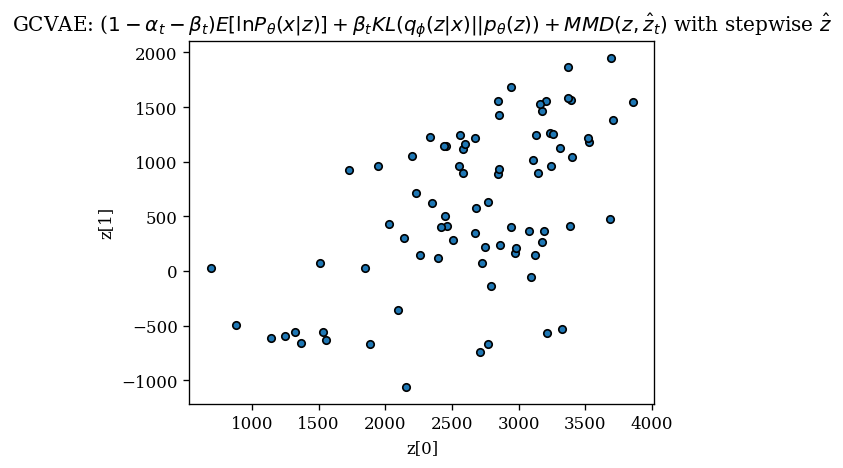

In [103]:
z_mean, z_std, z = model.model.encoder.predict(x_test, batch_size = batch_size)

fig = plt.figure(figsize=(5, 4))
plt.scatter(z[:, 0], z[:, 1], edgecolor="black", s = 20)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
if loss_index == 0:
    plt.title('VAE Loss: $E [\ln P_{\\theta}(x|z)]$ + $KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 1:
    plt.title('$\\beta$-VAE: $E [\ln P_{\\theta}(x|z)]$ + $\\beta KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 2:
    plt.title('ControlVAE: $E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 3:
    plt.title('infoVAE: ($E [\ln P_{\theta}(x|z)] + \\beta KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z_{t+1}, \\hat{z}_t)$ with stepwise $\\hat{z}$')
elif loss_index == 4:
    plt.title('GCVAE: ($1-\\alpha_t- \\beta_t)E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z,\\hat{z}_t)$ with stepwise $\\hat{z}$')


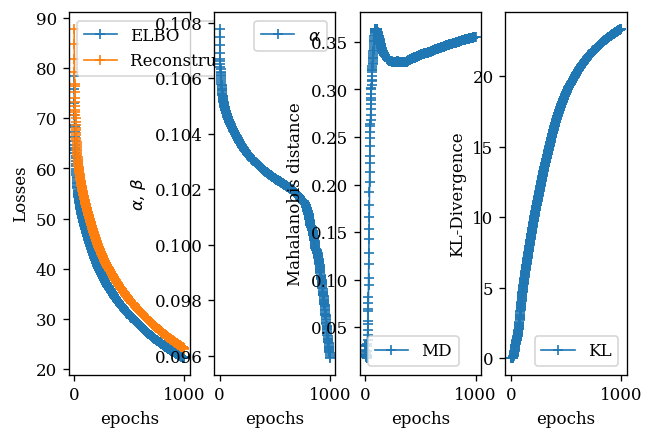

In [105]:
fig, ax = plt.subplots(1, 4)
ax[0].plot(np.arange(model.epoch), model.ELBO, label = 'ELBO', marker = '+', lw = 1.)
ax[0].plot(np.arange(model.epoch), model.RECON_LOSS, label = 'Reconstruction loss', marker = '+', lw = 1.)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Losses')
ax[1].plot(np.arange(model.epoch), model.ALPHA, label = '$\\alpha$', marker = '+', lw = 1.)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('$\\alpha$, $\\beta$')
ax[2].plot(np.arange(model.epoch), model.MMD, label = 'MD', marker = '+', lw = 1.)
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Mahalanobis distance')
ax[3].plot(np.arange(model.epoch), model.KL_DIV, label = 'KL', marker = '+', lw = 1.)
ax[3].set_xlabel('epochs')
ax[3].set_ylabel('KL-Divergence')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

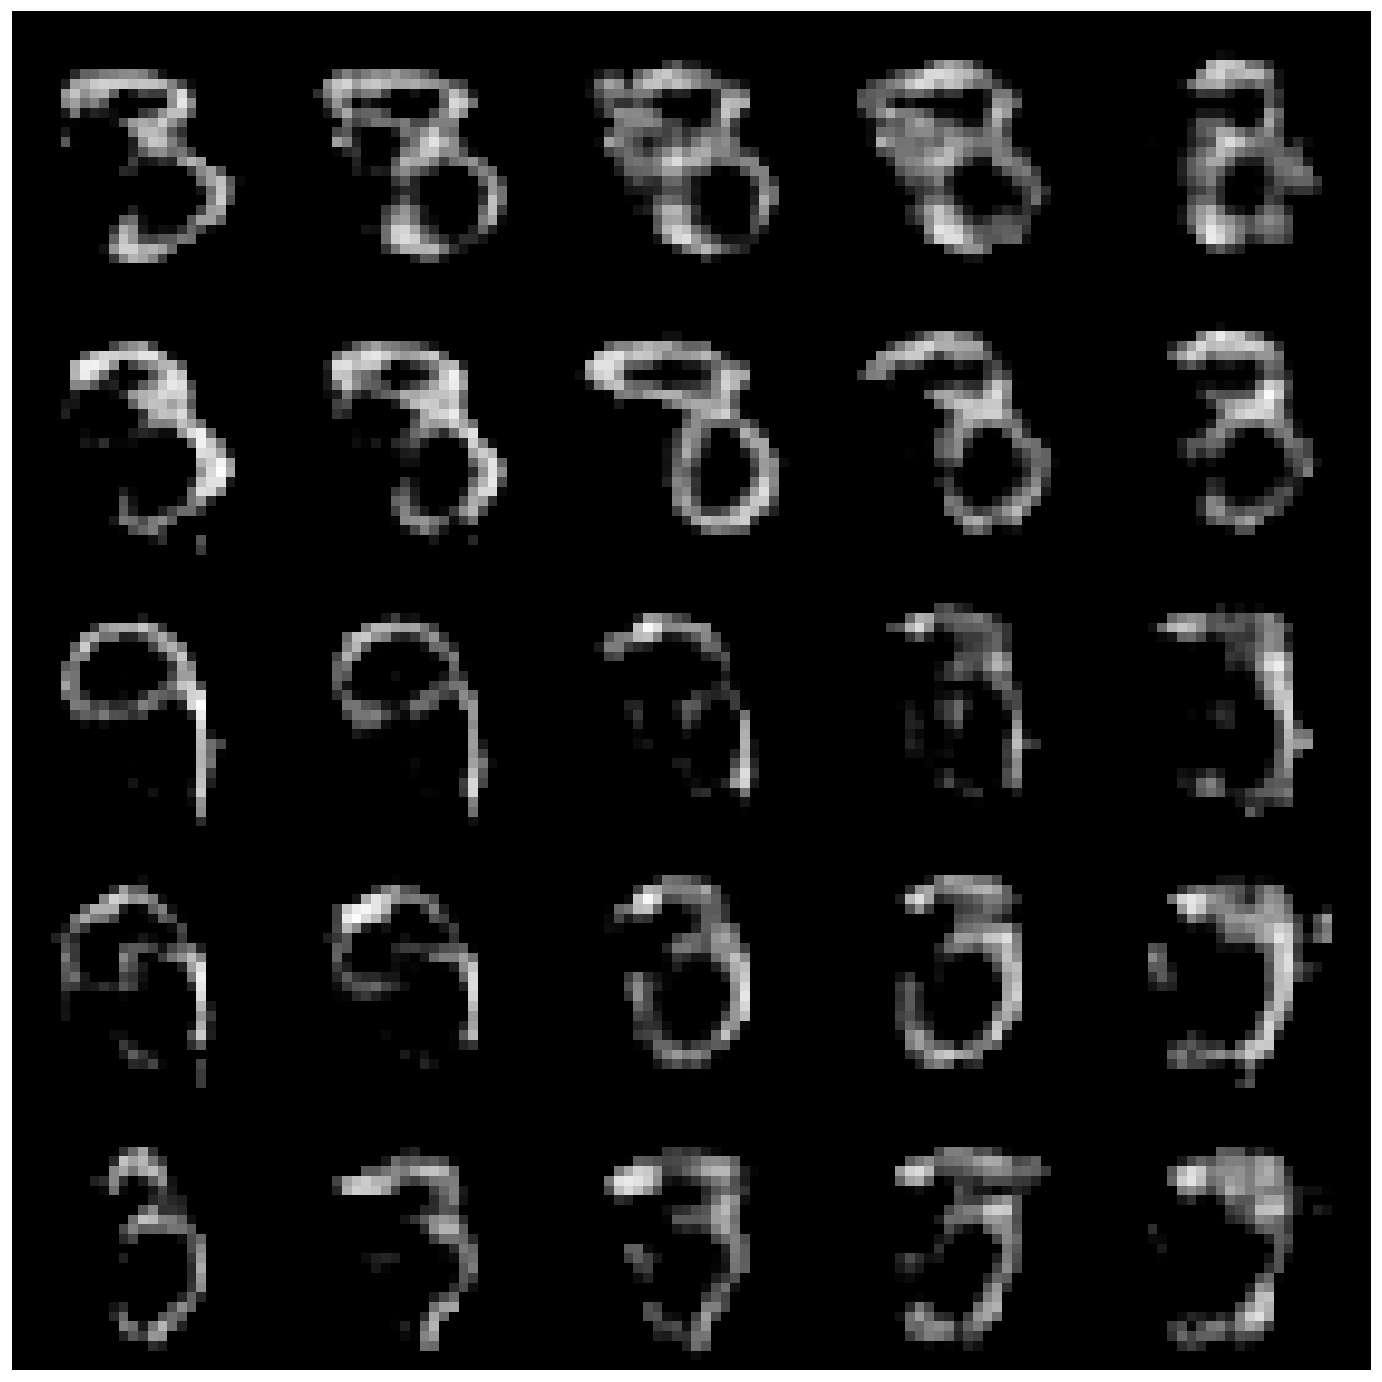

In [104]:
plot_latent_space(model.model, n= 5)